In [1]:
###############################################################
#
# Consumer-Resource model with production.
# Produces eigenvalue plots for symmetric and asymmetric P
# matrices.
# Each resource density = r
# Each species abundance = s
# Consumption matrix C = c*I  ### Completely specialized
#
###############################################################

# From Butler, O'Dwyer (2018)

In [2]:
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import eigvals
import math as mt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"     

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

np.set_printoptions(precision=7)

np.random.seed(999)

In [3]:
mpl.rcParams['figure.dpi'] = 125
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})

In [4]:
# Functions for O'Dwyer model
from ODwyer_Tools import *
# "" for Arnoldi stability measures
from Arnoldi_Tools import *
# "" for diversity measures
from Diversity_Measures import *

# Arnoldi Measures

## Misc.

In [5]:
def community_matr_gen(C_,P_,eps_,mu_,rho_):
    '''
    Returns L, the community matrix (Jacobian) of an O'Dwyer system described by given:
        Consumption matrix C,
        Production matrix P, 
        Exogenous mu,
        rho
    '''
    n = P_.shape[-1]
    k = P_.shape[0]
    I = np.identity(n)
        
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C_, P_, eps_, mu_)
    S_star = S_star_gen(C_, P_, R_star, rho_)
    
    # Community Matrix Partitions
    CS = np.dot(C_, S_star).T.reshape(k,n,1) # can use regular .T because first dimension is 1
    CR = np.dot(C_, R_star).T.reshape(k,n,1)
    
    LA  = -CS * I
    LB = P_ - CR * I
    # LC = eps_ * CS * I # WRONG
    d_idx = np.diag_indices(n)[0]
    S_diag = np.zeros((k,n,n))
    S_diag[:,d_idx,d_idx] = S_star.reshape(k,n)
    LC = eps_ * np.dot(S_diag, C_.T)

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)
    
    return L

## "Resilience, reactivity and variability..." (2016)

In [6]:
# Example parameters to test functions
np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
P = symPvec(sig = 1, n = n, k = k)

J = community_matr_gen(C,P,eps,mu,rho)
J.shape

(1000, 4, 4)

In [7]:
# Equilibria
R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

### Testing Arnoldi measure functions

In [8]:
# 'A' will mean a (k,2*n,2*n) stack of community matrices (Jacobian evaluated at R_star,S_star)
# Suffix _mb to denote measures computed from O'Dwyer MicroBiome model

Stability measures are functions of the community matrix eigenvalues.
Diversity measures are functions of (equilibrium) population distributions, which themselves are
functions of the (random) choice of parameters. The community matrix eigenvalues are also a function of the (random) choice of parameters (see the Jacobian formula for O'Dwyer model).

Additionally, as for the supposed complexity of the O'Dwyer formulas, finding the distribution of the equilbria amounts to finding the PDF of the sum of n IID half-normal random variables.

PDF for sum of 2 half-normals (wrong by factor of 2?):

$$ f_{|Z_1|+|Z_2|}(x) =  \frac{2\sqrt{2}}{\sqrt{\pi}}e^{-\frac{1}{2}x^2}\text{erf}(\frac{x}{\sqrt{2}})$$
$$ f_{|Z_1|+|Z_2|}(x) = \frac{4}{\pi}e^{-\frac{1}{2}x^2}\int_0^{\frac{x}{\sqrt{2}}}e^{-t^2}dt $$ #2 is wrong

## "How ecosystems recover ..." (2018) [CAN SKIP]

"We showed that in large, complex communities, due to the presence
of species with very different abundances, asymptotic resilience need not even be a good predictor 
of return rates at longer times."

"[...] asymptotic resilience should not be used as a proxy for the short-term recovery."

(pg. 8 "How ecosystems recover[...]")

In [9]:
### Arnoldi  "How ecosystems recover..."
n = 20 #repeated
import scipy as sp # for matrix exponential
from scipy.linalg import expm

In [10]:
# Return Rates
def R_avg(x, t, u):
    '''
    Average rate of return at current displacement 'x' after time 't' since initial perturbation 'u'
    '''
    return -( np.log(np.linalg.norm(x,2)) - np.log(np.linalg.norm(u,2))) / t

In [11]:
# Arnoldi Appendix E suggests def'n v with v_i std Gaussian, then normalize to u. Why Gaussian?? 
def u_gen_unif(n):
    '''
    Generate uniformly distributed unit-length  perturbation vector u.
    
    The direction is ostensibly the uniformly distributed value.
    '''
    v = np.random.normal(0,1,n) # so-called 'v' in Arnoldi
    return v/np.linalg.norm(u,2) # does this provide uniformly distributed perturbation direction? They say so.

In [12]:
# Really, according to Arnoldi, perturbations should tend to have greater effect on more abundant species.
# This is pretty subjective, I suppose? Is there empirical justification for this 'tendency'?

In [13]:
# Perturbation covariance matrix, Cov, for uniform perturbation direction
Cov_unif = np.identity(n)/n # for when equilibrium populations not being considered in perturbation distribution

In [14]:
# Choose an example system for testing Arnoldi measures
n_arn = 5
k_arn = 2
sig_arn = 1
eps = 0.25
c = 1
I = np.identity(n_arn)*c
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn)

In [15]:
R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
R_arn
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
S_arn

array([[[29.099472 ],
        [22.3795045],
        [12.1129193],
        [30.4873724],
        [28.0960887]],

       [[16.6110594],
        [18.3087185],
        [21.2786606],
        [19.4290301],
        [18.1422164]]])

array([[[0.0408842],
        [0.0556873],
        [0.1039452],
        [0.0416802],
        [0.046823 ]],

       [[0.0659291],
        [0.0734357],
        [0.0598155],
        [0.0687152],
        [0.0647963]]])

In [16]:
LA  = -c * S_arn * I

LB = aP_arn - c * R_arn * I

LC = eps * c * S_arn * I
LD = np.zeros((k_arn,n_arn, n_arn))

L_top = np.concatenate((LA, LB), 2)
L_bot = np.concatenate((LC, LD), 2)
L_arn  = np.concatenate((L_top,L_bot), 1)

In [17]:
RS_star = np.concatenate((R_arn,S_arn), 1) #(k,2*n,1), an example equilibrium
RS_star1, RS_star2 = RS_star

LAM = np.sum(np.square(RS_star)) #lambda, from Arnoldi Appendix E
Cov_prop = np.zeros((k_arn, 2*n_arn, 2*n_arn))
di_C = np.diag_indices(2*n_arn)
#Below LHS will be (k_arn, n_arn)
Cov_prop[:,di_C[0],di_C[1]] = (np.square(RS_star)/LAM).reshape(k_arn,2*n_arn) ### From Arnoldi Appendix E, Covariance matrix when u_i prop. to N*_i

In [18]:
#Appendix E says the following:
def u_gen_prop(n, Nstar):
    ''' 
    Generate random perturbation 'u' such that u_i proportional to N*_i (population-proportional perturbations).
    '''
    v = np.random.normal(0,1,2*n).T
    D = np.diag(Nstar.reshape(2*n))
    w = np.dot(D,v) # really just pairwise multiplication of Nstar and v
    u = w/np.linalg.norm(w,2)
    return u

# This is a more suitable perturbation model: Expectation of u_i proportional to N*_i

In [19]:
### Median approximations
def disp_median(A,Cov,t): # community matrix A, Covariance matrix Cov, time t
    # displacement = ||x(t)||
    return np.sqrt(np.trace(expm(A*t)*Cov*expm(A.T*t)))

def R_avg_median(A,Cov,t): 
    '''Median of the average return rates'''
    return -(np.log(np.trace(expm(A*t)*Cov*expm(A.T*t))) - np.log(np.trace(Cov))) / (2*t)

In [20]:
disp_med = disp_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
disp_med

R_avg_med = R_avg_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
R_avg_med

0.6521860049781745

0.20796796234736203

In [21]:
### Return time 
#c, chosen threshold distance from equilibrium
# T(c) = min(t) such that ||x(t+s)|| <= c for all s>=0 #(does not displace back out of threshold once it reaches return time)

# This will require a numerical solution

In [22]:
### Numerical solution to a simple system
# Careful of going back and re-running above blocks, reusing a lot of vars here
n_arn = 2
k_arn = 1
sig_arn = 1
eps = 0.25
c = 1
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

np.random.seed(667)
aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn) * c

R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
RS_arn = np.concatenate((R_arn,S_arn),1)

In [23]:
temp = community_matr_gen(C_=C_arn, P_=aP_arn, eps_=0.25, mu_=mu_arn, rho_=rho_arn)

In [24]:
init_res(temp)

array([-8.6529753])

In [25]:
RS_arn

array([[[18.6339036],
        [ 6.1867023],
        [ 0.0588075],
        [ 0.1984622]]])

In [26]:
u_ex = u_gen_prop(n_arn,RS_arn.reshape(4))
np.linalg.norm(u_ex,2) #cool?

0.9999999999999999

In [27]:
# Just working with one example system, can get rid of "Stacking" for simplicity
aP_arn = aP_arn.reshape(n_arn,n_arn)
RS_arn = RS_arn.reshape(2*n_arn,1)

In [28]:
aP_arn
RS_arn

array([[1.4172386, 0.0628305],
       [2.2412373, 0.4838451]])

array([[18.6339036],
       [ 6.1867023],
       [ 0.0588075],
       [ 0.1984622]])

In [29]:
# Start with simple n=2 system for convenience starting out
def ResrcProd(N, t, C, P, mu, rho, eps): # why t? Unused

    R0, R1, S0, S1 = N # Ok, Resources are much more abundant

    dNdt = [rho[0]-R0*(C[0,0]*S0 + C[0,1]*S1) + P[0,0]*S0 + P[0,1]*S1,
            rho[1]-R1*(C[1,0]*S0 + C[1,1]*S1) + P[1,0]*S0 + P[1,1]*S1,
            eps*S0*( (C.T)[0,0]*R0 + (C.T)[0,1]*R1 ) - S0*((P.T)[0,0] + (P.T)[0,1]) - mu[0]*S0,
            eps*S1*( (C.T)[1,0]*R0 + (C.T)[1,1]*R1 ) - S1*((P.T)[1,0] + (P.T)[1,1]) - mu[1]*S1
           ]

    return dNdt

In [30]:
step = ResrcProd(list(RS_arn.reshape(2*n_arn)), 1, C_arn, aP_arn, list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps)

In [31]:
step
len(step)

[5.377642775528102e-17, 8.326672684688674e-17, 1.3877787807814457e-17, 0.0]

4

In [32]:
from scipy.integrate import odeint
import pandas as pd # once we start numerical solutions, might make sense to switch to dataframes

In [33]:
# Numerical solution for (2,2) system

t = np.linspace(0, 100, 1001) # time to simulate
RS_arn
u_2 = u_gen_prop(n_arn,RS_arn)
np.linalg.norm(u_2,2) # works
u_2 # proportions look good



array([[18.6339036],
       [ 6.1867023],
       [ 0.0588075],
       [ 0.1984622]])

1.0

array([ 0.9567196, -0.2909047,  0.0013916,  0.0077568])

In [34]:
init_cond = list(u_2+RS_arn.reshape(2*n_arn))
u_2
RS_arn
init_cond

array([ 0.9567196, -0.2909047,  0.0013916,  0.0077568])

array([[18.6339036],
       [ 6.1867023],
       [ 0.0588075],
       [ 0.1984622]])

[19.59062315010446,
 5.895797615844816,
 0.06019914218194761,
 0.20621896228233302]

In [35]:
sol = odeint(ResrcProd, init_cond, t, args=(C_arn, aP_arn.reshape(2,2), list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps))


In [36]:
sol.shape
sol = np.array(sol)

(1001, 4)

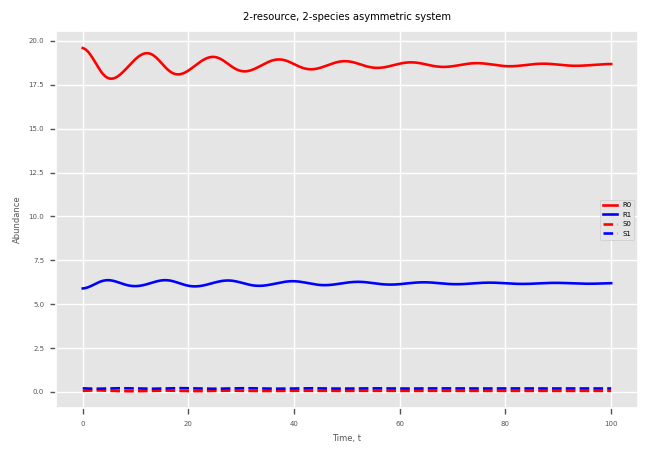

In [37]:
plt.plot(t, sol[:,0], 'r', label = 'R0');
plt.plot(t, sol[:,1],'b', label = 'R1');
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();

plt.title('2-resource, 2-species asymmetric system')
plt.xlabel('Time, t');
plt.ylabel('Abundance');

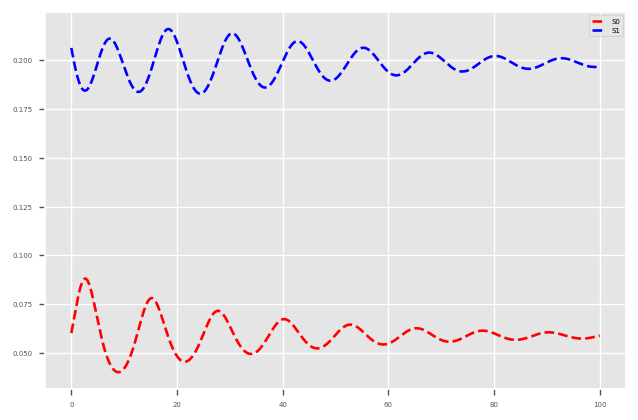

In [38]:
# giving the little guys a chance
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();


In [39]:
init_cond

[19.59062315010446,
 5.895797615844816,
 0.06019914218194761,
 0.20621896228233302]

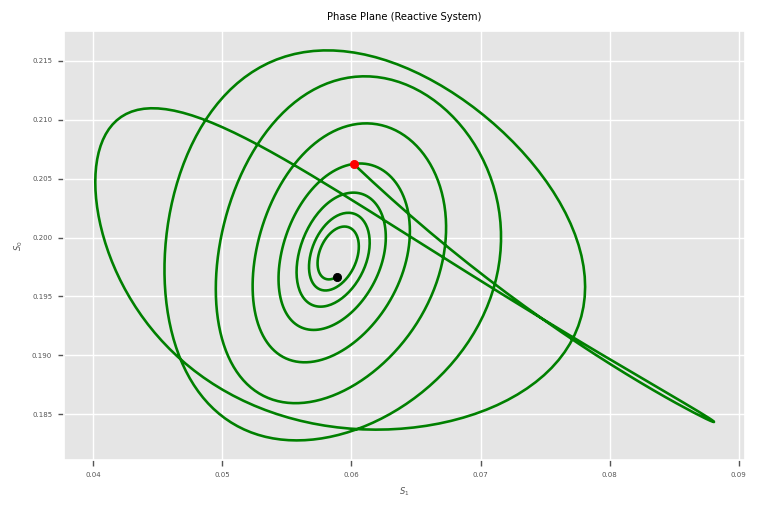

In [40]:
plt.plot(sol[:,2], sol[:,3], 'g', zorder=1);
plt.title('Phase Plane (Reactive System)');
plt.scatter(init_cond[2],init_cond[3], s=22, color='red', zorder=10);
plt.scatter(sol[-1,2], sol[-1,3], s=22, color='black', zorder=10);
plt.xlabel(r'$S_1$');
plt.ylabel(r'$S_0$');
plt.tight_layout();

In [41]:
sol_xs = np.tile(RS_arn.reshape(4), (len(t), 1)) - sol # running difference between each state variable and its respective equilibrium
sol_xs

array([[-9.5671959e-01,  2.9090468e-01, -1.3916157e-03, -7.7567571e-03],
       [-9.4732102e-01,  2.8847451e-01, -2.8418950e-03, -6.2682137e-03],
       [-9.3532805e-01,  2.8497854e-01, -4.3102525e-03, -4.8054546e-03],
       ...,
       [-4.4877116e-02, -7.4437734e-03,  6.3019833e-05,  1.8774799e-03],
       [-4.4654079e-02, -8.3416556e-03, -2.7741033e-06,  1.8386759e-03],
       [-4.4319638e-02, -9.2134352e-03, -6.8231311e-05,  1.7955129e-03]])

In [42]:
np.mean(np.square(sol[:,-2:] - S_arn.reshape(1,2)), axis=1)

array([3.1051937e-05, 2.3683435e-05, 2.0835335e-05, ..., 1.7644512e-06,
       1.6903683e-06, 1.6142611e-06])

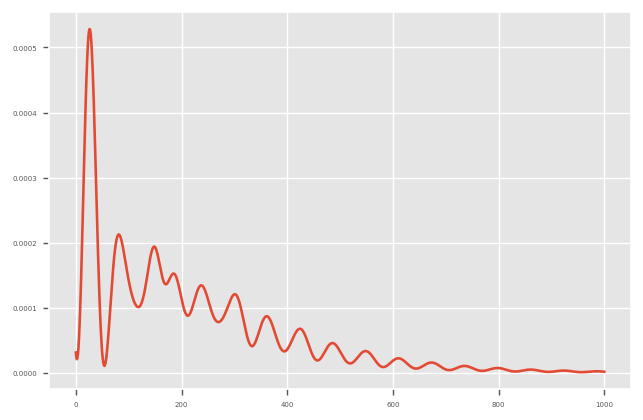

In [43]:
plt.plot(np.arange(1001), np.mean(np.square(sol[:,-2:] - S_arn.reshape(1,2)), axis=1));

# Diversity Measures
$$ ^q \lambda = \sum^{S}_{i=1} p_i^q$$
For $q=1$, all species weighted equally, "without favoring either common or rare species."

All diversity indices
of a given order $q$ have the same true diversity $^qD$

In [44]:
### Parameter/System Reminder
    ### SAME as from section "Arnoldi Measures"

np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
P = symPvec(sig = 1, n = n, k = k)
# P = asymPvec(sig = 1, n = n, k = k) # FOR n>5, no (empirical?) guarantee of stability
J = community_matr_gen(C,P,eps,mu,rho)
J.shape

R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

(1000, 4, 4)

In [45]:
## O'Dwyer Stability measures are already computed by this point
# NOTE: Stability measures computed from O'Dwyer systems are stored as:
# R_0_mb
# I_S_mb
# I_D_mb
# R_inf_mb

# Now, will have _mb## suffix to denote the size of the system (EX: _mb10 for n=10)

## Jost    
All diversity index functions below will take equilibrium vector $N$ and return raw index, not the numbers equivalent.



In [46]:
s_star = sum_to_one(S_star)
r_star = sum_to_one(R_star)

In [47]:
simpson_s = simpson_conc(s_star)
simpson_r = simpson_conc(r_star)

In [48]:
shannon_s = shannon_entropy(s_star)

shannon_r = shannon_entropy(r_star)
shannon_sr = np.concatenate((shannon_s,shannon_r))

In [49]:
gini_simp_s = gini_simpson_index(s_star)
gini_simp_r = gini_simpson_index(r_star)
gini_simp_sr = np.concatenate((gini_simp_s,gini_simp_r))

In [50]:
# Get numbers equivalents from Gini-Simpson
D_s = 1/(1-gini_simp_s)
D_r = 1/(1-gini_simp_r)
D_sr = np.concatenate((D_s,D_r))

In [51]:
np.mean(simpson_s)
np.mean(shannon_s)
np.mean(gini_simp_s)
np.mean(D_s)

0.5061642173101898

0.6869369197545867

0.4938357826898102

1.976340939492245

In [52]:
w = np.ones(k)/k # assume k equally weighted communities? Like from k different communities
D1_alpha = numbers_equiv_alpha(w, s_star, 1)

D1_gamma = numbers_equiv_gamma(w, s_star, 1)
print('alpha: ', D1_alpha)
print('gamma: ', D1_gamma)
D1_beta = D1_gamma/D1_alpha
print('beta: ', D1_beta)

alpha:  1.9876179660146078
gamma:  1.0
beta:  0.5031147922279601


#  O'Dwyer Stability vs. Diversity Plots

In [53]:
def D_1(p):
    if p.ndim == 1:
        p = p.reshape(1,p.size,1)

    return np.exp(- np.sum(p*np.log(p), axis=1))

In [54]:
def uniformish_D(n, k, res=100):
    alphas = np.linspace(0.1,1, res).reshape(-1,1) * np.ones((res,n))
    # dir_Ds = np.zeros(res)
    stds = np.zeros(res)
    for i in range(res):
        # dir_Ds[i] = D_1(sum_to_one(np.random.dirichlet(alphas[i,:], size=k).reshape(k,n,1)))
        stds[i] = np.nanstd(D_1(sum_to_one(np.random.dirichlet(alphas[i,:], size=k).reshape(k,n,1))))
        
    return [np.max(stds), alphas[np.argmax(stds)]]

## n-Species system

In [55]:
# Add lo(w)ess to plots
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [56]:
# Numbers equivalents column shows tendency toward ~2.0 effective species, 
    # a result of many species vectors being split about 50/50 at equilibrium.
# We know that the Numbers Equivalent never goes below 1.

### Community Matrix Fn

In [57]:
def community_matr_gen_noP(n_, k_, C_, eps_, R_star_, S_star_):

    I = np.identity(n_)
        
    LD = np.zeros((k_, n_, n_)) # Bottom right
    
    # Community Matrix Partitions
    d_idx = np.diag_indices(n_)[0]
    R_diag = np.zeros((k_,n_,n_))
    R_diag[:,d_idx,d_idx] = R_star_.reshape(k_,n_)
    
    S_diag = np.zeros((k_,n_,n_))
    S_diag[:,d_idx,d_idx] = S_star_.reshape(k_,n_)
    
    A_temp = - np.dot(C_, S_star_)
    A_temp = np.transpose(A_temp, (1,0,2))
    
    LA = np.zeros((k_,n_,n_))
    LA[:,d_idx,d_idx] = A_temp.reshape(k_,n_) # Top left
    LB = - np.dot(R_diag, C_) # Top right

    LC = eps_ * np.dot(S_diag, C_.T) # Bottom left

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)
    
    return L

### System class

In [58]:
class ODsystem:
    '''
    O'Dwyer systems + their community matrices and equilibria + Arnoldi Measures.
    VERY slow when n>~6, quadratic time from needing to for-looping I_S and I_D.
    -------------------------------------------------------
    Specify:
    k, number of systems
    n, number of species and number of resources
    mu, vector of mortality rates
    rho, vector of resource influx rates
    eps, resource consumers' conversion efficiency of biomass
    sig_P, standard deviation of entries in production matrix P
    C, consumption matrix
    '''
    def __init__(self, k_=1000,n_=5, eps_=0.25, alpha_EQ_ = None, C_ = None, seed_=667):
        self.seed = seed_
        np.random.seed(self.seed)
        self.k = k_
        self.n = n_
        self.eps = eps_
        self.alpha_EQ = alpha_EQ_
        
        if (alpha_EQ_ == None):
            self.R_star = np.random.uniform(0,1, (self.k, self.n, 1))
            self.S_star = np.random.uniform(0,1, (self.k, self.n, 1))
        else:
            self.R_star = np.random.dirichlet(self.alpha_EQ*np.ones(self.n), size=self.k).reshape(self.k,self.n,1)
            self.S_star = np.random.dirichlet(self.alpha_EQ*np.ones(self.n), size=self.k).reshape(self.k,self.n,1)
        if C_ is None:
            self.C = np.identity(self.n)
        else:
            self.C = C_
        
        
        self.s_star = sum_to_one(self.S_star)
        self.r_star = sum_to_one(self.R_star)
        
        blankones = np.ones((self.k,self.n,self.n))
        self.mu = dot_across(np.dot(self.eps * np.eye(self.n), np.transpose(self.C)) * blankones, self.R_star)
        self.rho = dot_across(dot_across(np.eye(self.n)*self.R_star, self.C*blankones), self.S_star)
        
        #(n_, k_, C_, eps_, R_star_, S_star_)
        self.J = community_matr_gen_noP(n_=self.n, k_=self.k, C_=self.C, eps_=self.eps, R_star_=self.R_star, S_star_=self.S_star)
        # self.R_star = R_star_gen(self.C,self.P,self.eps,self.mu)
        # self.S_star = S_star_gen(self.C,self.P,self.R_star,self.rho)
        
        ### Arnoldi Measures ###
        self.R_0 = init_res(self.J)
        self.R_inf = asym_res(self.J)
        self.I_S = np.zeros(self.k)
        for i in range(self.k):
            self.I_S[i] = stoch_invar(self.J[i,:,:])
        self.I_D = np.zeros(self.k)
        for i in range(self.k):
            self.I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(self.J[i,:,:]), method='brent').fun

        ### Diversity Measures ###
        self.simpson_s = simpson_conc(self.s_star)
        self.shannon_s = shannon_entropy(self.s_star)
        self.gini_simp_s = gini_simpson_index(self.s_star)
        self.hcdt_entropy_s = hcdt_entropy(self.s_star, q=2)
        self.renyi_entropy_s = renyi_entropy(self.s_star, q=2)
        self.D_s = D_1(self.s_star)
        

In [59]:
# List div_inds_, whichever diversity measures to include in plots (easier to just use idx)
## How deal with negative space? Leave blank for now? Find way to collapse negative space.
def OD_stab_div_plot(OD_, div_idx_=list(range(6)), fsize=(7,6), res = 250, fontsize=4, q=2, lowess_frac=None, lowess_col='black', title = '', one_col=None, s_=3, save_as=None, img_type='pdf'):
    q_renyi=q
    q_hcdt=q
    # q_renyi = int(input('q (order of diversity) for Renyi entropy?'))
    # q_hcdt = int(input('q for HCDT entropy?'))
    hcdt = hcdt_entropy(s_star, q=q_hcdt)
    renyi = renyi_entropy(s_star, q=q_renyi)

    xlist = np.array([OD_.simpson_s, OD_.shannon_s, OD_.gini_simp_s, hcdt, renyi, OD_.D_s], dtype=object)
    xlist = list(xlist[div_idx_])
    xnames = np.array(['Simpson', 'Shannon', 'Gini-Simpson', r'HCDT, q={}'.format(q_hcdt), 'Renyi, q={}'.format(q_renyi), 'D, Numbers Equivalent'], dtype=object)
    xnames = list(xnames[div_idx_])
    ylist = [OD_.R_0, OD_.R_inf, OD_.I_S, OD_.I_D]
    ynames = [r'$\mathcal{R}_0$', r'$\mathcal{R}_{\infty}$', r'$\mathcal{I}_S$', r'$\mathcal{I}_D$']

    plt.figure(figsize=fsize, dpi=res)
    plt.style.use('ggplot')
    mpl.rcParams.update({'font.size': fontsize})
    thetitle = 'Stability against diversity in resource-competition ($n=${}) \n{}'.format(OD_.n, title)
    if (one_col==None):
        # if lowess_frac:
            # thetitle = thetitle + '\nLOWESS with fraction {}'.format(np.round(lowess_frac,3))
        plt.suptitle(thetitle);

    colors = ['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000', '#00000f']

    dimx = len(xlist)
    dimy = len(ylist)

    for i,stab in enumerate(ylist):
        for j,divind in enumerate(xlist):
            
            plt.subplot(dimy, dimx, i*dimx+j+1)
            if (i!=dimy-1):
                plt.tick_params('x', which='both', bottom=False, labelbottom=False);
            if (one_col==None):
                plt.scatter(divind, stab, s = s_, alpha=0.5, color = colors[j%dimx+len(colors)-2]);
            else:
                plt.scatter(divind, stab, s = s_, alpha=0.5, color = one_col);
            plt.xlim((1,OD_.S_star.shape[1]));
            if lowess_frac:
                w = lowess(stab.reshape(-1), divind.reshape(-1), frac=lowess_frac)
                if j != len(div_idx_)-1:
                    plt.plot(w[:,0], w[:,1], c=lowess_col, linestyle='dashed', linewidth=0.5, alpha=1.00)
                else:
                    if (one_col==None):
                        plt.plot(w[:,0], w[:,1], c='black', linestyle='dashed', linewidth=0.5, alpha=1.00)
                    else:
                        plt.plot(w[:,0], w[:,1], c=lowess_col, linestyle='dashed', linewidth=0.5, alpha=1.00)
            if j%dimx == 0:
                plt.ylabel(ynames[i]);
            if i == dimy-1:
                plt.xlabel(xnames[j]);

    
    plt.tight_layout();
    
    if (save_as != None):
        plt.savefig(save_as+'.{}'.format(img_type), format=img_type)
        

In [60]:
blankones = np.ones((1000,3,3))
np.random.seed(667)
R_star = np.random.uniform(0,1,(1000,3,1))
S_star = np.random.uniform(0,1,(1000,3,1))

In [61]:
np.random.seed(667)
alphs3 = np.zeros((100,3))
for i in range(100):
    alphs3[i] = uniformish_D(n=3, k=1000, res=100)[1]

In [62]:
np.random.seed(667)
R_unifD = np.random.dirichlet(np.mean(alphs3, axis=0), size=1000)
S_unifD = np.random.dirichlet(np.mean(alphs3, axis=0), size=1000)

In [63]:
np.random.seed(667)
alphs5 = np.zeros((100,5))
for i in range(100):
    alphs5[i] = uniformish_D(n=5, k=1000, res=100)[1]

In [64]:
# np.random.seed(667)
# alphs10 = np.zeros((100,10))
# for i in range(100):
#     alphs10[i] = uniformish_D(n=10, k=1000, res=100)[1]

In [65]:
# np.random.seed(667)
# alphs15 = np.zeros((100,15))
# for i in range(100):
#     alphs15[i] = uniformish_D(n=15, k=1000, res=100)[1]

In [66]:
# np.random.seed(667)
# alphs20 = np.zeros((100,20))
# for i in range(100):
#     alphs20[i] = uniformish_D(n=20, k=1000, res=100)[1]

In [67]:
# np.random.seed(667)
# alphs50 = np.zeros((100,50))
# for i in range(100):
#     alphs50[i] = uniformish_D(n=50, k=1000, res=100)[1]

In [68]:
np.mean(alphs3, axis=0)[0]

0.3342727272727273

In [69]:
np.mean(alphs5, axis=0)[0]

0.36399999999999993

In [70]:
# np.mean(alphs10, axis=0)[0]

# np.mean(alphs15, axis=0)[0]

# np.mean(alphs20, axis=0)[0]

# np.mean(alphs50, axis=0)[0]

### Mimic a few of the C examples from O’Dwyer paper
 

In [71]:
np.random.seed(667)
# No suffix, perfect (diagonal) specialism

# Left, 
## CL1, near-specialism (specialism greater than off-diag)
## CL2, near-generalism (specialism weaker than off-diag)
# Right, smooth curve away from preferred resource ("spectrum of similarity for resources")
## CR1, near perfect diagonal specialism (with corners?)
## CR2, sinusoid-ish (0,1)?
nC = 20

CL1 = np.random.uniform(0,0.4, (nC,nC))
np.fill_diagonal(CL1, np.random.uniform(0.8, 1, nC)) # Inplace

CL2 = np.random.uniform(0.8, 1, (nC,nC))
np.fill_diagonal(CL2, np.random.uniform(0,0.4, nC))

C:\Users\riley\AppData\Local\Temp/ipykernel_13768/2665186147.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(pad=0.1);


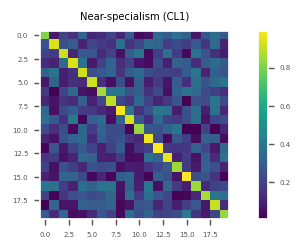

In [72]:
plt.figure(figsize=(3,2));
plt.imshow(CL1);
plt.grid(False);
plt.colorbar(pad=0.1);
plt.title('Near-specialism (CL1)');

# Grid warning just a bug from using plt.style.use('ggplot')

C:\Users\riley\AppData\Local\Temp/ipykernel_13768/3001280663.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(pad=0.1);


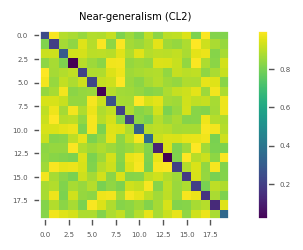

In [73]:
plt.figure(figsize=(3,2));
plt.imshow(CL2);
plt.colorbar(pad=0.1);
plt.grid(False);
plt.title('Near-generalism (CL2)');

In [74]:
def fill_near_diag(x,y):
    # Adjust exponent for harder fall-off? Still not as intense as in O'Dwyer (They say smooth, but does not look very smooth in diagram)
    return 1 - (np.abs(x-y) / (nC-1) )**2


In [75]:
CR1 = np.fromfunction(fill_near_diag, (nC,nC))

CR1[-1,0] = 0.9
CR1[0,-1] = 0.9

C:\Users\riley\AppData\Local\Temp/ipykernel_13768/4115209213.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(pad=0.1);


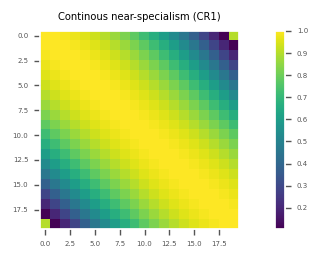

In [76]:
fig = plt.figure(figsize=(3,2));
ax = fig.gca();
plt.imshow(CR1);
plt.title('Continous near-specialism (CR1)');
ax.grid(False);
plt.colorbar(pad=0.1);
plt.tight_layout();

In [77]:
def fill_periodic(x,y):
    return 0.5 * (np.cos( 2*np.pi * np.abs(x-y) / (nC-1) ) + 1)

In [78]:
CR2 = np.fromfunction(fill_periodic, (nC,nC))

C:\Users\riley\AppData\Local\Temp/ipykernel_13768/3656014039.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(pad=0.1);


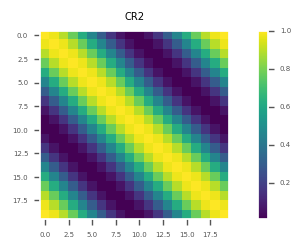

In [79]:
plt.figure(figsize=(3,2));
plt.imshow(CR2);
plt.title('CR2');
plt.grid(False);
plt.colorbar(pad=0.1);

### Load large O'Dwyer systems from local files

In [80]:
import pickle # Save OD10-20 bc they are quite slow to calculate every single time.

In [81]:
# # Run to save objects locally once calculated
# with open(r'E:\Progrumping\Microbiome\OD10.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD10, OD_obj_file)
# with open(r'E:\Progrumping\Microbiome\OD15.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD15, OD_obj_file)
# with open(r'E:\Progrumping\Microbiome\OD20.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD20, OD_obj_file)

In [82]:
### Varying C
# with open(r'./OD10_CL1.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD10_CL1, OD_obj_file)
# with open(r'./OD10_CL2.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD10_CL2, OD_obj_file)

In [83]:
with open(r'./OD10_CL1.ODsystem', 'rb') as OD_obj_file:
    OD10_CL1 = pickle.load(OD_obj_file)
with open(r'./OD10_CL2.ODsystem', 'rb') as OD_obj_file:
    OD10_CL2 = pickle.load(OD_obj_file)

In [84]:
np.min(eigvals(OD10_CL1.J).real)

-108.82056430213521

In [85]:
# # Trying to invert a singular matrix (a kronecker product??? in I_S)
# OD10_CR1 = ODsystem(n_=nC, C_ = CR1)
# OD10_CR2 = ODsystem(n_=nC, C_ = CR2)

In [86]:
# # Run to load from local.

# with open(r'./OD10.ODsystem', 'rb') as OD_obj_file:
#     OD10 = pickle.load(OD_obj_file)
# with open(r'./OD15.ODsystem', 'rb') as OD_obj_file:
#     OD15 = pickle.load(OD_obj_file)
# with open(r'./OD20.ODsystem', 'rb') as OD_obj_file:
#     OD20 = pickle.load(OD_obj_file)
    
# # r'E:\Progrumping\Microbiome\OD20.ODsystem'

### The plots

In [87]:
# OD2.stab_div_plot(lowess_frac=2./3) 

In [88]:
# OD3.stab_div_plot(lowess_frac=2./3)

In [89]:
# OD5.stab_div_plot(lowess_frac=2./3)

In [90]:
# OD10.stab_div_plot(lowess_frac=2./3)

In [91]:
# OD15.stab_div_plot(lowess_frac=2./3) # Fix the Simpson and Gini-Simpson columns' x-tick spacing

In [92]:
# OD20.stab_div_plot(lowess_frac=2./3)

In [93]:
# # Check out some summary stats between the system sizes
# np.mean(OD2.R_0)
# np.mean(OD3.R_0)
# np.mean(OD5.R_0)
# np.mean(OD10.R_0)
# np.mean(OD15.R_0)
# np.mean(OD20.R_0)

In [94]:
# np.std(OD2.shannon_s)
# np.std(OD3.shannon_s)
# np.std(OD5.shannon_s)
# np.std(OD10.shannon_s)
# np.std(OD15.shannon_s)
# np.std(OD20.shannon_s)

In [95]:
# np.std(OD2.D_s)
# np.std(OD3.D_s)
# np.std(OD5.D_s)
# np.std(OD10.D_s)
# np.std(OD15.D_s)
# np.std(OD20.D_s)

In [96]:
# mean_eff_no_species = np.mean(np.array([OD2.D_s, OD3.D_s,OD5.D_s,OD10.D_s,OD15.D_s,OD20.D_s]), 1)

In [97]:
# plt.figure(figsize=(4,3),dpi=200)
# mpl.rcParams.update({'font.size': 4})
# plt.scatter([2,3,5,10,15,20], mean_eff_no_species);
# plt.ylabel('Mean effective number of species, D');
# plt.xlabel('Number of species, n');
# # Linear makes sense? Must be less than n but no less than n-1

In [98]:
# # Mean difference between number of species and effective number of species

# mean_diff = np.array([np.mean(OD2.n - OD2.D_s),
# np.mean(OD3.n - OD3.D_s), 
# np.mean(OD5.n - OD5.D_s), 
# np.mean(OD10.n - OD10.D_s),
# np.mean(OD15.n - OD15.D_s),
# np.mean(OD20.n - OD20.D_s)])

In [99]:
# plt.figure(figsize=(7,6),dpi=200)
# mpl.rcParams.update({'font.size': 4})
# plt.scatter([2,3,5,10,15,20],mean_diff);
# plt.title('Mean difference between number of species and effective number of species, against number of species');
# plt.ylabel('Mean difference');
# plt.xlabel('Number of species, n');
# # Because the above graph is pretty convincingly linear (at least a good approximation?),
#     # the below might be hyperbolic? (1/n ish?)
#     # That implies that there is a horizontal asymptote (upper bound) on this mean 
#         # difference. Wild guess, 0.5?

## Double-checks

In [100]:
from sklearn.linear_model import LinearRegression

import pandas as pd

## Arnoldi plots for O'Dwyer (Continued)

In [101]:
def stab_stab_plot(sys_, color_, sys_type_, n_, C_, extra_=None, font_size_=4, numbins=5):
    mpl.rcParams['figure.dpi'] = 250
    plt.style.use('ggplot')
    mpl.rcParams.update({'font.size': 4})
    plt.rc('font', size=font_size_)
    # numbins=5


    plt.subplot(3,3,1)
    plt.scatter(x=sys_.I_S,y=sys_.R_0, s = 1, c=color_, alpha = 0.5);
    plt.xlabel(r'$\mathcal{I}_S$');
    plt.ylabel(r'$\mathcal{R}_0$');
    plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');
    plt.locator_params(axis="x", nbins=numbins)


    plt.subplot(3,3,2)
    plt.scatter(x=sys_.I_D,y=sys_.R_0, s=1, c=color_, alpha = 0.5);
    # plt.xlabel(r'$\mathcal{I}_D$');
    # plt.ylabel(r'$\mathcal{R}_0$');
    plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');
    plt.locator_params(axis="x", nbins=numbins)

    plt.subplot(3,3,3)
    plt.scatter(x=sys_.R_inf,y=sys_.R_0, s=1, c=color_, alpha = 0.5);
    plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');
    plt.locator_params(axis="x", nbins=numbins)

    plt.subplot(3,3,5)
    plt.scatter(x=sys_.I_D,y=sys_.I_S, s=1, c=color_, alpha = 0.5);
    plt.xlabel(r'$\mathcal{I}_D$');
    plt.ylabel(r'$\mathcal{I}_S$');
    plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');
    plt.locator_params(axis="x", nbins=numbins)


    plt.subplot(3,3,6)
    plt.scatter(x=sys_.R_inf,y=sys_.I_S, s=1, c=color_, alpha = 0.5);
    plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');
    plt.locator_params(axis="x", nbins=numbins)

    plt.subplot(3,3,9)
    plt.scatter(x=sys_.R_inf,y=sys_.I_D, s=1, c=color_, alpha = 0.5);
    plt.xlabel(r'$\mathcal{R}_{\infty}$');
    plt.ylabel(r'$\mathcal{I}_D$');
    plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');
    plt.locator_params(axis="x", nbins=numbins)

    plt.suptitle('Arnoldi Measures for {} Community Matrices, n={}, C={}{}'.format(sys_type_, n_, C_, extra_));

    plt.tight_layout();

In [102]:
# stab_stab_plot(OD3_CL1_noP, 'firebrick', 'O\'Dwyer', 3, 'CL1', ', no P', font_size_=5)

In [103]:
# stab_stab_plot(OD5, color_='red', sys_type_='O\'Dwyer', n_=5, C_='I', extra_ = ' ')

In [104]:
# stab_stab_plot(OD10, color_='red', sys_type_='O\'Dwyer', n_=OD10.n, C_='I', extra_=' ')

In [105]:
# stab_stab_plot(OD20, color_='red', sys_type_='O\'Dwyer', n_=OD20.n, C_='I', extra_=' ')

In [106]:
# OD20.I_D.max()

In [107]:
# OD20.I_D.min()

In [108]:
# idx = 68
# oms_OD = np.linspace(0,3,1000)
# id_OD20 = np.zeros(1000)
# for i, om in enumerate(oms_OD):
#     id_OD20[i] = determ_invar(om, OD20.J[idx])

# print(OD20.I_D[idx]) # What the system/optimizer found for I_D

# print(np.min(id_OD20)) # I_D found by brute force (evaluate I_D at many omega, take minimum)

# oms_OD[np.argmin(id_OD20)] # omega that gives I_D
# # What causes a resonance?

In [109]:
# plt.figure(figsize=(4,3), dpi=250)
# plt.plot(oms_OD, id_OD20);
# plt.axvline(x=oms_OD[np.argmin(id_OD20)], linestyle='--', c='k');
# plt.title('O\'Dwyer System Deterministic Invariability');
# plt.ylabel(r'$\mathcal{I}_D$');
# plt.xlabel(r'$\omega$');

## O'Dwyer plots after varying C

$\vec{R^*} = (C^T)^{-1} \frac{1}{\epsilon} (P^{T} \vec{1} + \vec{\mu})$

$\vec{S^*} = [(R^{*}_{diag})C - P]^{-1} \vec{\rho}$


In [110]:
def dot_across(A, x): # Wow, x can be vectors OR more matrices
    k_ = A.shape[0]
    n_ = A.shape[1]
    DI_k = np.diag_indices(k_)[0]
    prod = np.dot(A,x.reshape(k_,n_,-1)) # Do a better check for dimensions, doofus.
    return prod[DI_k,:,DI_k,:]

In [111]:
def mu_gen(eps_, C_, R_star_):
    n_ = C_.shape[-1]

    lhs = np.dot(eps_*np.eye(n_), C_)
    return np.transpose(np.dot(lhs, R_star_), (1,0,2))

In [112]:
def rho_gen(R_star_, C_, S_star_):
    k_ = R_star_.shape[0]
    n_ = C_.shape[-1]
    diag_idx = np.diag_indices(n_)[0]
    R_diag = np.zeros((k_,n_,n_))
    R_diag[:, diag_idx, diag_idx] = R_star_.reshape(k_, -1)
    
    lhs = np.dot(R_diag, C_)
    
    return dot_across(lhs, S_star_)

In [113]:
# Kronecker of (k-tall stacks of) (k,m,n) and (k,p,q) matrices should be shape (k**2, m*p, n*q)
def kronecker_across(A,B):
    if A.ndim==1:
        A = A.reshape(1,A.shape[0],A.shape[1])
    if B.ndim==1:
        B = B.reshape(1,B.shape[0],B.shape[1])
    if (A.shape[0]!=B.shape[0]):
        print("Different number of matrices on each side of product.")
    k_ = A.shape[0]
        
    KRON = np.kron(A,B)
    didx = np.diag_indices(k_)[0]
    # print(KRON.shape)
    # print(A.shape)
    # print(B.shape)
    kron = KRON.reshape(k_,k_, A.shape[1]*B.shape[1], A.shape[2]*B.shape[2])[didx,didx,:,:]
    
    return kron

In [114]:
def stoch_invar_vec(A):
    I = np.repeat(np.identity(A.shape[-1]).reshape(1,A.shape[-1],A.shape[-1]), A.shape[0], axis=0)
    A_hat = kronecker_across(A,I) + kronecker_across(I,A)
    
    temp = -np.linalg.inv(A_hat)
    spec_norm = np.linalg.norm(temp, ord=2, axis=(1,2))
    
    SI = 0.5 / spec_norm
    
    return SI

In [115]:
class ODsystem_noP:
    '''
    O'Dwyer systems + their community matrices and equilibria + Arnoldi Measures.
    VERY slow when n>~6, quadratic time from needing to for-loop I_S and I_D.
    -------------------------------------------------------
    Specify:
    k, number of systems
    n, number of species and number of resources
    R_star_bounds, resource equilibria random unif bounds (DEFUNCT, Need to sum to 1 anyway bc densities!!!)
    S_star_bounds, species equilibria random unif bounds
    eps, resource consumers' conversion efficiency of biomass
    sig_P, standard deviation of entries in production matrix P
    C, consumption matrix
    '''
    def __init__(self, k_=1000,n_=5, R_star_bounds=(1,2), S_star_bounds=(10,20), eps_=0.25, C_ = None, seed_=667):
        self.k = k_
        self.n = n_
        self.eps = eps_
        self.seed = seed_
        np.random.seed(self.seed)
        
        # self.R_star = np.random.uniform(R_star_bounds[0], R_star_bounds[1], (k_,n_,1))
        self.R_star = np.random.uniform(0,1, (k_,n_,1))
        self.R_star = self.R_star / np.sum(self.R_star, axis=1).reshape(self.k,1,1)
        # self.S_star = np.random.uniform(S_star_bounds[0], S_star_bounds[1], (k_,n_,1))
        self.S_star = np.random.uniform(0,1, (k_,n_,1))
        self.S_star = self.S_star / np.sum(self.S_star, axis=1).reshape(self.k,1,1)
        
        if C_ is None:
            self.C = np.identity(self.n)
        else:
            self.C = C_
        
        self.mu = mu_gen(self.eps, self.C, self.R_star)
        self.rho = rho_gen(self.R_star, self.C, self.S_star)
            
        self.J = community_matr_gen_noP(self.n, self.k, self.C,self.eps,self.R_star,self.S_star)
        
        
        ### Arnoldi Measures ###
        self.R_0 = init_res(self.J)
        self.R_inf = asym_res(self.J)
        self.I_S = np.zeros(self.k)
        for i in range(self.k):
            self.I_S[i] = stoch_invar(self.J[i,:,:])
            
        self.I_D = np.zeros(self.k)
        for i in range(self.k):
            self.I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(self.J[i,:,:]), method='brent').fun

            
        ### Diversity Measures ###
        self.s_star = sum_to_one(self.S_star)
        self.r_star = sum_to_one(self.R_star)

        self.simpson_s = simpson_conc(self.s_star)
        self.shannon_s = shannon_entropy(self.s_star)
        self.gini_simp_s = gini_simpson_index(self.s_star)
        self.hcdt_entropy_s = hcdt_entropy(self.s_star, q=2)
        self.renyi_entropy_s = renyi_entropy(self.s_star, q=2)
        self.D_s = 1/(1-self.gini_simp_s)

In [116]:
def M_mu_gen(C_):
    norms = np.linalg.norm(C_.T, axis=0)
    CT = C_.T / norms
    M_mu = np.dot(CT.T, CT)
    return M_mu

### Uniform Diversity (D)

#### Generating systems

In [117]:
def uniform_D(n=3, k=3000, alpha1_hi=5, alpha1_lo=1, alpha2_hi=5, alpha2_lo=1, tune=0.8, seed_=667):
    # Now concatenate the hi-variance sample with the lo-diversity sample to get sth roughly unif

    np.random.seed(seed_)
    
    # Determine how many alphas to set to alpha_hi for dirichlet
    num_alpha_hi = int(n*tune)
    alphas1 = np.ones(n)*alpha1_lo
    alphas1[:num_alpha_hi] = alpha1_hi
    alphas2 = np.ones(n)*alpha2_lo
    alphas2[0] = alpha2_hi
    
    eqDensities_hivar = np.random.dirichlet(alpha=alphas1, size=k)
    eqDivs_hivar = D_1(eqDensities_hivar)
    eqDensities_lo_hivar = np.random.dirichlet(alpha=alphas2, size=k)
    eqDivs_lo_hivar = D_1(eqDensities_lo_hivar)
    eqDivs_supersamp = np.concatenate([eqDivs_hivar, eqDivs_lo_hivar])
    
    mybins = np.linspace(1,n,11)
    
    # plt.hist(eqDivs_lo_hivar, color='chartreuse', label='D, low-diversity subsample', alpha=0.5, bins=mybins);
    # print(np.min(eqDivs_lo_hivar))
    eqDensities_supersamp = np.concatenate([eqDensities_hivar, eqDensities_lo_hivar])
    
    # fine, for loop
    # (counts, bins, patches) = plt.hist(eqDivs_supersamp, alpha=0.5, label='D, concatenated sample', bins=mybins);
    # plt.xlim(1,n);
    # plt.xlabel('D, equivalent # species');
    # plt.legend();
    bins = mybins
    digs = np.digitize(eqDivs_supersamp, bins)
    # print((bins[:3]))
    # print(np.unique(digs))
    eqDensities_subsamp = np.zeros((1000,n))
    eqDivs_subsamp = np.zeros(1000)
    for i in range(1,11):
        # print(i)
        eqDensities_subsamp[100*(i-1):100*(i)] = (eqDensities_supersamp[i==digs][:100])
        eqDivs_subsamp[100*(i-1):100*(i)] = (eqDivs_supersamp[i==digs][:100])
        # if (i==1):
            # print(eqDivs_subsamp)

    return [eqDensities_subsamp, eqDivs_subsamp, bins]
            

In [118]:
exDens, exDiv, exbin = uniform_D(n=10, k=20000, alpha1_hi=1.5, alpha2_hi=19, tune=0.9)

In [119]:
# plt.hist(exDiv, bins=exbin);
# plt.xlim(1,10);

In [120]:
class ODsystem_unifD:
    def __init__(self, k_=1000,n_=5, eps_=0.25, alpha1_hi = 5, alpha2_hi = 5, tune=0.8, R_star=None, S_star=None, C_ = None, k_supersamp=10000, seed_=667):
        self.seed = seed_
        np.random.seed(self.seed)
        self.k = k_
        self.n = n_
        self.eps = eps_
        
        if (R_star is None):
            self.R_star, self.D_R, self.D_R_bins = uniform_D(n=self.n, k=k_supersamp, alpha1_hi=alpha1_hi, alpha2_hi=alpha2_hi, tune=tune, seed_=self.seed+1)
            self.R_star = self.R_star.reshape(self.k,self.n,1)
        else:
            self.R_star = sum_to_one(R_star).reshape(self.k,self.n,1)
            self.D_R = D_1(R_star.reshape(self.k,self.n,1))
        
        if (S_star is None):
            self.S_star, self.D_S, self.D_S_bins = uniform_D(n=self.n, k=k_supersamp, alpha1_hi=alpha1_hi, alpha2_hi=alpha2_hi, tune=tune, seed_=self.seed)
            self.S_star = self.S_star.reshape(self.k,self.n,1)
        else:
            self.S_star = sum_to_one(S_star).reshape(self.k,self.n,1)
            self.D_S = D_1(S_star.reshape(self.k,self.n,1))
        
        self.D_s = self.D_S.copy()
            
        # Need to spoof these values to use OD_stab_div_plot() again
        self.simpson_s = 0
        self.shannon_s = 0
        self.gini_simp_s = 0
        hcdt = 0
        renyi = 0
                    
        if C_ is None:
            self.C = np.identity(self.n)
        else:
            self.C = C_
        
        # self.s_star = sum_to_one(self.S_star)
        # self.r_star = sum_to_one(self.R_star)
        
        blankones = np.ones((self.k,self.n,self.n))
        self.mu = dot_across(np.dot(self.eps * np.eye(self.n), np.transpose(self.C)) * blankones, self.R_star)
        # print("R_star ", self.R_star.shape)
        # print("C" , self.C.shape)
        # print("S_star ", self.S_star.shape)
        self.rho = dot_across(dot_across(np.eye(self.n)*self.R_star, self.C*blankones), self.S_star)
        
        self.J = community_matr_gen_noP(n_=self.n, k_=self.k, C_=self.C, eps_=self.eps, R_star_=self.R_star, S_star_=self.S_star)
        
        ### Arnoldi Measures ###
        self.R_0 = init_res(self.J)
        self.R_inf = asym_res(self.J)
        self.I_S = np.zeros(self.k)
        for i in range(self.k):
            self.I_S[i] = stoch_invar(self.J[i,:,:])
        self.I_D = np.zeros(self.k)
        for i in range(self.k):
            self.I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(self.J[i,:,:]), method='brent').fun

        ### Diversity Measure ###
        # self.D_s = D_1(self.s_star)

In [121]:
# OD3_C0_unifD = ODsystem_unifD(n_=3, R_star=eqDensities_subsamp_R.reshape(1000,3,1), S_star=eqDensities_3_subsamp)

In [122]:
# OD5_C0_unifD = ODsystem_unifD(n_=5, seed_=667, k_supersamp=75000)

In [123]:
# (eqDensities10, eqDivs10, bins10) = uniform_D(n=10, k=100000, alpha1_hi=2, alpha2_hi=5, tune=0.2)

# (eqDensities10_R, eqDivs10_R, bins10_R) = uniform_D(n=10, k=100000, alpha1_hi=2, alpha2_hi=10, alpha2_lo=0.5, tune=0.3, seed_=668)

# # plt.hist(eqDivs10, bins=np.linspace(1,10,11));
# # plt.xlim((1-1,10+1));

# # plt.hist(eqDivs10_R, bins=np.linspace(1,10,11));
# # plt.xlim((1-1,10+1));

# # OD10_C0_unifD = ODsystem_unifD(n_=10)?


# # OD10_C0_unifD = ODsystem_unifD(n_=10, R_star=eqDensities10_R.reshape(1000,10,1), S_star=eqDensities10.reshape(1000,10,1))


In [124]:
# (eqDensities15, eqDivs15, bins15) = uniform_D(n=15, k=150000, alpha1_hi=2, alpha2_hi=2, alpha2_lo=0.2, tune=0.2)

# (eqDensities15_R, eqDivs15_R, bins15_R) = uniform_D(n=15, k=130000, alpha1_hi=2, alpha2_hi=5, alpha2_lo=0.5, tune=0.3, seed_=668)

# # OD15_C0_unifD = ODsystem_unifD(n_=15, R_star=eqDensities15_R.reshape(1000,15,1), S_star=eqDensities15.reshape(1000,15,1))


#### Load systems

In [125]:
with open(r'./OD_Systems_Various_C/OD_unifD/OD2_C0_unifD.ODsystem', 'rb') as OD_obj_file:
    OD2_C0_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD3_C0_unifD.ODsystem', 'rb') as OD_obj_file:
    OD3_C0_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD5_C0_unifD.ODsystem', 'rb') as OD_obj_file:
    OD5_C0_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD10_C0_unifD.ODsystem', 'rb') as OD_obj_file:
    OD10_C0_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD15_C0_unifD.ODsystem', 'rb') as OD_obj_file:
    OD15_C0_unifD = pickle.load(OD_obj_file)

In [126]:
with open(r'./OD_Systems_Various_C/OD_unifD/OD2_CL1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD2_CL1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD3_CL1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD3_CL1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD5_CL1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD5_CL1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD10_CL1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD10_CL1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD15_CL1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD15_CL1_unifD = pickle.load(OD_obj_file)

In [127]:
with open(r'./OD_Systems_Various_C/OD_unifD/OD2_CL2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD2_CL2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD3_CL2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD3_CL2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD5_CL2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD5_CL2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD10_CL2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD10_CL2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD15_CL2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD15_CL2_unifD = pickle.load(OD_obj_file)

In [128]:
with open(r'./OD_Systems_Various_C/OD_unifD/OD2_CR1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD2_CR1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD3_CR1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD3_CR1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD5_CR1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD5_CR1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD10_CR1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD10_CR1_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD15_CR1_unifD.ODsystem', 'rb') as OD_obj_file:
    OD15_CR1_unifD = pickle.load(OD_obj_file)

In [129]:
with open(r'./OD_Systems_Various_C/OD_unifD/OD2_CR2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD2_CR2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD3_CR2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD3_CR2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD5_CR2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD5_CR2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD10_CR2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD10_CR2_unifD = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD_unifD/OD15_CR2_unifD.ODsystem', 'rb') as OD_obj_file:
    OD15_CR2_unifD = pickle.load(OD_obj_file)

#### Identity C

##### N=3 (Demonstrating how we obtain approx. uniform D)

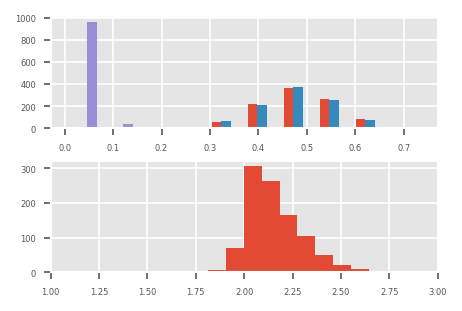

In [130]:
# Pick some equilibria vaguely with this technique
np.random.seed(667)
eqDensities_3 = np.random.dirichlet(alpha=(20,20,1), size=1000)
eqDivs_3 = D_1(eqDensities_3)


plt.figure(figsize=(3,2), dpi=150);
plt.subplot(2,1,1);
plt.hist(eqDensities_3);
# plt.legend();

# Diversity histogram centered just above 2...
plt.subplot(2,1,2);
plt.hist(eqDivs_3);
plt.xlim((1,3));
plt.tight_layout();

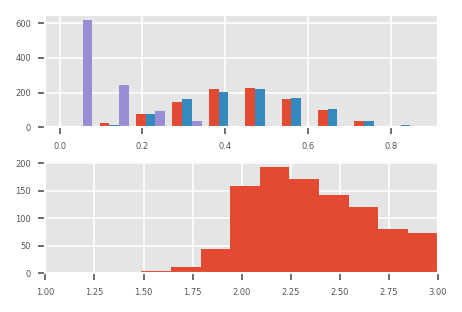

In [131]:
np.random.seed(667)
eqDensities_3_hivar = np.random.dirichlet(alpha=(5,5,1), size=1000)
eqDivs_3_hivar = D_1(eqDensities_3_hivar)

plt.figure(figsize=(3,2), dpi=150);
plt.subplot(2,1,1);
plt.hist(eqDensities_3_hivar);
# plt.legend();

plt.subplot(2,1,2);
plt.hist(eqDivs_3_hivar);
plt.xlim((1,3));
plt.tight_layout();

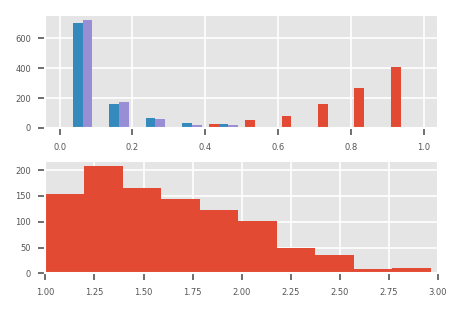

In [132]:
# Get enough low-diversity equilibria.
np.random.seed(667)
eqDensities_3_lo_hivar = np.random.dirichlet(alpha=(5,0.5,0.5), size=1000)
eqDivs_3_lo_hivar = D_1(eqDensities_3_lo_hivar)

plt.figure(figsize=(3,2), dpi=150);
plt.subplot(2,1,1);
plt.hist(eqDensities_3_lo_hivar);
# plt.legend();

plt.subplot(2,1,2);
plt.hist(eqDivs_3_lo_hivar);
plt.xlim((1,3));
plt.tight_layout();

In [133]:
# Repeat for Resources
np.random.seed(668)
eqDensities_3_lo_hivar_R = np.random.dirichlet(alpha=(5,0.5,0.5), size=1000)
eqDivs_3_lo_hivar_R = D_1(eqDensities_3_lo_hivar_R)

eqDensities_3_hivar_R = np.random.dirichlet(alpha=(5,5,1), size=1000)
eqDivs_3_hivar_R = D_1(eqDensities_3_hivar_R)

In [134]:
# Now concatenate the hi-variance sample with the lo-diversity sample to get sth roughly unif
eqDivs_supersamp = np.concatenate([eqDivs_3_hivar, eqDivs_3_lo_hivar])
eqDensities_supersamp = np.concatenate([eqDensities_3_hivar, eqDensities_3_lo_hivar])

In [135]:
eqDivs_supersamp_R = np.concatenate([eqDivs_3_hivar_R, eqDivs_3_lo_hivar_R])
eqDensities_supersamp_R = np.concatenate([eqDensities_3_hivar_R, eqDensities_3_lo_hivar_R])

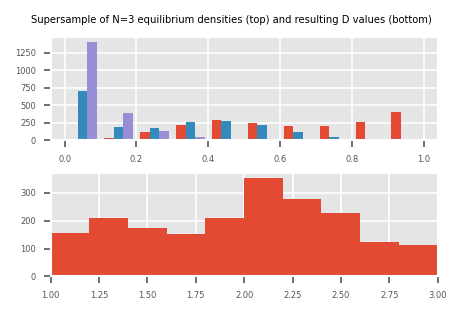

In [136]:
# Plotting supersample of EQ densities and the resulting D values. Now, need to thin for uniformity.
plt.figure(figsize=(3,2), dpi=150);
plt.subplot(2,1,1);
plt.hist(eqDensities_supersamp);
# plt.legend();

plt.subplot(2,1,2);
plt.hist(eqDivs_supersamp);
plt.xlim((1,3));

plt.suptitle('Supersample of N=3 equilibrium densities (top) and resulting D values (bottom)');
plt.tight_layout();

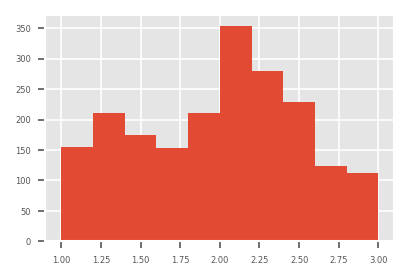

In [137]:
# Now, remove ~1000 elements such that the mohawk is removed, uniformity somewhat satisfied.
# How to remove from only the most populated bins?
# Start by getting the bins from the above histogram.
    # Then, weed out values at random from overrepresented bins.
plt.figure(figsize=(3,2), dpi=150);
(counts, bins, patches) = plt.hist(eqDivs_supersamp, bins=np.linspace(1,3,11))

plt.show();

In [138]:
bins_3_C0 = np.array(bins)

In [139]:
digs = np.digitize(eqDivs_supersamp, bins)

In [140]:
digs_R = np.digitize(eqDivs_supersamp_R, bins)

In [141]:
# fine, for loop
eqDensities_subsamp = np.zeros((1000,3))
eqDivs_subsamp = np.zeros(1000)
for i in range(1,11):
    # print(i)
    eqDensities_subsamp[100*(i-1):100*(i)] = (eqDensities_supersamp[i==digs][:100])
    eqDivs_subsamp[100*(i-1):100*(i)] = (eqDivs_supersamp[i==digs][:100])

In [142]:
eqDensities_subsamp_R = np.zeros((1000,3))
eqDivs_subsamp_R = np.zeros(1000)
for i in range(1,11):
    # print(i)
    eqDensities_subsamp_R[100*(i-1):100*(i)] = (eqDensities_supersamp_R[i==digs_R][:100])
    eqDivs_subsamp_R[100*(i-1):100*(i)] = (eqDivs_supersamp_R[i==digs_R][:100])
    

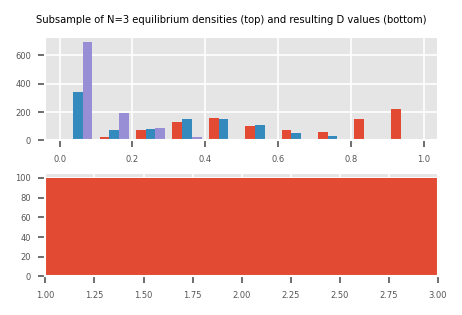

In [143]:
plt.figure(figsize=(3,2), dpi=150);
plt.subplot(2,1,1);
plt.hist(eqDensities_subsamp);
# plt.legend();

plt.subplot(2,1,2);
# plt.hist(eqDivs_supersamp);


# plt.figure(figsize=(3,2), dpi=150);
counts_sub, bins_sub, patches_sub = plt.hist(eqDivs_subsamp, bins=bins_3_C0);
plt.suptitle("Subsample of N=3 equilibrium densities (top) and resulting D values (bottom)");
plt.xlim((1,3));
plt.tight_layout();

plt.show();

In [144]:
eqDensities_3_subsamp = eqDensities_subsamp.copy().reshape(1000,3,1)
eqDivs_3_subsamp = eqDivs_subsamp.copy()

In [145]:
# Also need resource densities, but their distribution doesn't matter, does it?
## Yes, it does.
np.random.seed(667)
eqDensities_3_R = np.random.uniform(0,1,(1000,3,1))


In [146]:
J_3_C0 = community_matr_gen_noP(n_=3, k_=1000, C_=np.eye(3), eps_=0.25, R_star_=eqDensities_3_R, S_star_=eqDensities_3_subsamp)


In [147]:
J_3_C0_fixed = community_matr_gen_noP(n_=3, k_=1000, C_=np.eye(3), eps_=0.25, R_star_=eqDensities_subsamp_R, S_star_=eqDensities_3_subsamp)


In [148]:
unifD_3_R_0 = init_res(J_3_C0)
unifD_3_R_inf = asym_res(J_3_C0)
unifD_3_I_S = np.zeros(1000)
for i in range(1000):
    unifD_3_I_S[i] = stoch_invar(J_3_C0[i,:,:])
unifD_3_I_D = np.zeros(1000)
for i in range(1000):
    unifD_3_I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(J_3_C0[i,:,:]), method='brent').fun


In [149]:
unifD_3_R_0_fixed = init_res(J_3_C0_fixed)
unifD_3_R_inf_fixed = asym_res(J_3_C0_fixed)
unifD_3_I_S_fixed = np.zeros(1000)
for i in range(1000):
    unifD_3_I_S_fixed[i] = stoch_invar(J_3_C0_fixed[i,:,:])
unifD_3_I_D_fixed = np.zeros(1000)
for i in range(1000):
    unifD_3_I_D_fixed[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(J_3_C0_fixed[i,:,:]), method='brent').fun


In [150]:
print("All systems stable? ", np.all(eigvals(J_3_C0).real<0))

All systems stable?  True


In [151]:
print("All systems stable? ", np.all(eigvals(J_3_C0_fixed).real<0))

All systems stable?  True


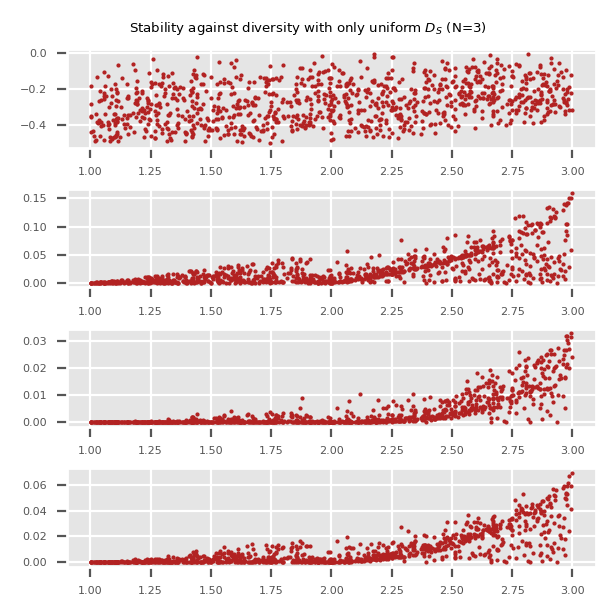

In [152]:
plt.figure(figsize=(3,3), dpi=200);
plt.subplot(4,1,1);
plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_R_0, s=1, color='firebrick');
plt.subplot(4,1,2);
plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_R_inf, s=1, color='firebrick');
plt.subplot(4,1,3);
plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_I_S, s=1, color='firebrick');
plt.subplot(4,1,4);
plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_I_D, s=1, color='firebrick');
plt.suptitle("Stability against diversity with only uniform $D_{S}$ (N=3)");
plt.tight_layout();

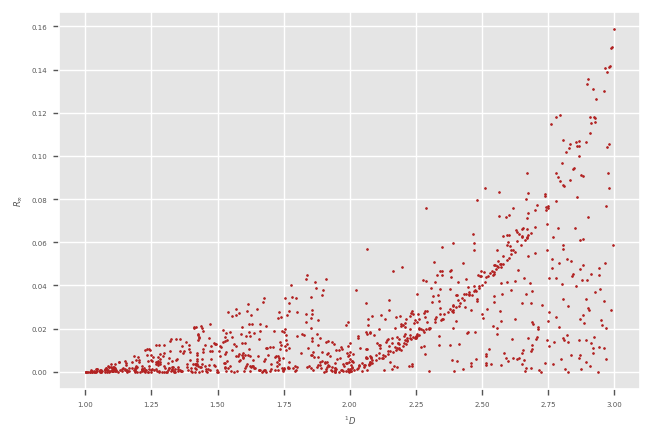

In [153]:
# PECULIAR CURVE. DO YOU SEE IT, TOO?
plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_R_inf, s=1, color='firebrick');
plt.ylabel(r'$R_{\infty}$');
plt.xlabel(r'$^1D$');

In [154]:
# plt.figure(figsize=(4,4), dpi=250);
# plt.subplot(4,1,1);
# plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_R_0_fixed, s=1, color='salmon');
# plt.tick_params('x', which='both', bottom=False, labelbottom=False);
# plt.ylabel(r'$\mathcal{R}_{0}$');

# plt.subplot(4,1,2);
# plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_R_inf_fixed, s=1, color='salmon');
# plt.tick_params('x', which='both', bottom=False, labelbottom=False);
# plt.ylabel(r'$\mathcal{R}_{\infty}$');

# plt.subplot(4,1,3);
# plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_I_S_fixed, s=1, color='salmon');
# plt.tick_params('x', which='both', bottom=False, labelbottom=False);
# plt.ylabel(r'$\mathcal{I}_{S}$');

# plt.subplot(4,1,4);
# plt.scatter(x=eqDivs_3_subsamp, y=unifD_3_I_D_fixed, s=1, color='salmon');
# plt.ylabel(r'$\mathcal{I}_{D}$');

# plt.suptitle("Stability against diversity with uniform $D_S$ and $D_R$ (N=3)\nPRELIMINARY/TEST");
# plt.tight_layout();
# # plt.savefig('./graphics/fixed_OD/OD3_C0_unifD.pdf');

In [155]:
# # Look at the mu/rho that resulted from this choice of EQ
# blankones = np.ones((1000,3,3))
# unifD_3_mu = dot_across(np.dot(0.25 * np.eye(3), np.transpose(np.eye(3))) * blankones, eqDensities_3_R)
# unifD_3_rho = dot_across(dot_across(np.eye(3)*eqDensities_3_R, np.eye(3)*blankones), eqDensities_3_subsamp)

# plt.figure(figsize=(4,4), dpi=150);
# plt.subplot(2,1,1);
# plt.hist(unifD_3_mu.reshape(1000,-1));
# plt.title(r'$\mu$');
# plt.subplot(2,1,2);
# plt.title(r'$\rho$');
# plt.hist(unifD_3_rho.reshape(1000,-1));
# plt.tight_layout();

##### build_a_sys()

In [156]:
def build_a_sys(n, k, ksuper1, ksuper2, alpha1_hi, alphas2, tune, C, seed):
    (eqDensities, eqDivs, bins) = uniform_D(n=n, k=ksuper1, alpha1_hi=alpha1_hi, alpha2_hi=alphas2[1], alpha2_lo=alphas2[0], tune=tune, seed_=seed)

    (eqDensities_R, eqDivs_R, bins_R) = uniform_D(n=n, k=ksuper2, alpha1_hi=alpha1_hi, alpha2_hi=alphas2[1], alpha2_lo=alphas2[0], tune=tune, seed_=seed+1)

    OD_out = ODsystem_unifD(n_=n, R_star=eqDensities_R.reshape(k,n,1), S_star=eqDensities.reshape(k,n,1), C_=C)

    return OD_out

##### N=2

In [157]:
# # N=2
# OD2_C0_unifD = build_a_sys(n=2, k=1000, ksuper1=10000, ksuper2=10000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=np.eye(2), seed=667)


In [158]:
np.all(eigvals(OD2_C0_unifD.J).real < 0)

True

In [159]:
lwr_idx = OD2_C0_unifD.R_0<-0.15
upr_idx = OD2_C0_unifD.R_0>-0.15

r0_lwr = OD2_C0_unifD.J[OD2_C0_unifD.R_0<-0.15]
r0_upr = OD2_C0_unifD.J[OD2_C0_unifD.R_0>-0.15]

In [160]:
np.mean(eigvals(r0_lwr).real)

-0.25

In [161]:
np.mean(eigvals(r0_lwr).imag)
np.max(eigvals(r0_lwr).imag) == -np.min(eigvals(r0_lwr).imag)

0.0

True

In [162]:
np.mean(eigvals(r0_upr).imag)
np.max(eigvals(r0_upr).imag) == -np.min(eigvals(r0_upr).imag)

0.0

True

In [163]:
eigvals(r0_lwr).shape

(458, 4)

In [164]:
temp = np.polyfit(OD2_C0_unifD.D_s[lwr_idx].flatten(), init_res((r0_lwr)).flatten(), deg=1)

In [165]:
temp

array([ 0.3707494, -0.8937405])

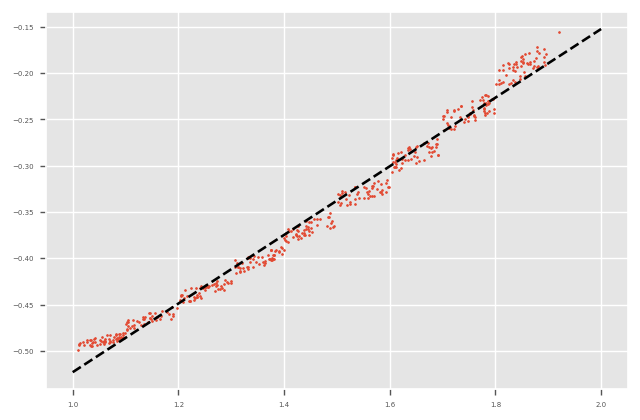

In [166]:
plt.scatter(OD2_C0_unifD.D_s[lwr_idx], init_res((r0_lwr)), s=1);
plt.plot(np.linspace(1,2,100), temp[0]*np.linspace(1,2,100)+temp[1], c='k', linestyle='--');

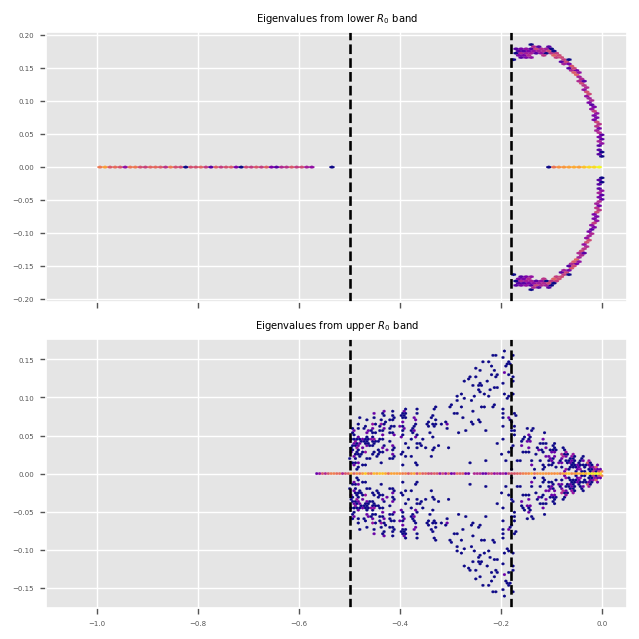

In [167]:
fig, ax = plt.subplots(2, 1, figsize=(5,5), sharex=True, constrained_layout=True)
# fig.tight_layout()


# plt.subplots(2,1,1, figsize=(3,3));
cmap = mpl.cm.get_cmap("plasma").copy()
cmap.set_under(color = 'white', alpha = 0) 
ax[0].set_title("Eigenvalues from lower $R_0$ band");
ax[0].hexbin(eigvals(r0_lwr).real, eigvals(r0_lwr).imag, bins='log', cmap=cmap, linewidths=0.1);
ax[0].axvline(-0.18, linestyle='--', c='k');
ax[0].axvline(np.min(OD2_C0_unifD.R_0), linestyle='--', c='k');

plt.xlim((-1.1,0.05));
# pc = ax[0].pcolormesh(Z, norm=colors.CenteredNorm(), cmap=cmap)
# ax[0].set_clim(10**(-8), 5) ### color limits, increase upper for better contrast



# plt.subplots(2,1,2, figsize=(3,3));
# cmap = mpl.cm.get_cmap("plasma").copy()
# cmap.set_under(color = 'white', alpha = 0) 
ax[1].set_title("Eigenvalues from upper $R_0$ band");
ax[1].hexbin(eigvals(r0_upr).real, eigvals(r0_upr).imag,  bins='log', cmap=cmap, linewidths=0.1);
ax[1].axvline(-0.18, linestyle='--', c='k');
ax[1].axvline(np.min(OD2_C0_unifD.R_0), linestyle='--', c='k');

plt.xlim((-1.1,0.05));
# plt.tight_layout();

In [168]:
np.min(OD2_C0_unifD.R_0)
# np.max(OD2_C0_unifD.R_0)

-0.498926912302974

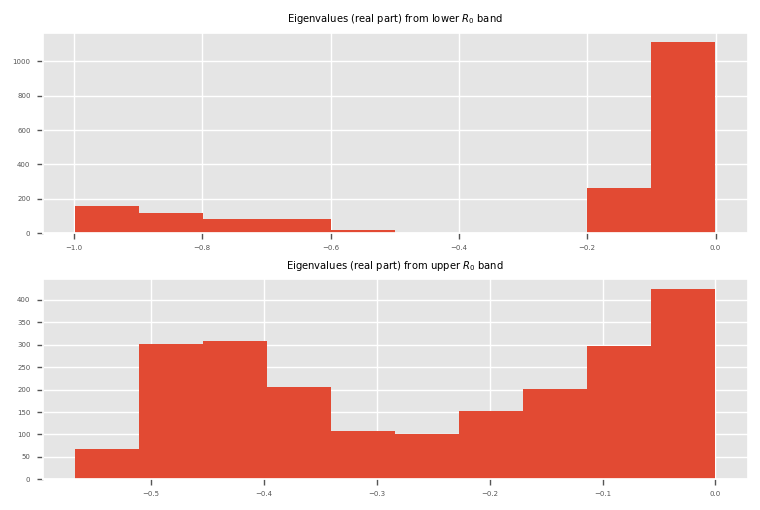

In [169]:
plt.subplot(2,1,1);
plt.title("Eigenvalues (real part) from lower $R_0$ band");
plt.hist(eigvals(r0_lwr).real.flatten());
plt.subplot(2,1,2);
plt.title("Eigenvalues (real part) from upper $R_0$ band");
plt.hist(eigvals(r0_upr).real.flatten());
plt.tight_layout();

In [170]:
# OD_stab_div_plot(OD2_C0_unifD, fsize=(4,4), div_idx_=[5], title="Strict Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD2_C0_unifD')


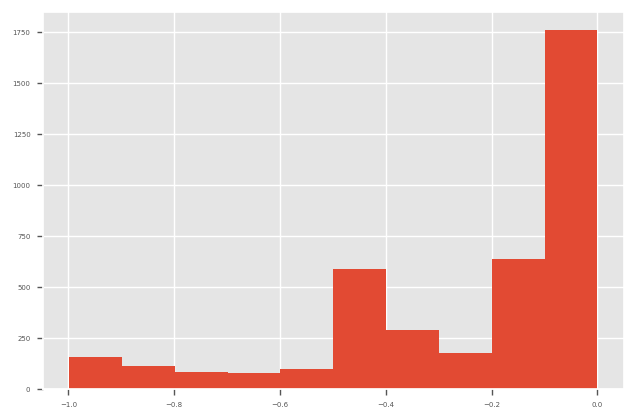

In [171]:
plt.hist(eigvals(OD2_C0_unifD.J).real.flatten());

In [172]:
np.sum(eigvals(OD2_C0_unifD.J).real, axis=1)[0].round(3)

-1.0

C:\Users\riley\anaconda3\lib\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\Users\riley\AppData\Roaming\Python\Python39\site-packages\matplotlib\transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


(array([195., 138.,  94.,  54.,  31.,  23.,  48., 104., 125., 188.]),
 array([-1.0610723+0.j, -1.0565853+0.j, -1.0520982+0.j, -1.0476112+0.j,
        -1.0431242+0.j, -1.0386372+0.j, -1.0341502+0.j, -1.0296631+0.j,
        -1.0251761+0.j, -1.0206891+0.j, -1.0162021+0.j]),
 <BarContainer object of 10 artists>)

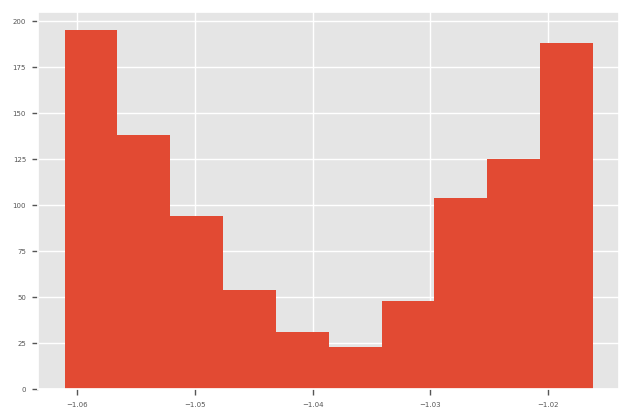

In [173]:
plt.hist(np.sum(eigvals(OD2_CL1_unifD.J), axis=1))

In [174]:
np.mean(eigvals(OD2_C0_unifD.J).real, axis=0)
# np.sum(eigvals(OD2_C0_unifD.J).real, axis=1) # ALL -1? Wow

array([-0.3541323, -0.1528546, -0.3504511, -0.142562 ])

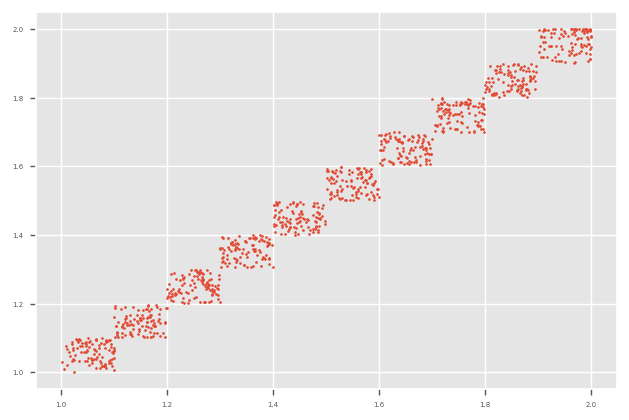

In [175]:
plt.scatter(OD2_C0_unifD.D_R.flatten(), OD2_C0_unifD.D_S.flatten(), s=1);

In [176]:
OD2_C0_unifD.S_star[lwr_idx][3] # True if S1 is greater than S2

array([[0.0116553],
       [0.9883447]])

In [177]:
np.any((np.diff(OD2_C0_unifD.S_star[lwr_idx][:], axis=1) < 0).flatten() == (np.diff(OD2_C0_unifD.R_star[lwr_idx][:], axis=1) < 0).flatten())


False

In [178]:
# np.all((np.diff(OD2_C0_unifD.S_star[upr_idx][idx], axis=0)<0).flatten() == (np.diff(OD2_C0_unifD.R_star[upr_idx][idx], axis=0)<0).flatten())

In [179]:
# Exact match. Hmmm.
np.diag(np.dot(-OD2_C0_unifD.C, OD2_C0_unifD.S_star[lwr_idx][2]).flatten())
-np.dot(np.diag(OD2_C0_unifD.R_star[lwr_idx][2].flatten()), OD2_C0_unifD.C)
0.25*np.dot(np.diag(OD2_C0_unifD.S_star[lwr_idx][2].flatten()), OD2_C0_unifD.C.T)

array([[-0.0124289,  0.       ],
       [ 0.       , -0.9875711]])

array([[-0.9889292, -0.       ],
       [-0.       , -0.0110708]])

array([[0.0031072, 0.       ],
       [0.       , 0.2468928]])

##### N=5

In [180]:
np.random.seed(667)
eqDensities_5_hivar = np.random.dirichlet(alpha=(2,2,2,1,1), size=3000)
eqDivs_5_hivar = D_1(eqDensities_5_hivar)

# Get enough low-diversity equilibria.

eqDensities_5_lo_hivar = np.random.dirichlet(alpha=(5,0.5,0.5,0.5,0.5), size=3000)
eqDivs_5_lo_hivar = D_1(eqDensities_5_lo_hivar)


In [181]:
# Now concatenate the hi-variance sample with the lo-diversity sample to get sth roughly unif

eqDivs_5_supersamp = np.concatenate([eqDivs_5_hivar, eqDivs_5_lo_hivar])

eqDensities_5_supersamp = np.concatenate([eqDensities_5_hivar, eqDensities_5_lo_hivar])

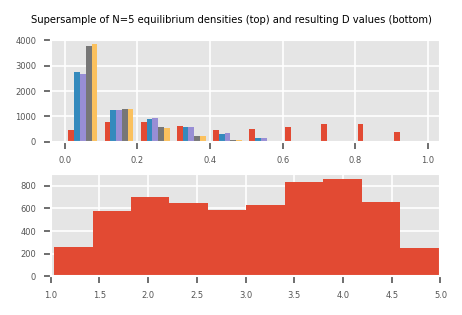

In [182]:
# Plotting supersample of EQ densities and the resulting D values. Now, need to thin for uniformity.
plt.figure(figsize=(3,2), dpi=150);
plt.subplot(2,1,1);
plt.hist(eqDensities_5_supersamp);
# plt.legend();

plt.subplot(2,1,2);
plt.hist(eqDivs_5_supersamp);
plt.xlim((1,5));

plt.suptitle('Supersample of N=5 equilibrium densities (top) and resulting D values (bottom)');
plt.tight_layout();

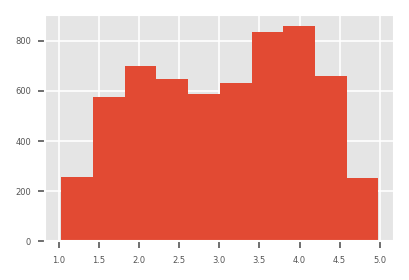

In [183]:
# Now, remove ~1000 elements such that the mohawk is removed, somewhat uniform.
# How to remove from only the most populated bins?
# Start by getting the bins from the above histogram.
    # Then, weed out values at random from overrepresented bins.
plt.figure(figsize=(3,2), dpi=150);
(counts, bins, patches) = plt.hist(eqDivs_5_supersamp)

plt.show();

In [184]:
bins = np.array(bins)

digs_5 = np.digitize(eqDivs_5_supersamp, bins)

In [185]:
eqDensities_5_subsamp = np.zeros((1000,5))
eqDivs_5_subsamp = np.zeros(1000)
for i in range(1,11):
    # print(i)
    eqDensities_5_subsamp[100*(i-1):100*(i)] = (eqDensities_5_supersamp[i==digs_5][:100])
    eqDivs_5_subsamp[100*(i-1):100*(i)] = (eqDivs_5_supersamp[i==digs_5][:100])
    
    

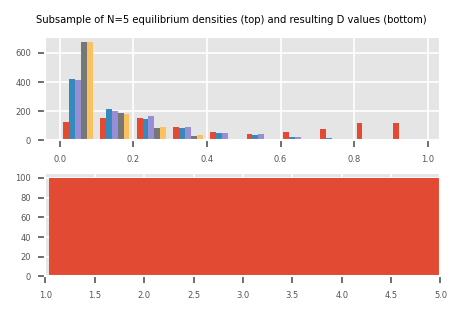

In [186]:
plt.figure(figsize=(3,2), dpi=150);
plt.subplot(2,1,1);
plt.hist(eqDensities_5_subsamp);
# plt.legend();

plt.subplot(2,1,2);
# plt.hist(eqDivs_supersamp);

# plt.figure(figsize=(3,2), dpi=150);
counts_sub, bins_sub, patches_sub = plt.hist(eqDivs_5_subsamp, bins=bins);
plt.suptitle("Subsample of N=5 equilibrium densities (top) and resulting D values (bottom)");
plt.xlim((1,5));
plt.tight_layout();

plt.show();

In [187]:
eqDensities_5_subsamp = eqDensities_5_subsamp.copy().reshape(1000,5,1)
eqDivs_5_subsamp = eqDivs_5_subsamp.copy()

In [188]:
# Also need resource densities, but their distribution doesn't matter, does it?
## OF COURSE IT MATTERS. That was the whole point of this exercise. Do not just stop at uniform D_S
np.random.seed(667)
eqDensities_5_R = np.random.uniform(0,1,(1000,5,1))
eqDensities_5_R = sum_to_one(eqDensities_5_R)



In [189]:
# sum_to_one(eqDensities_3_R)

# plt.hist(D_1(eqDensities_3_R));

In [190]:
J_5_C0 = community_matr_gen_noP(n_=5, k_=1000, C_=np.eye(5), eps_=0.25, R_star_=eqDensities_5_R, S_star_=eqDensities_5_subsamp)


In [191]:
unifD_5_R_0 = init_res(J_5_C0)
unifD_5_R_inf = asym_res(J_5_C0)
unifD_5_I_S = np.zeros(1000)
for i in range(1000):
    unifD_5_I_S[i] = stoch_invar(J_5_C0[i,:,:])
unifD_5_I_D = np.zeros(1000)
for i in range(1000):
    unifD_5_I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(J_5_C0[i,:,:]), method='brent').fun


In [192]:
print("All systems stable? ", np.all(eigvals(J_5_C0).real<0))

All systems stable?  True


In [193]:
# # Stability against Species diversity
# plt.figure(figsize=(3,3), dpi=200);
# plt.subplot(4,1,1);
# plt.scatter(x=eqDivs_5_subsamp, y=unifD_5_R_0, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{R}_0$')
# plt.subplot(4,1,2);
# plt.scatter(x=eqDivs_5_subsamp, y=unifD_5_R_inf, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{R}_{\infty}$')
# plt.subplot(4,1,3);
# plt.scatter(x=eqDivs_5_subsamp, y=unifD_5_I_S, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{I}_S$')
# plt.subplot(4,1,4);
# plt.scatter(x=eqDivs_5_subsamp, y=unifD_5_I_D, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{I}_D$')
# plt.xlabel(r'$^1D_S$')
# plt.suptitle("Stability against diversity with uniform species D (N=5)")
# plt.tight_layout();

In [194]:
# # Stability against resource diversity.
# plt.figure(figsize=(3,3), dpi=200);
# plt.subplot(4,1,1);
# plt.scatter(x=D_1(eqDensities_5_R), y=unifD_5_R_0, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{R}_0$')
# plt.subplot(4,1,2);
# plt.scatter(x=D_1(eqDensities_5_R), y=unifD_5_R_inf, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{R}_{\infty}$')
# plt.subplot(4,1,3);
# plt.scatter(x=D_1(eqDensities_5_R), y=unifD_5_I_S, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{I}_S$')
# plt.subplot(4,1,4);
# plt.scatter(x=D_1(eqDensities_5_R), y=unifD_5_I_D, s=1, color='firebrick');
# plt.ylabel(r'$\mathcal{I}_D$')
# plt.xlabel(r'$^1D_R$')
# plt.suptitle("Stability against diversity with non-uniform D_R (N=5)")
# plt.tight_layout();

In [195]:
# # OD_stab_div_plot(OD5_C0_unifD)
# OD_stab_div_plot(OD5_C0_unifD, fsize=(4,4), div_idx_=[5], title="Roughly uniform D (N=5)", 
#                  one_col = 'salmon' , s_=3, fontsize=6, lowess_frac=2./3, save_as='./graphics/fixed_OD/OD5_C0_unifD.pdf')


In [196]:
# stab_stab_plot(OD5_C0_unifD, 'firebrick', 'O\'Dwyer', 5, 'I', ', no P, fixed')

##### N=3

In [197]:
# OD_stab_div_plot(OD3_C0_unifD, fsize=(4,4), div_idx_=[5], title="Strict Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD3_C0_unifD')


In [198]:
# stab_stab_plot(OD3_CL1_unifD, 'firebrick', 'O\'Dwyer', 3, 'I', ', no P, fixed')

##### N=10

In [199]:
# OD_stab_div_plot(OD10_C0_unifD, fsize=(4,4), div_idx_=[5], title="Strict Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=0.25, save_as=r'./graphics/fixed_OD/OD10_C0_unifD')


##### N=15

In [200]:
# OD_stab_div_plot(OD15_C0_unifD, fsize=(4,4), div_idx_=[5], title="Strict Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD15_C0_unifD')


In [201]:
# OD15_C0_unifD

##### N=20 (Singular matrix errors)

In [202]:
# (eqDensities20, eqDivs20, bins20) = uniform_D(n=20, k=150000, alpha1_hi=2, alpha2_hi=2, alpha2_lo=0.1, tune=0.8)

# (eqDensities20_R, eqDivs20_R, bins20_R) = uniform_D(n=20, k=130000, alpha1_hi=2, alpha2_hi=2, alpha2_lo=0.1, tune=0.8, seed_=669)


# J_20_C0 = community_matr_gen_noP(n_=20, k_=1000, C_=np.eye(20), eps_=0.5, R_star_=eqDensities20_R.reshape(1000,20,1), S_star_=eqDensities20.reshape(1000,20,1))


# np.all(eigvals(J_20_C0).real<0)

In [203]:
# for i in range(1000):
#     # print(i)
#     stoch_invar(J_20_C0[i])
# stoch_invar(J_20_C0[10])

In [204]:
# A_temp = np.kron(J_20_C0[10], np.eye(40)) + np.kron(np.eye(40), J_20_C0[10])

In [205]:
# A_temp = np.linalg.inv(A_temp)

In [206]:
# np.linalg.norm(A_temp, ord=2)

In [207]:
# plt.scatter(x=eqDivs20, y=init_res(J_20_C0), s=1, color='salmon', alpha=0.8);
# plt.xlim((0,20));

In [208]:
# unifD_20_I_D = np.zeros(1000)
# for i in range(1000):
#     unifD_20_I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(J_20_C0[i,:,:]), method='brent').fun

In [209]:
# OD20_C0_unifD = ODsystem_unifD(n_=20, R_star=eqDensities20_R.reshape(1000,20,1), S_star=eqDensities20.reshape(1000,20,1))


In [210]:
# OD_stab_div_plot(OD20_C0_unifD, fsize=(4,4), div_idx_=[5], title="Strict Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD20_C0_unifD')


#### CL1

In [211]:
# # N=2
# OD2_CL1_unifD = build_a_sys(n=2, k=1000, ksuper1=10000, ksuper2=10000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL1[:2,:2], seed=667)


In [212]:
# plt.imshow(OD2_CL1_unifD.C);
# plt.grid(False);
OD2_CL1_unifD.C

array([[0.8060564, 0.0791914],
       [0.2550504, 0.9370096]])

In [213]:
# OD_stab_div_plot(OD2_CL1_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD2_CL1_unifD')


In [214]:
# # N=3
# OD3_CL1_unifD = build_a_sys(n=3, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL1[:3,:3], seed=999)


In [215]:
np.all(eigvals(OD3_CL1_unifD.J).real < 0)

True

In [216]:
# OD_stab_div_plot(OD3_CL1_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD3_CL1_unifD')


In [217]:
# # N=5
# OD5_CL1_unifD = build_a_sys(n=5, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL1[:5,:5], seed=100)


In [218]:
np.all(eigvals(OD5_CL1_unifD.J).real < 0)

True

In [219]:
# OD_stab_div_plot(OD5_CL1_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD5_CL1_unifD')


In [220]:
# # N=10
# OD10_CL1_unifD = build_a_sys(n=10, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL1[:10,:10], seed=150)


In [221]:
np.all(eigvals(OD10_CL1_unifD.J).real < 0)

True

In [222]:
# OD_stab_div_plot(OD10_CL1_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD10_CL1_unifD')


In [223]:
# # N=15
# OD15_CL1_unifD = build_a_sys(n=15, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=1.5, alphas2=(0.25,2), tune=0.2, C=CL1[:15,:15], seed=990)


In [224]:
np.all(eigvals(OD15_CL1_unifD.J).real < 0)

eigvals(OD15_CL1_unifD.J).real.max()

False

7.807890586342913e-18

In [225]:
# OD_stab_div_plot(OD15_CL1_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Specialist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD15_CL1_unifD')


#### CL2

In [226]:
# # N=2
# OD2_CL2_unifD = build_a_sys(n=2, k=1000, ksuper1=10000, ksuper2=10000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL2[:2,:2], seed=667)


In [227]:
np.all(eigvals(OD2_CL2_unifD.J).real < 0)

True

In [228]:
# OD_stab_div_plot(OD2_CL2_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Generalist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=0.5, save_as=r'./graphics/fixed_OD/OD2_CL2_unifD')


In [229]:
np.mean(CL2)

0.8565111816329092

In [230]:
# # N=3
# OD3_CL2_unifD = build_a_sys(n=3, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL2[:3,:3], seed=999)


In [231]:
np.all(eigvals(OD3_CL2_unifD.J).real < 0)

True

In [232]:
# OD_stab_div_plot(OD3_CL2_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Generalist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=0.5, save_as=r'./graphics/fixed_OD/OD3_CL2_unifD')


In [233]:
# plt.scatter(x = OD3_CL2_unifD.D_S, y = OD3_CL2_unifD.R_0, s=1, alpha=0.5);

In [234]:
# plt.scatter(x = OD3_CL2_unifD.D_S, y = OD3_CL2_unifD.R_inf, s=1, alpha=0.5);

In [235]:
# # N=5
# OD5_CL2_unifD = build_a_sys(n=5, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL2[:5,:5], seed=100)


In [236]:
np.all(eigvals(OD5_CL2_unifD.J).real < 0)

True

In [237]:
# OD_stab_div_plot(OD5_CL2_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Generalist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=0.5, save_as=r'./graphics/fixed_OD/OD5_CL2_unifD')


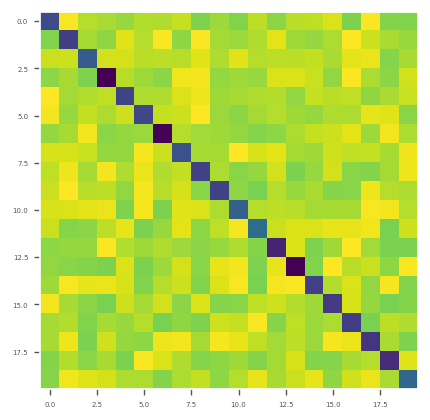

In [238]:
plt.imshow(CL2);
plt.grid(False);

In [239]:
# # N=10
# OD10_CL2_unifD = build_a_sys(n=10, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CL2[:10,:10], seed=150)


In [240]:
np.all(eigvals(OD10_CL2_unifD.J).real < 0)

True

In [241]:
# OD_stab_div_plot(OD10_CL2_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Generalist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD10_CL2_unifD')


In [242]:
# # N=15
# OD15_CL2_unifD = build_a_sys(n=15, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=1.5, alphas2=(0.25,2), tune=0.2, C=CL2[:15,:15], seed=990)


In [243]:
np.all(eigvals(OD15_CL2_unifD.J).real < 0)

eigvals(OD15_CL2_unifD.J).real.max()

False

6.545425473986456e-17

In [244]:
# OD_stab_div_plot(OD15_CL2_unifD, fsize=(4,4), div_idx_=[5], title="Noisy Generalist", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD15_CL2_unifD')


#### CR1

In [245]:
# Use the same build_a_sys() calls as above but with C swapped out. Keep same densities for sake of comparison.

In [246]:
# For this small of C, the qualitative pattern does not really matter, right?
CR1_2 = np.fromfunction(fill_near_diag, (2,2))

CR1_2[-1,0] = 0.9
CR1_2[0,-1] = 0.9

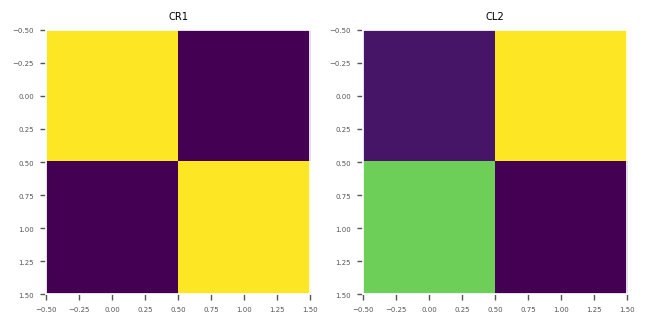

In [247]:
plt.subplot(1,2,1);
plt.imshow(CR1_2);
plt.title('CR1');
plt.grid(False);
plt.subplot(1,2,2);
plt.imshow(CL2[:2,:2]);
plt.title('CL2');
plt.grid(False);

In [248]:
# # N=2
# OD2_CR1_unifD = build_a_sys(n=2, k=1000, ksuper1=10000, ksuper2=10000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR1_2, seed=667)


In [249]:
np.all(eigvals(OD2_CR1_unifD.J).real < 0)

eigvals(OD2_CR1_unifD.J).real.max()

True

-8.296614154721459e-10

In [250]:
# OD_stab_div_plot(OD2_CR1_unifD, fsize=(4,4), div_idx_=[5], title="CR1", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD2_CR1_unifD')


In [251]:
CR1_3 = np.fromfunction(fill_near_diag, (3,3))

CR1_3[-1,0] = 0.9
CR1_3[0,-1] = 0.9

In [252]:
# # N=3
# OD3_CR1_unifD = build_a_sys(n=3, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR1_3, seed=999)


In [253]:
np.all(eigvals(OD3_CR1_unifD.J).real < 0)

eigvals(OD3_CR1_unifD.J).real.max()

True

-3.7684725086898735e-11

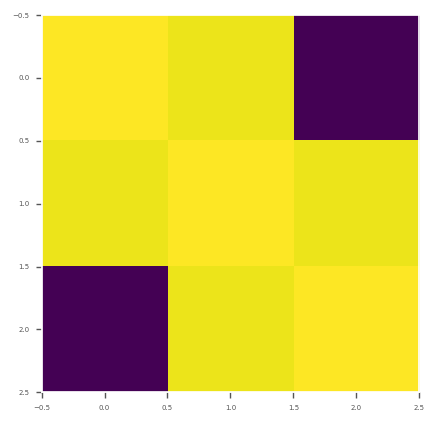

In [254]:
plt.imshow(CR1_3);
plt.grid(False);

In [255]:
# OD_stab_div_plot(OD3_CR1_unifD, fsize=(4,4), div_idx_=[5], title="CR1", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD3_CR1_unifD')


In [256]:
# stab_stab_plot(OD3_CR1_unifD, 'firebrick', 'O\'Dwyer', 3, 'CR1', ', no P, uniform D')

In [257]:
CR1_5 = np.fromfunction(fill_near_diag, (5,5))

CR1_5[-1,0] = 0.9
CR1_5[0,-1] = 0.9

In [258]:
# # N=5
# OD5_CR1_unifD = build_a_sys(n=5, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR1_5, seed=100)


In [259]:
np.all(eigvals(OD5_CR1_unifD.J).real < 0)
np.max(eigvals(OD5_CR1_unifD.J).real)

False

2.835184609468864e-17

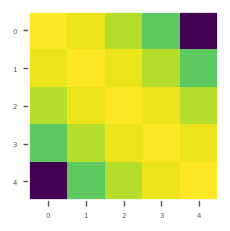

In [260]:
plt.figure(figsize=(2,2));
plt.imshow(CR1_5);
plt.grid(False);

### Scaling equilibrium to fix numerical error

In [261]:
sf = 1e16

temp=community_matr_gen_noP(n_=5, k_=1000, C_=CR1_5, eps_=0.25, R_star_=sf*OD5_CR1_unifD.R_star,S_star_=sf*OD5_CR1_unifD.S_star)


In [262]:
# np.divide(temp[0], (OD5_CR1_unifD.J[0]))

In [263]:
np.nanmin(temp / OD5_CR1_unifD.J)
np.nanmax(temp / OD5_CR1_unifD.J)

C:\Users\riley\AppData\Local\Temp/ipykernel_13768/3422632375.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmin(temp / OD5_CR1_unifD.J)


9999999999999996.0

C:\Users\riley\AppData\Local\Temp/ipykernel_13768/3422632375.py:2: RuntimeWarning: invalid value encountered in divide
  np.nanmax(temp / OD5_CR1_unifD.J)


1.0000000000000004e+16

In [264]:
np.max(np.abs((init_res(temp).flatten() / OD5_CR1_unifD.R_0.flatten()) - sf))

56.0

In [265]:
(asym_res(temp)).mean()

547.5703797546462

In [266]:
OD5_CR1_unifD.R_inf.mean()

5.4757447433790646e-14

In [267]:
# asym_res(temp)

In [268]:
tempI_S = np.zeros(1000)
for i in range(1000):
    tempI_S[i] = stoch_invar(temp[i,:,:])
            
tempI_D = np.zeros(1000)
for i in range(1000):
    tempI_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(temp[i,:,:]), method='brent').fun


In [269]:
# tempI_S

In [270]:
# OD5_CR1_unifD.I_S

In [271]:
np.mean(tempI_S / OD5_CR1_unifD.I_S)

1.0385701961669632e+16

In [272]:
np.mean(tempI_D / OD5_CR1_unifD.I_D)

9988860794558758.0

In [273]:
tempI_S.max()

tempI_S.min()

4005.7382528722724

1.780410028589008e-05

In [274]:
OD5_CR1_unifD.D_s[np.argmax(tempI_S)]
OD5_CR1_unifD.D_s[np.argmin(tempI_S)]

array([4.4879206])

array([1.3277754])

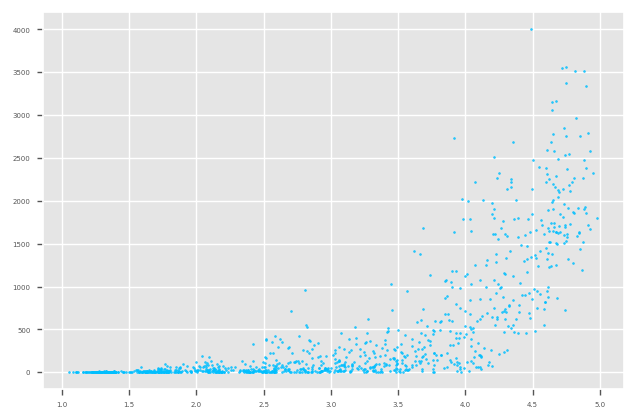

In [275]:
plt.scatter(OD5_CR1_unifD.D_s, tempI_S.flatten(), color='deepskyblue', s=1, alpha=0.75);

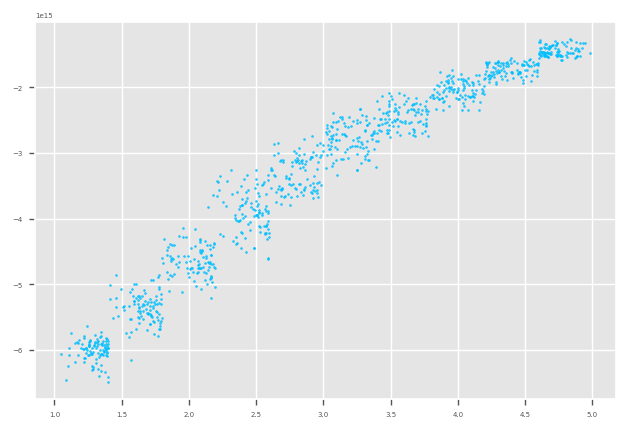

In [276]:
plt.scatter(OD5_CR1_unifD.D_s, init_res(temp).flatten(), color='deepskyblue', s=1, alpha=0.75);

In [277]:
# OD_stab_div_plot(OD5_CR1_unifD, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD5_CR1_unifD')


In [278]:
# stab_stab_plot(OD5_CR1_unifD, 'firebrick', 'O\'Dwyer', 5, 'CR1', ', no P, uniform D')

In [279]:
# plt.hexbin(x=eigvals(OD5_CR1_unifD.J).real, y=eigvals(OD5_CR1_unifD.J).imag);

In [280]:
CR1_10 = np.fromfunction(fill_near_diag, (10,10))

CR1_10[-1,0] = 0.9
CR1_10[0,-1] = 0.9

In [281]:
# # N=10
# OD10_CR1_unifD = build_a_sys(n=10, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR1_10, seed=150)


In [282]:
np.all(eigvals(OD10_CR1_unifD.J).real < 0)

False

In [283]:
# OD_stab_div_plot(OD10_CR1_unifD, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD10_CR1_unifD')


In [284]:
np.max(eigvals(OD10_CR1_unifD.J).real)

2.075265038020711e-16

In [285]:
np.mean(eigvals(OD10_CR1_unifD.J).real)

-0.4749010424636956

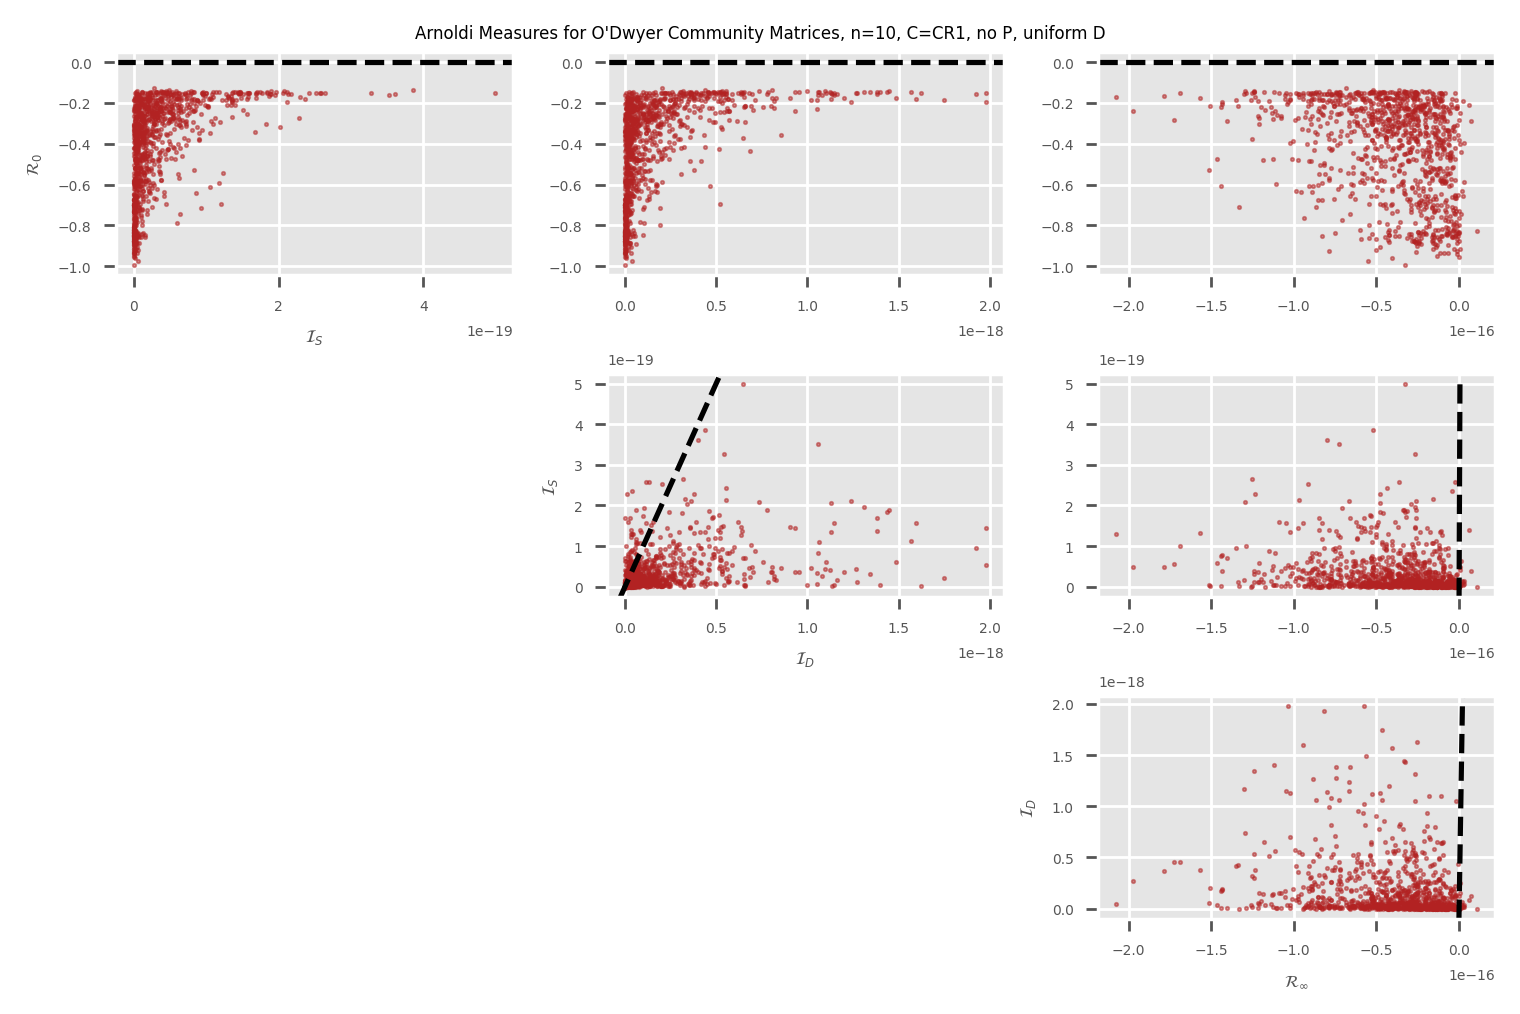

In [286]:
stab_stab_plot(OD10_CR1_unifD, 'firebrick', 'O\'Dwyer', 10, 'CR1', ', no P, uniform D')

In [287]:
CR1_15 = np.fromfunction(fill_near_diag, (15,15))

CR1_15[-1,0] = 0.9
CR1_15[0,-1] = 0.9

In [288]:
# for i in ODs_CR1:
#     print(np.mean(i.R_inf))

In [289]:
# repeat for N=11,12,13,14??? Where this R_inf trend coming from

In [290]:
# # N=15
# OD15_CR1_unifD = build_a_sys(n=15, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=1.5, alphas2=(0.25,2), tune=0.2, C=CR1_15, seed=990)


# np.max(eigvals(OD15_CR1_unifD.J).real)

# # ODs_CR1=[OD3_CR1_unifD,OD5_CR1_unifD,OD10_CR1_unifD,OD15_CR1_unifD]

# OD_stab_div_plot(OD15_CR1_unifD, fsize=(4,4), div_idx_=[5], title="Gaussian-ish Consumer matrix kernel (N=15)", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD15_CR1_unifD')


#### CR2

In [291]:
CR2_2 = np.fromfunction(fill_periodic, (2,2))

CR2_3 = np.fromfunction(fill_periodic, (3,3))

CR2_5 = np.fromfunction(fill_periodic, (5,5))

CR2_10 = CR2.copy()

CR2_15 = np.fromfunction(fill_periodic, (15,15))

In [292]:
# # N=2
# OD2_CR2_unifD = build_a_sys(n=2, k=1000, ksuper1=10000, ksuper2=10000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR2_2, seed=667)


In [293]:
np.all(eigvals(OD2_CR2_unifD.J).real < 0)

eigvals(OD2_CR2_unifD.J).real.max()

True

-6.07189786550438e-11

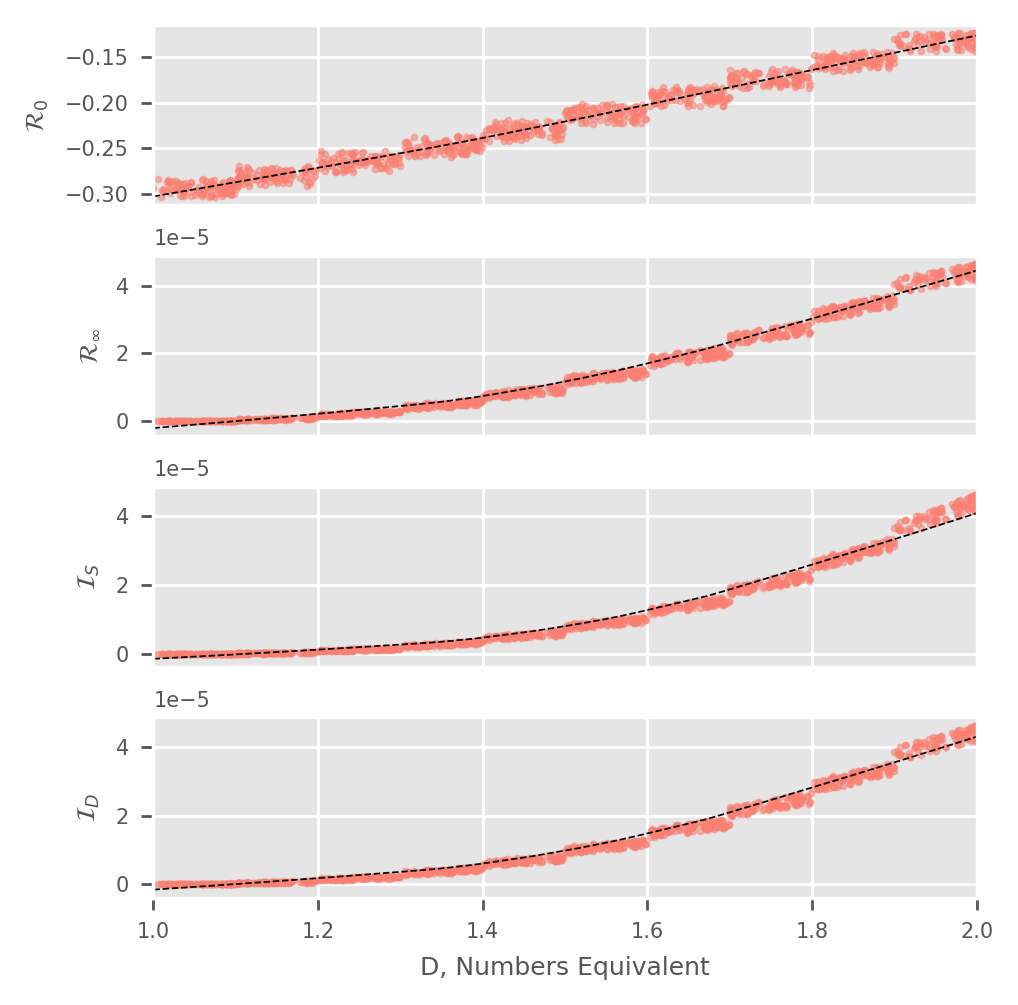

In [294]:
OD_stab_div_plot(OD2_CR2_unifD, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
                 s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD2_CR2_unifD')


In [295]:
# # N=3
# OD3_CR2_unifD = build_a_sys(n=3, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR2_3, seed=999)


In [296]:
# # N=3, C scaled down
# OD3_CR2_unifD_smallC = build_a_sys(n=3, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR2_3/10, seed=999)


In [297]:
np.all(eigvals(OD3_CR2_unifD.J).real < 0)

True

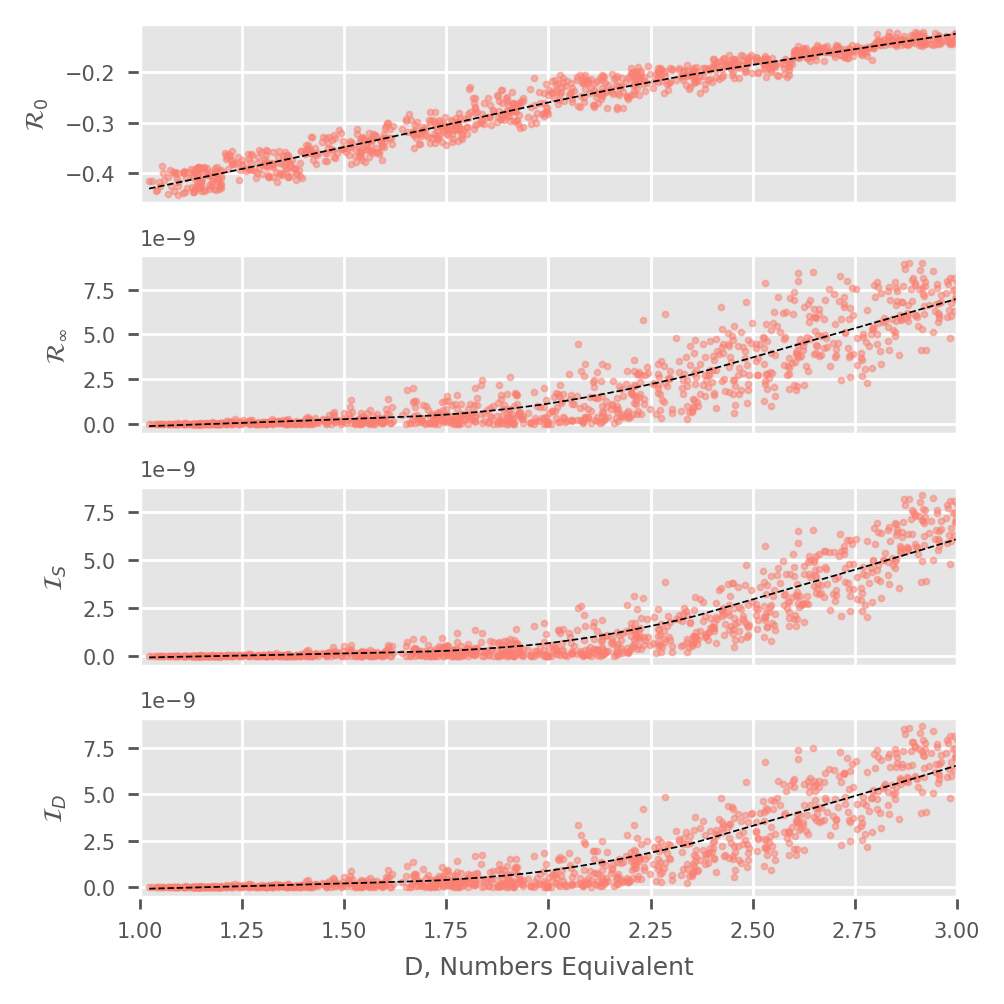

In [298]:
OD_stab_div_plot(OD3_CR2_unifD, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
                 s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD3_CR2_unifD')


In [299]:
# OD_stab_div_plot(OD3_CR2_unifD_smallC, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3)


In [300]:
# np.mean(OD3_CR2_unifD.R_0 / OD3_CR2_unifD_smallC.R_0)

In [301]:
# # N=5
# OD5_CR2_unifD = build_a_sys(n=5, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR2_5, seed=100)


In [302]:
# # N=5, C scaled up
# OD5_CR2_unifD_hugeC = build_a_sys(n=5, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR2_5*1e17, seed=100)


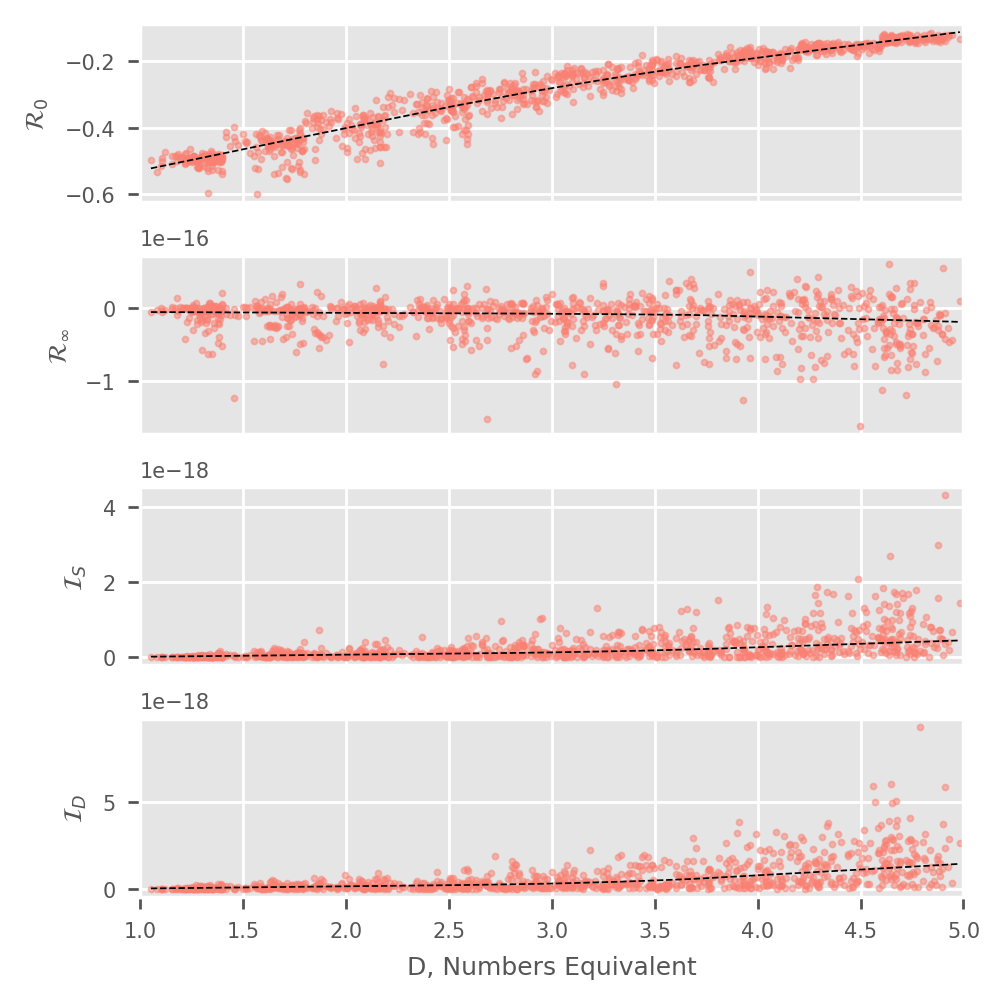

In [303]:
OD_stab_div_plot(OD5_CR2_unifD, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
                 s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD5_CR2_unifD')


In [304]:
# OD_stab_div_plot(OD5_CR2_unifD_hugeC, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3)


In [305]:
# # N=10
# OD10_CR2_unifD = build_a_sys(n=10, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=2, alphas2=(0.5,2), tune=0.2, C=CR2_10, seed=150)


In [306]:
np.all(eigvals(OD10_CR2_unifD.J).real < 0)

False

In [307]:
np.max(eigvals(OD10_CR2_unifD.J).real)

1.4699860307601919e-16

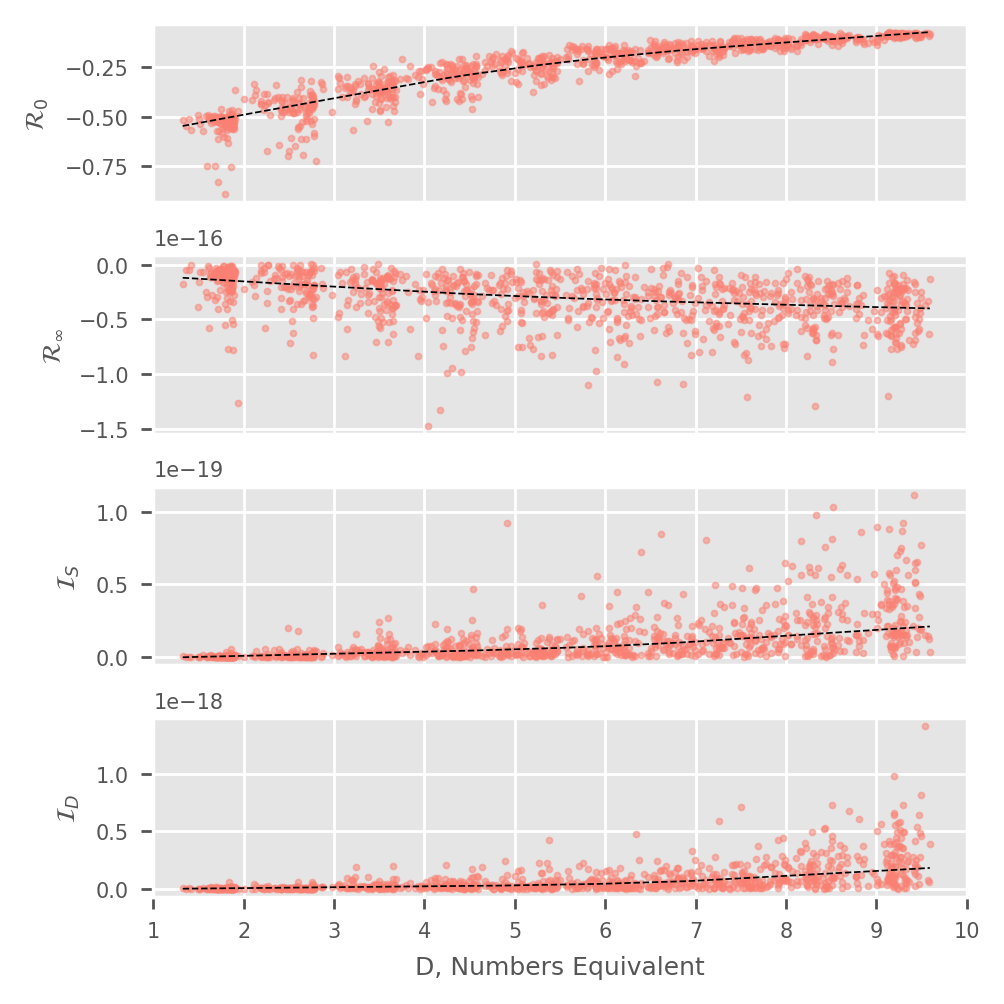

In [308]:
OD_stab_div_plot(OD10_CR2_unifD, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
                 s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD10_CR2_unifD')


In [309]:
# # N=15
# OD15_CR2_unifD = build_a_sys(n=15, k=1000, ksuper1=150000, ksuper2=150000, alpha1_hi=1.5, alphas2=(0.25,2), tune=0.2, C=CR2_15, seed=990)


# np.all(eigvals(OD15_CR2_unifD.J).real < 0)

# eigvals(OD15_CR2_unifD.J).real.max()

# OD_stab_div_plot(OD15_CR2_unifD, fsize=(4,4), div_idx_=[5], title="CR2", one_col = 'salmon', 
#                  s_=3, fontsize=6, lowess_frac=2./3, save_as=r'./graphics/fixed_OD/OD15_CR2_unifD')


### Save systems

In [310]:
C0_list  = [OD2_C0_unifD, OD3_C0_unifD, OD5_C0_unifD, OD10_C0_unifD, OD15_C0_unifD]
CL1_list = [OD2_CL1_unifD, OD3_CL1_unifD, OD5_CL1_unifD, OD10_CL1_unifD, OD15_CL1_unifD]
CL2_list = [OD2_CL2_unifD, OD3_CL2_unifD, OD5_CL2_unifD, OD10_CL2_unifD, OD15_CL2_unifD]
CR1_list = [OD2_CR1_unifD, OD3_CR1_unifD, OD5_CR1_unifD, OD10_CR1_unifD, OD15_CR1_unifD]
CR2_list = [OD2_CR2_unifD, OD3_CR2_unifD, OD5_CR2_unifD, OD10_CR2_unifD, OD15_CR2_unifD]


In [311]:
# ### Uncomment to SAVE systems ###

# # unifD_list = []
# # C_list = ['C0', 'CL1', 'CL2', 'CR1', 'CR2']
# N_list = ['2','3','5','10','15']
# for n,sys in zip(N_list,C0_list):
#     with open(r'./OD_Systems_Various_C/OD_unifD/OD{}_C0_unifD.ODsystem'.format(n), 'wb') as OD_obj_file:
#         pickle.dump(sys, OD_obj_file)

# for n,sys in zip(N_list,CL1_list):
#     with open(r'./OD_Systems_Various_C/OD_unifD/OD{}_CL1_unifD.ODsystem'.format(n), 'wb') as OD_obj_file:
#         pickle.dump(sys, OD_obj_file)
        
# for n,sys in zip(N_list,CL2_list):
#     with open(r'./OD_Systems_Various_C/OD_unifD/OD{}_CL2_unifD.ODsystem'.format(n), 'wb') as OD_obj_file:
#         pickle.dump(sys, OD_obj_file)

# for n,sys in zip(N_list,CR1_list):
#     with open(r'./OD_Systems_Various_C/OD_unifD/OD{}_CR1_unifD.ODsystem'.format(n), 'wb') as OD_obj_file:
#         pickle.dump(sys, OD_obj_file)
        
# for n,sys in zip(N_list,CR2_list):
#     with open(r'./OD_Systems_Various_C/OD_unifD/OD{}_CR2_unifD.ODsystem'.format(n), 'wb') as OD_obj_file:
#         pickle.dump(sys, OD_obj_file)


### Exponential fits to stab-div plots

\begin{align}
\ln(y) &= ax+b \\
y &= e^{ax+b} \\
y &= e^{ax}e^{b}
\end{align}


In [312]:
from scipy.optimize import curve_fit

In [313]:
# Log tf of linear
popt, pcov = curve_fit(lambda t, a, b: a*t+b, OD2_C0_unifD.D_S.flatten(), np.log(OD2_C0_unifD.R_inf.flatten()))


In [314]:
popt # [vertical scale, exponent coef] #, vertical translation]

array([ 4.0002495, -9.4021192])

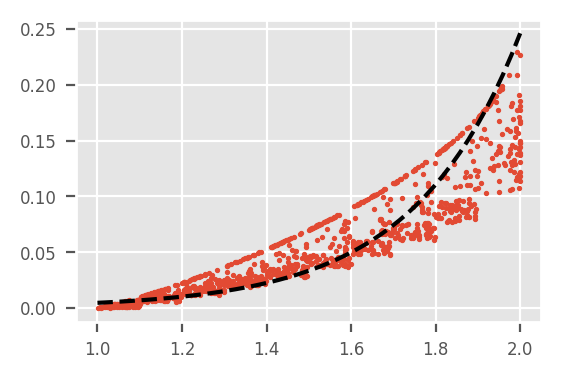

In [315]:
# Log-y linear
plt.figure(figsize=(3,2), dpi=200);
plt.scatter(x=OD2_C0_unifD.D_S.flatten(), y=OD2_C0_unifD.R_inf.flatten(), s=2);
ts = np.linspace(1,2,50)
plt.plot(ts, np.exp(popt[0] * ts) * np.exp(popt[1]), linestyle='--', color='k');

In [316]:
# Log tf of linear
popt, pcov = curve_fit(lambda t, a, b: a*t+b, OD2_C0_unifD.D_S.flatten(), np.log(OD2_C0_unifD.R_inf.flatten()))


### Rational fit stab-div

In [317]:
popt_hyp, pcov_hyp = curve_fit(lambda t, a, b, c: a/(t+b) + c, OD2_C0_unifD.D_S.flatten(), (OD2_C0_unifD.R_inf.flatten()), p0=(-0.1, -2.3, -0.0075))


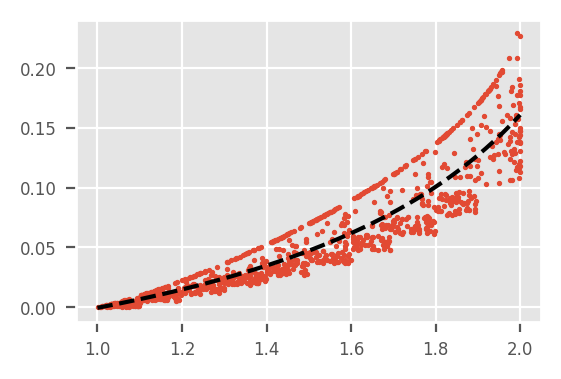

In [318]:
# Rational, x translation makes it nonlinear
plt.figure(figsize=(3,2), dpi=200);
plt.scatter(x=OD2_C0_unifD.D_S.flatten(), y=OD2_C0_unifD.R_inf.flatten(), s=2);
ts = np.linspace(1,2,50)
plt.plot(ts, popt_hyp[0]/(ts + popt_hyp[1]) + popt_hyp[2], linestyle='--', color='k');

In [319]:
OD2_C0_R_inf_SSR = np.sum(np.square(popt_hyp[0]/(OD2_C0_unifD.D_S.flatten() + popt_hyp[1]) + popt_hyp[2] - OD2_C0_unifD.R_inf.flatten()))
# OD2_C0_R_inf_SSR

OD2_C0_R_inf_SST = np.sum(np.square(popt_hyp[0]/(OD2_C0_unifD.D_S.flatten() + popt_hyp[1]) + popt_hyp[2] - np.mean(OD2_C0_unifD.R_inf.flatten())))


1 - (OD2_C0_R_inf_SSR/OD2_C0_R_inf_SST)

0.8306886362667733

In [320]:
popt_hyp

array([-0.2023104, -2.7259906, -0.117738 ])

### OD phase planes / MSE over return

In [321]:
def OD_eqns(N, t, C, eps, mu, rho):
    n = N.size // 2
    N = N.reshape(-1,1)
    # N[:n], R
    # N[n:], S
    Rprimes = rho - N[:n] * np.dot(C, N[n:]) # np.transpose(np.dot(C, S), (1,0,2))
    Sprimes = eps * N[n:] * np.dot(C.T, N[:n]) - mu * N[n:] # np.transpose(np.dot(C.T, R), (1,0,2)) - mu * S
    return np.concatenate((Rprimes, Sprimes), axis=0).flatten()

In [442]:
def OD_eqns_alt(t, N, C, eps, mu, rho): # Args must be 'time' before 'N' for solve_ivp
    n = N.size // 2
    N = N.flatten()
    Nout = np.zeros((N.size))
    Nout[:n] = (rho - N[:n].reshape(n,1) * np.dot(C, N[n:].reshape(n,1))).flatten() # np.transpose(np.dot(C, S), (1,0,2))
    Nout[n:] = (eps * N[n:].reshape(n,1) * np.dot(C.T, N[:n].reshape(n,1)) - mu * N[n:].reshape(n,1)).flatten() # np.transpose(np.dot(C.T, R), (1,0,2)) - mu * S
    return Nout

In [443]:
# # All events trigger at their ZEROS. Just translate down by desired cutoff threshold.
# def mse_settle(t, y, a,b,c,d): return y - 0.001 # NO, need sth like `mse-0.001`
# mse_settle.terminal=True
# mse_settle.direction=-1

In [457]:
OD_list = [OD2_C0_unifD, OD5_C0_unifD, OD10_C0_unifD,
            OD2_CL1_unifD,OD5_CL1_unifD,OD10_CL1_unifD,
            OD2_CL2_unifD,OD5_CL2_unifD,OD10_CL2_unifD,
            OD2_CR1_unifD,OD5_CR1_unifD,OD10_CR1_unifD,
            OD2_CR2_unifD,OD5_CR2_unifD,OD10_CR2_unifD]

In [396]:
from scipy.integrate import solve_ivp

In [498]:
temp = None

In [503]:
temp=="dink"

False

In [537]:
# Backup
def OD_MSE_sim_plot(sys, time, stab_measure, num_perts, time_fast=None, print_plots=True, seed=2, titles=True):
    stab_min_idx = np.argmin(getattr(sys, stab_measure))
    stab_min = (getattr(sys, stab_measure))[stab_min_idx]
    
    stab_max_idx = np.argmax(getattr(sys, stab_measure))
    stab_max = (getattr(sys, stab_measure))[stab_max_idx]
    
    eq_min = np.concatenate([sys.R_star[stab_min_idx],sys.S_star[stab_min_idx]])
    eq_max = np.concatenate([sys.R_star[stab_max_idx],sys.S_star[stab_max_idx]])
    
    if upto_fast==None:
        upto_fast = time
    
    plt.subplot(2,1,1); # Only max plot, then min plot and max plot
    np.random.seed(2)
    for i in range(num_perts):
        u = np.random.uniform(-1,1,(int(sys.n*2),1))
        ic_max = eq_max + 0.1*u/np.linalg.norm(u)
        ic_max=np.abs(ic_max.flatten())

        sol_max = solve_ivp(OD_eqns_alt, t_span=time,  y0=ic_max, args=(sys.C, sys.eps, sys.mu[stab_max_idx], sys.rho[stab_max_idx]), 
                               dense_output=True, method='LSODA', vectorized=True)

        mse_max = np.mean(np.square(sol_max.y - eq_max), axis=0)
        
        _=plt.plot(sol_max.t[:], mse_max[:], alpha=0.05, color='firebrick');
        
    plt.ylabel("MSE");
    plt.tick_params(axis='both',  bottom=False,labelbottom=False);
    if titles:
        plt.title("MSE over return for maximal {} (N={})".format(stab_measure, sys.n));
    
    plt.subplot(2,1,2);
    np.random.seed(2)
    for i in range(num_perts):
        u = np.random.uniform(-1,1,(int(sys.n*2),1))
        ic_min = eq_min + 0.1*u/np.linalg.norm(u)
        ic_min=np.abs(ic_min.flatten())

        sol_min = solve_ivp(OD_eqns_alt, t_span=time,  y0=ic_min, args=(sys.C, sys.eps, sys.mu[stab_min_idx], sys.rho[stab_min_idx]), 
                               dense_output=True, method='LSODA', vectorized=True)

        mse_min = np.mean(np.square(sol_min.y - eq_min), axis=0)

        
        _=plt.plot(sol_min.t[:], mse_min[:], alpha=0.05, color='deepskyblue');
        
    plt.ylabel("MSE");
    if titles:
        plt.title("MSE over return for minimal {} (N={})".format(stab_measure, sys.n));
        
        
    plt.xlabel("Time");
    plt.tight_layout();
    plt.show();
    
    return [sol_min, mse_min, sol_max, mse_max]

In [608]:
# NB: Only considering 2 systems, probably 100 perturbations

# Will simulate the min/max systems of chosen stab measure, plot them, return solution
def OD_MSE_sim_plot(sys, time, stab_measure, num_perts, pert_frac=0.1, time_fast=None, steps_fast=1000, print_plots=True, seed=2, titles=True):
    stab_min_idx = np.argmin(getattr(sys, stab_measure))
    stab_min = (getattr(sys, stab_measure))[stab_min_idx]
    
    stab_max_idx = np.argmax(getattr(sys, stab_measure))
    stab_max = (getattr(sys, stab_measure))[stab_max_idx]
    
    eq_min = np.concatenate([sys.R_star[stab_min_idx],sys.S_star[stab_min_idx]])
    eq_max = np.concatenate([sys.R_star[stab_max_idx],sys.S_star[stab_max_idx]])
    
    if time_fast==None:
        time_fast = time
    
    sols_min = [None]*num_perts
    mses_min = [None]*num_perts
    sols_max = [None]*num_perts
    mses_max = [None]*num_perts
    

    plt.subplot(2,1,2); # Only max plot, then min plot and max plot
    np.random.seed(2)
    for i in range(num_perts):
        u = np.random.uniform(-1,1,(int(sys.n*2),1))
        
        ### MAX stability
        ic_max = eq_max + pert_frac*u/np.linalg.norm(u)
        ic_max=np.abs(ic_max.flatten())

        sol_max = solve_ivp(OD_eqns_alt, t_span=time,  y0=ic_max, args=(sys.C, sys.eps, sys.mu[stab_max_idx], sys.rho[stab_max_idx]), 
                               dense_output=True, method='LSODA', vectorized=True)
        mse_max = np.mean(np.square(sol_max.y - eq_max), axis=0)
        _=plt.plot(sol_max.t[:], mse_max[:], alpha=0.05, color='firebrick');
        
        ### MIN stability
        ic_min = eq_min + pert_frac*u/np.linalg.norm(u)
        ic_min=np.abs(ic_min.flatten())

        sol_min = solve_ivp(OD_eqns_alt, t_span=time,  y0=ic_min, args=(sys.C, sys.eps, sys.mu[stab_min_idx], sys.rho[stab_min_idx]), 
                               dense_output=True, method='LSODA', vectorized=True)
        mse_min = np.mean(np.square(sol_min.y - eq_min), axis=0)
        _=plt.plot(sol_min.t[:], mse_min[:], alpha=0.05, color='deepskyblue');
        
        
        sols_min[i] = sol_min
        mses_min[i] = mse_min
        sols_max[i] = sol_max
        mses_max[i] = mse_max
        
    plt.xlabel("Time");
    plt.ylabel("MSE");
    # plt.tick_params(axis='both',  bottom=False,labelbottom=False);
    if titles:
        plt.title("MSE over return for minimal and maximal {} (N={})".format(stab_measure, sys.n));
    
    
    plt.subplot(2,1,1);
    np.random.seed(2)
    for i in range(num_perts):
        # u = np.random.uniform(-1,1,(int(sys.n*2),1))
        t_fast = np.linspace(time_fast[0],time_fast[1], steps_fast)
        sol_max = sols_max[i].sol(t_fast)
        mse_max = np.mean(np.square(sol_max-eq_max), axis=0)
        _=plt.plot(t_fast, mse_max, alpha=0.05, color='firebrick');
        
    plt.ylabel("MSE");
    if titles:
        plt.title("MSE over return for maximal {} (N={})".format(stab_measure, sys.n));
        
    
    plt.tight_layout();
    plt.subplots_adjust(hspace=0.35)
    plt.show();
    
    return [sols_min, mses_min, sols_max, mses_max]

In [609]:
# Do the full time plot first (calc'd and plotted together in same for loop)
    # Put them on subplot 2

# Another for loop doing to recalcs for smaller time scale for MAX in subplot 1


### OR just compile MSEs as you go in one big array

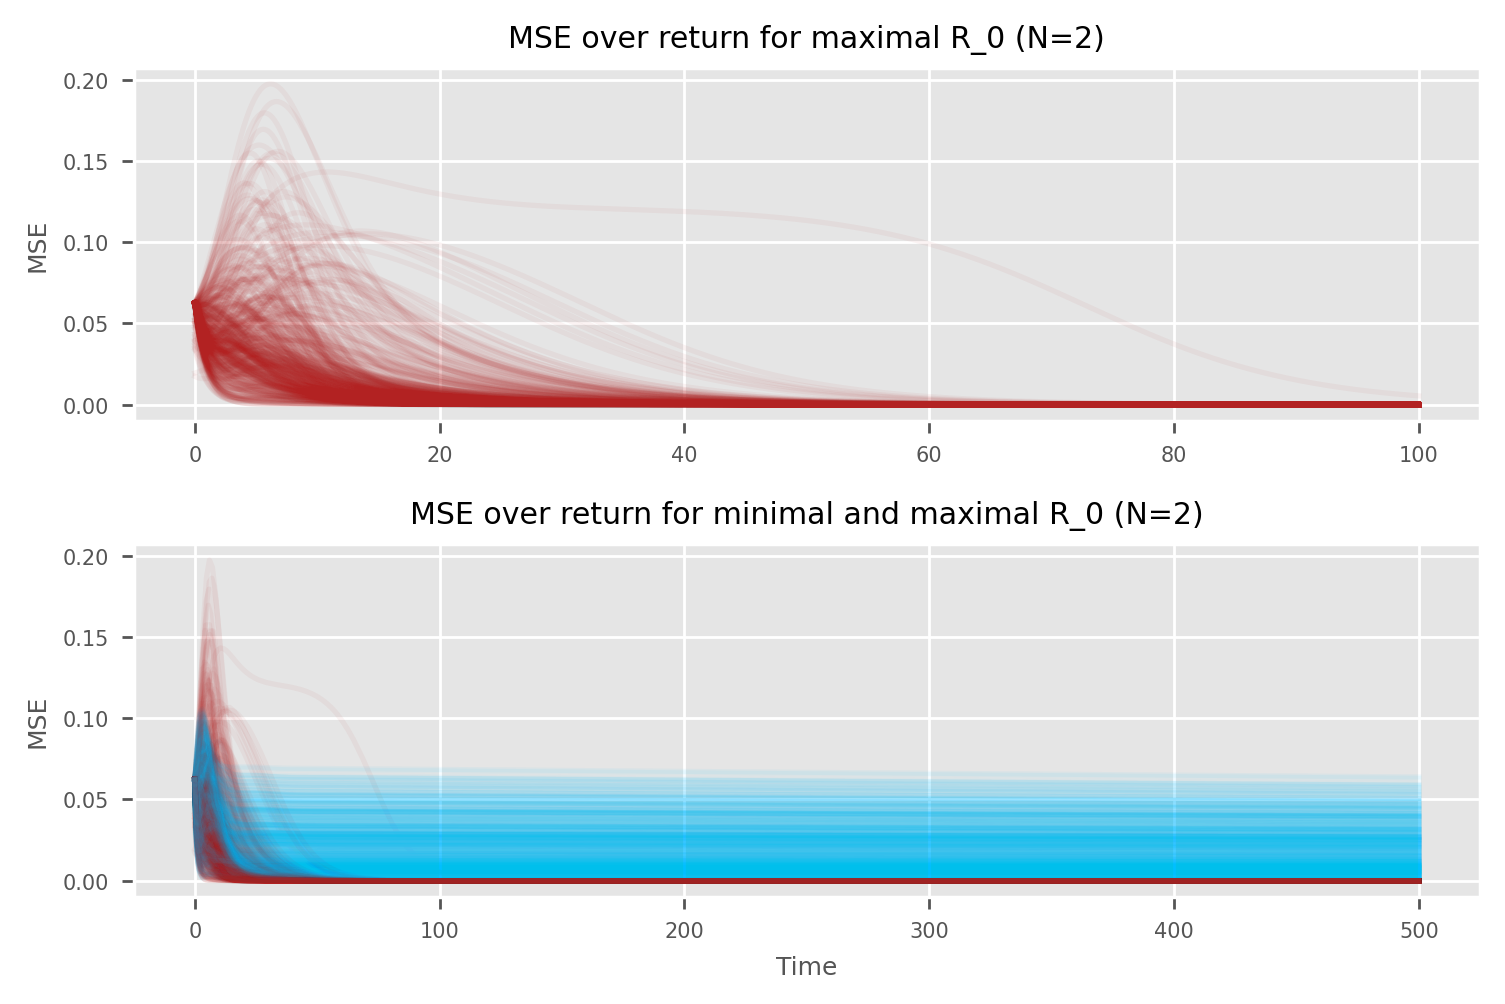

In [614]:
sol2_CL1_minR0, mse2_CL1_minR0, sol2_CL1_maxR0, mse2_CL1_maxR0 = OD_MSE_sim_plot(OD2_CL1_unifD, time=(0,500), 
                                                                                 time_fast=(0,100), stab_measure="R_0", 
                                                                                 num_perts=500, pert_frac=0.5,
                                                                                seed=999)



In [617]:
minR0_idx2 = np.argmin(OD2_CL1_unifD.R_0)

In [620]:
minR0_idx2

58

In [621]:
OD2_CL1_unifD.R_0[minR0_idx2]

-0.36685325127263474

In [618]:
maxR0_idx2 = np.argmax(OD2_CL1_unifD.R_0)

In [619]:
maxR0_idx2

988

In [622]:
OD2_CL1_unifD.R_0[maxR0_idx2]

-0.061337954023653996

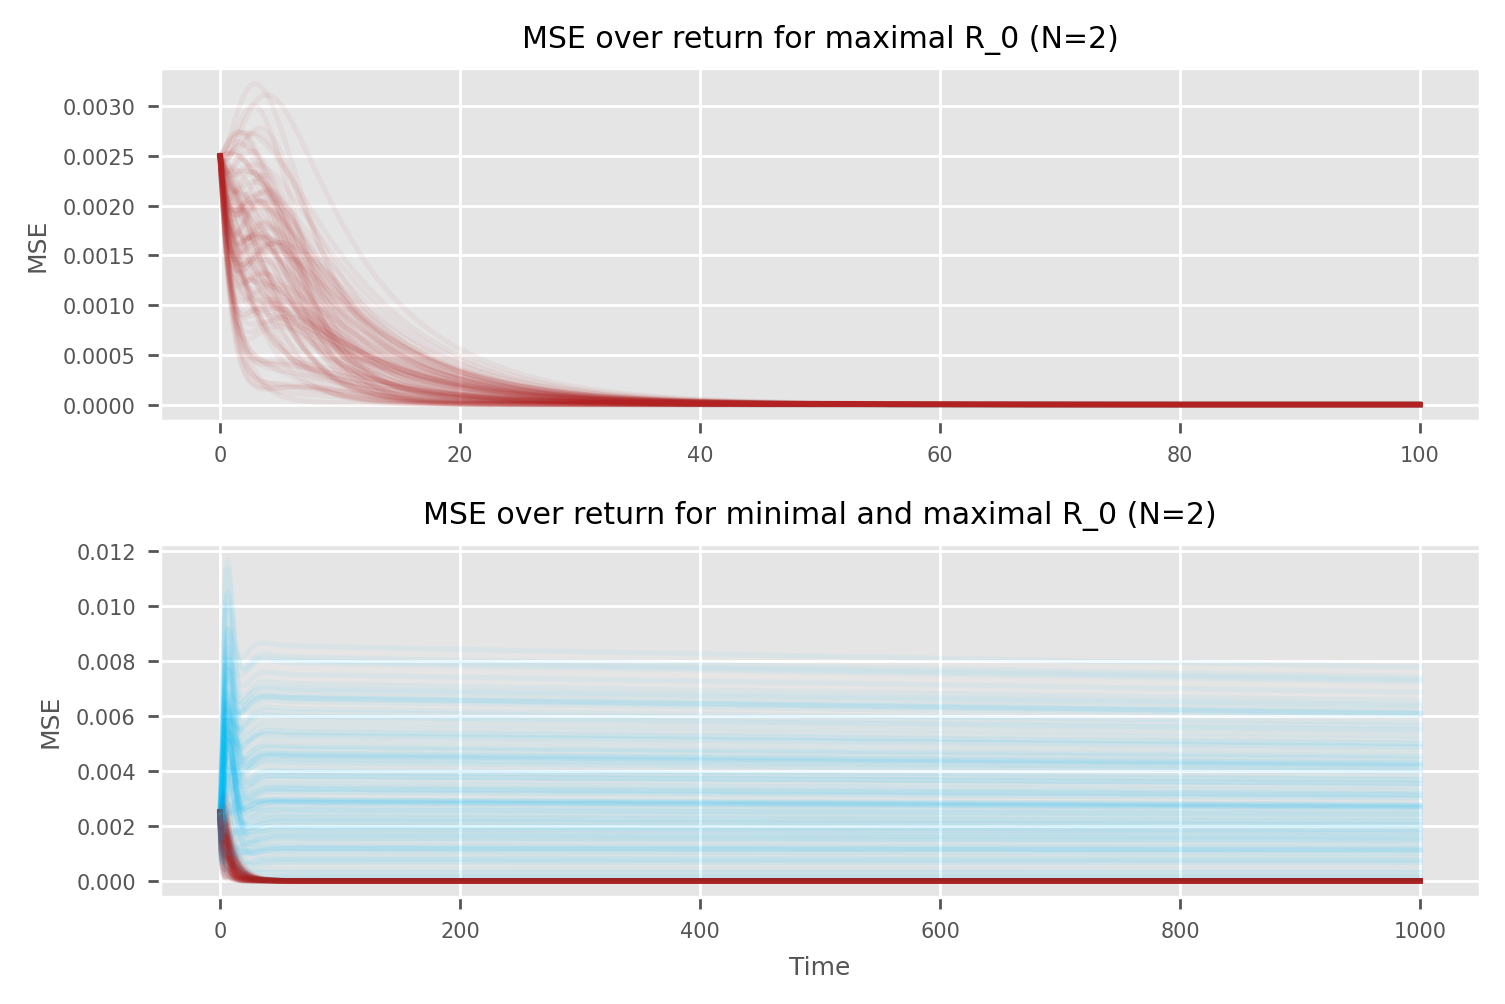

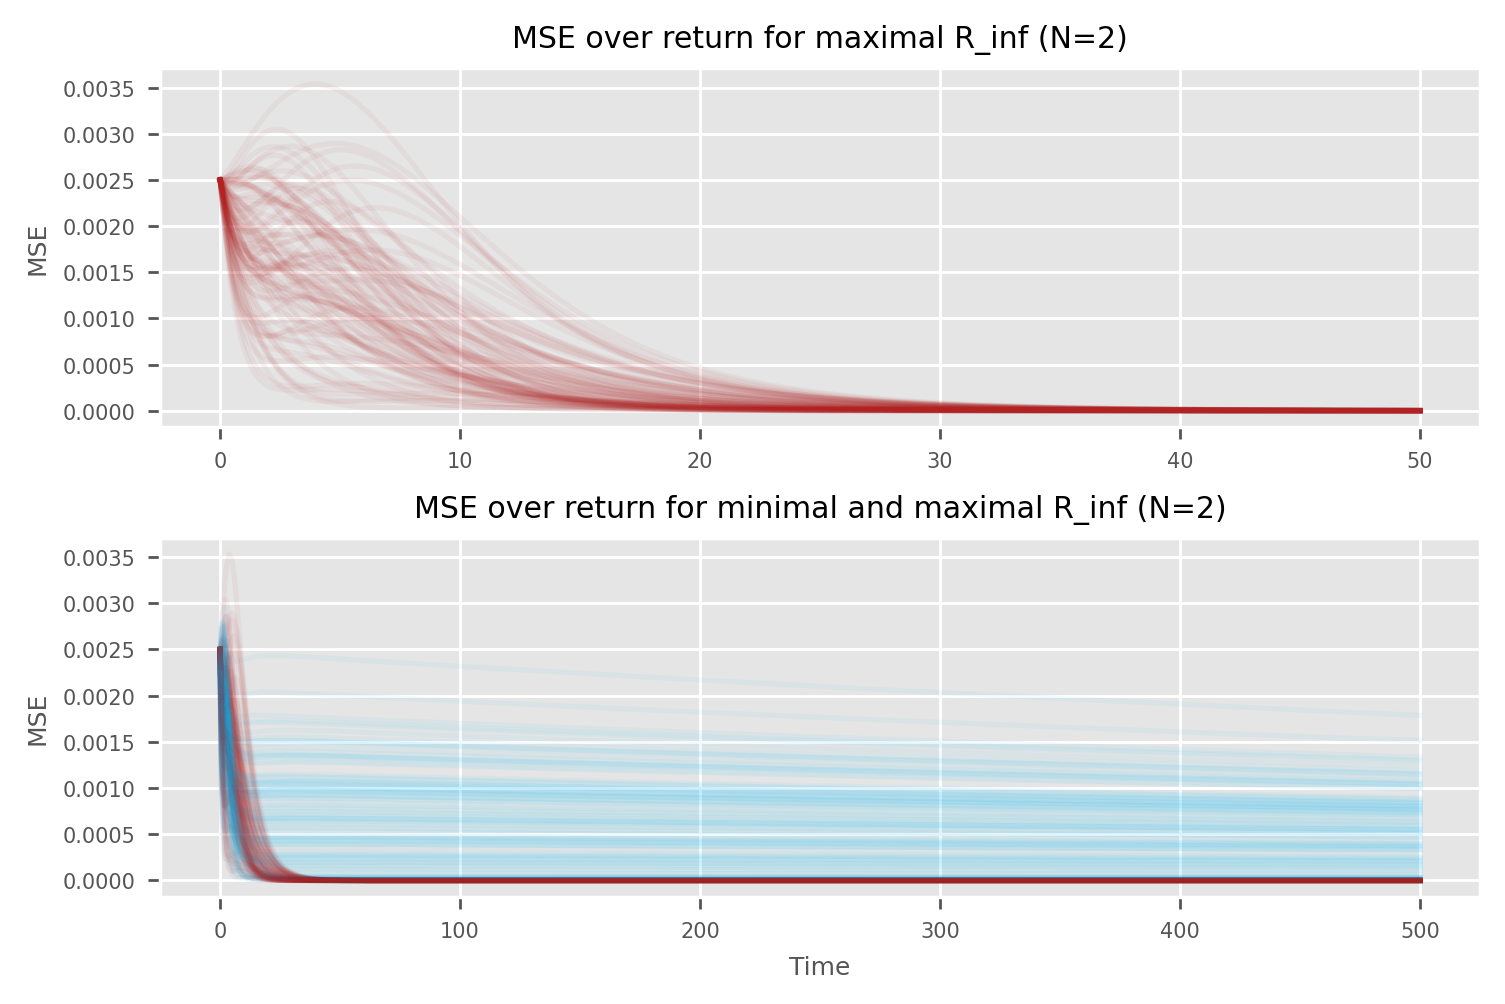

In [580]:
sol2_CL1_minRinf, mse2_CL1_minRinf, sol2_CL1_maxRinf, mse2_CL1_maxRinf = OD_MSE_sim_plot(OD2_CL1_unifD, time=(0,500), time_fast=(0,50), stab_measure="R_inf", num_perts=100)



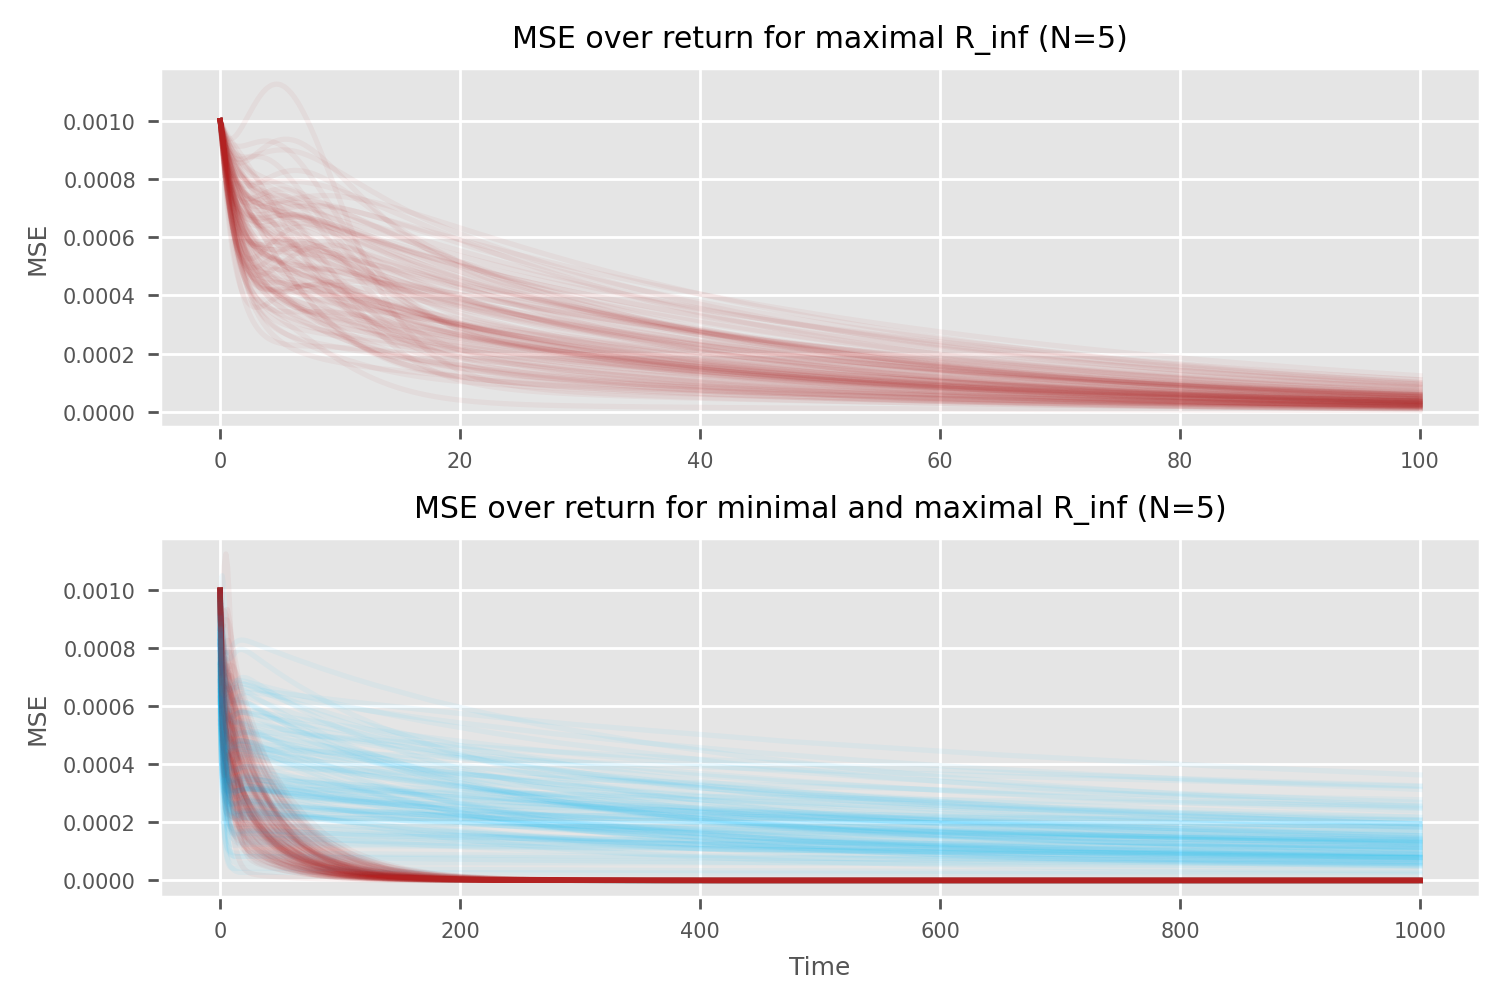

In [582]:
sol5_CL1_minRinf, mse5_CL1_minRinf, sol5_CL1_maxRinf, mse5_CL1_maxRinf = OD_MSE_sim_plot(OD5_CL1_unifD, time=(0,1000), time_fast=(0,100), stab_measure="R_inf", num_perts=100)


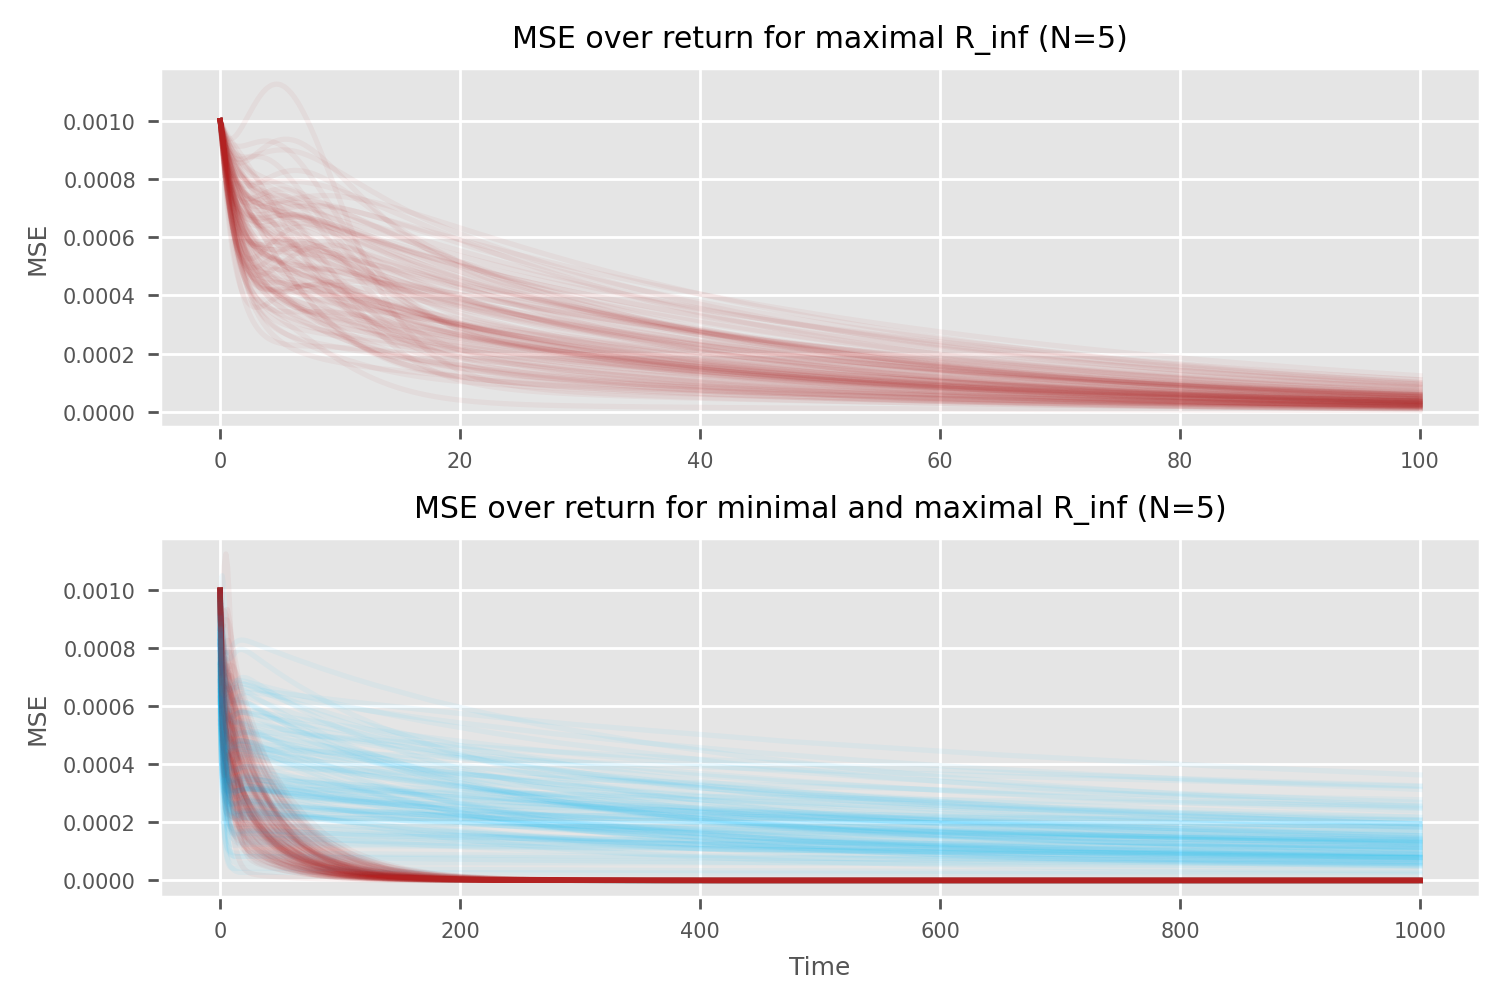

In [582]:
sol5_CL1_minRinf, mse5_CL1_minRinf, sol5_CL1_maxRinf, mse5_CL1_maxRinf = OD_MSE_sim_plot(OD5_CL1_unifD, time=(0,1000), time_fast=(0,100), stab_measure="R_inf", num_perts=100)


In [550]:
ts = np.linspace(0.1,10,100)
ys = np.zeros((3,2,100));
ys[0,:,:] = np.array([2,3]).reshape(2,1) * np.log(ts)
ys[1,:,:] = np.array([0.1,0.4]).reshape(2,1) * np.log(ts)
ys[2,:,:] = np.array([10,7]).reshape(2,1) * np.log(ts)


In [ ]:
# want 3 systems of 2 vars in 1000 time steps

ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 3, 2)

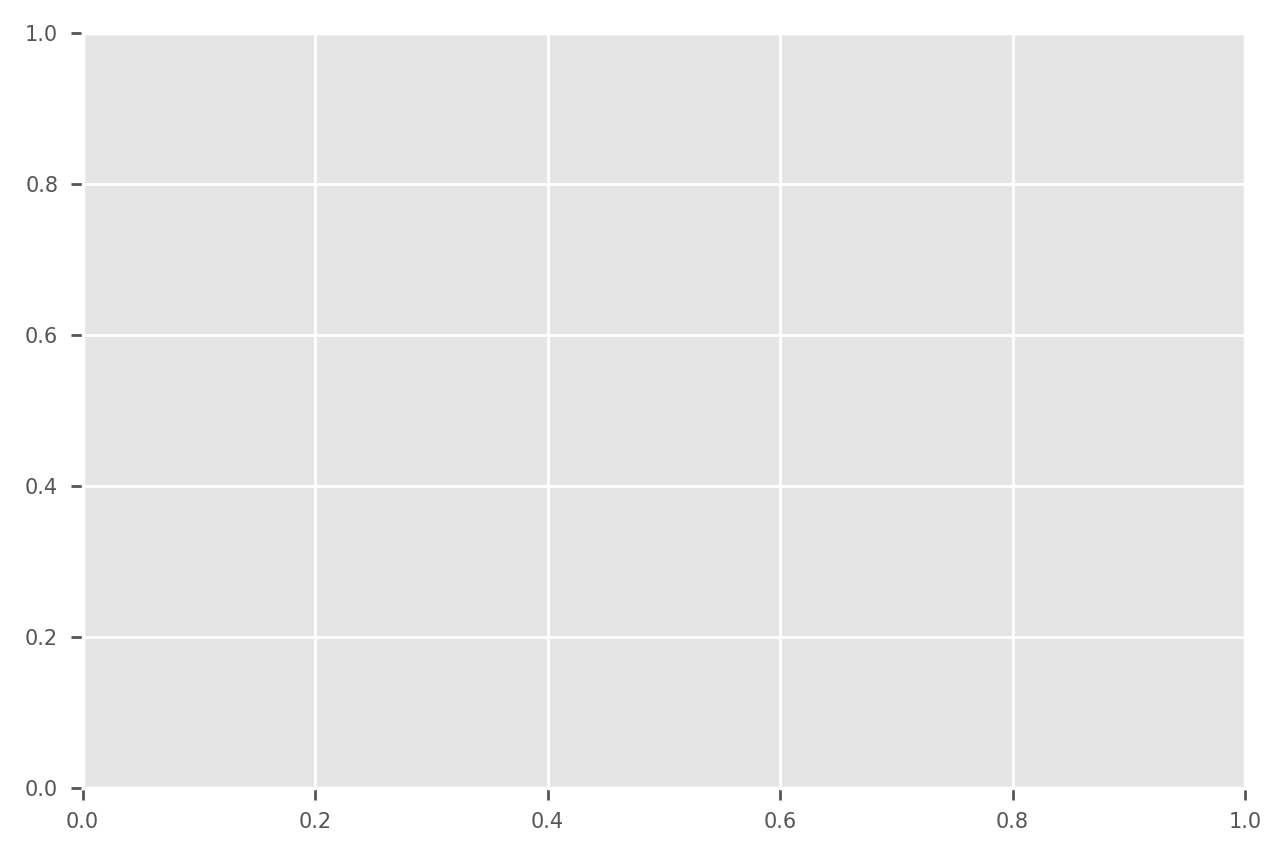

In [553]:
plt.plot(ts,ys.reshape(100,3,2))

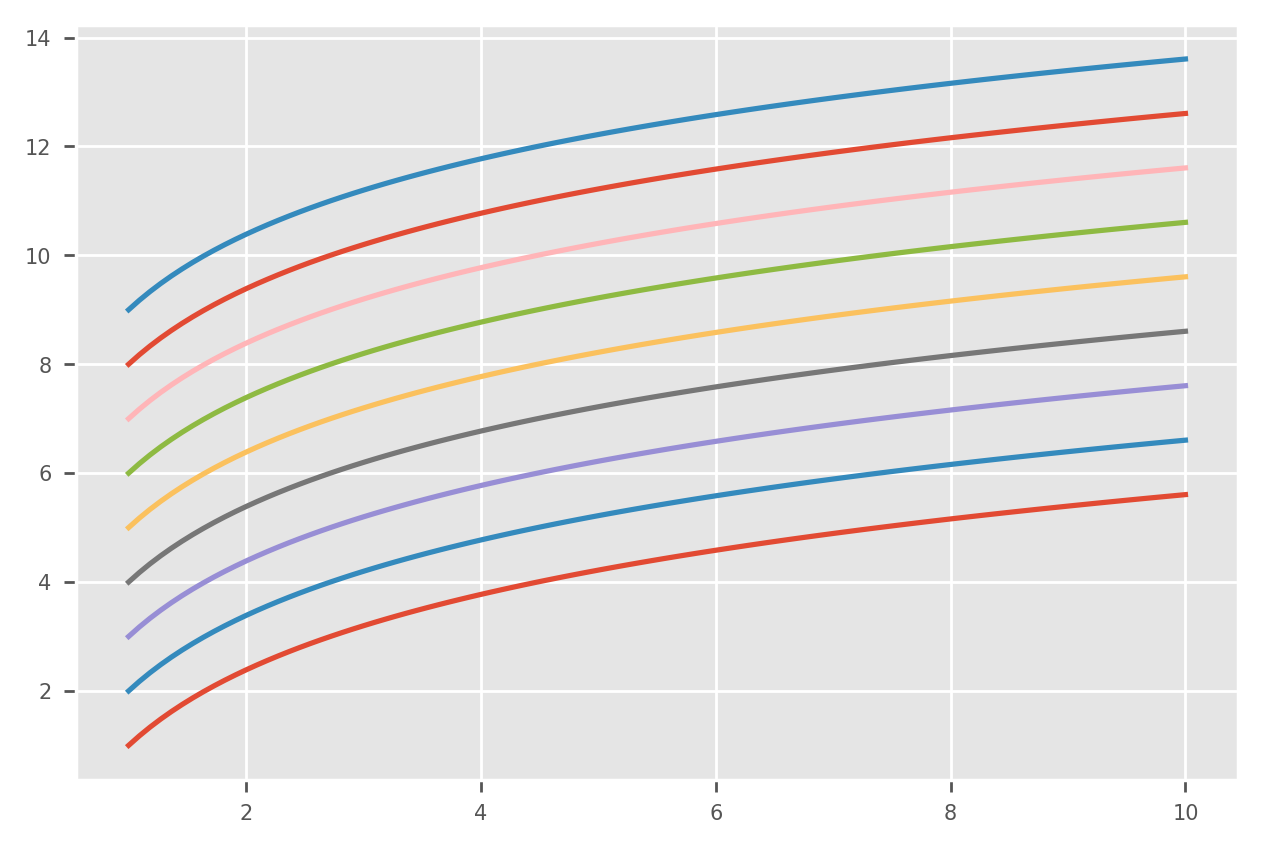

In [563]:
a = 2
x = np.linspace(1,10,100)
b = np.array([1,2,3,4,5,6,7,8,9])

y = a*np.log(x[:,None])+b
plt.plot(x, y);

In [558]:
y.shape

(4, 9)

In [532]:

sol_temp = sol2_CL1_max.sol(np.linspace(0,50,1000))
eq_temp = np.concatenate([OD2_CL1_unifD.R_star[np.argmax(OD2_CL1_unifD.R_0)], OD2_CL1_unifD.S_star[np.argmax(OD2_CL1_unifD.R_0)]])


mse_temp = np.mean(np.square(sol_temp - eq_temp), axis=0)

plt.plot(np.linspace(0,50,1000), mse_temp);

In [ ]:
def mse_sim_single(Sys, idx, num_perts, tit, time=(0,1000), seed=2):

    check_eq = np.concatenate([Sys.R_star[idx],Sys.S_star[idx]])
    np.random.seed(2)
    plt.figure(figsize=(4,3), dpi=150);
    for i in range(num_perts):
        u = np.random.uniform(-1,1,(int(Sys.n*2),1))
        # u = us[i]
        check_init = check_eq + 0.1*u/np.linalg.norm(u)
        check_init=np.abs(check_init.flatten())

        check_soln = solve_ivp(OD_eqns_alt, t_span=time,  y0=check_init, args=(Sys.C, Sys.eps, Sys.mu[idx], Sys.rho[idx])
                          , dense_output=True, method='LSODA', vectorized=True)

        check_mse = np.mean(np.square(check_soln.y - check_eq), axis=0)

        # check_soln.y.T[-1,:] - check_eq.flatten()

        # _=plt.plot(check_soln.t, check_soln.y.T);

        _=plt.plot(check_soln.t[:], check_mse[:], alpha=0.05, color='firebrick');
    plt.title(tit, fontsize=8);
    plt.show();
    return [check_soln, check_mse]

### n=10

In [324]:
minR0_idx10 = np.argmin(OD10_CL1_unifD.R_0)

maxR0_idx10 = np.argmax(OD10_CL1_unifD.R_0)

In [325]:
OD10_CL1_unifD.R_0[minR0_idx10]
OD10_CL1_unifD.R_inf[minR0_idx10]

-0.3928094549425606

4.773368659985866e-07

In [326]:
OD10_CL1_unifD.R_0[maxR0_idx10]
OD10_CL1_unifD.R_inf[maxR0_idx10]

-0.038218513791690986

0.001611223751312931

In [327]:
minRS10_star = np.concatenate((OD10_CL1_unifD.R_star[minR0_idx10], OD10_CL1_unifD.S_star[minR0_idx10]), 0)
maxRS10_star = np.concatenate((OD10_CL1_unifD.R_star[maxR0_idx10], OD10_CL1_unifD.S_star[maxR0_idx10]), 0)

In [328]:
np.random.seed(2)
# Numerical solution for (10,10) system
t = np.linspace(0, 10000, 100001) # time to simulate

u_2 = u_gen_prop(OD10_CL1_unifD.n,minRS10_star).reshape(-1,1)
np.linalg.norm(u_2,2)

v_2 = u_gen_prop(OD10_CL1_unifD.n,maxRS10_star).reshape(-1,1)
np.linalg.norm(v_2,2)

init_cond = (u_2.reshape(-1)+minRS10_star.flatten())
init_cond[init_cond<0]=0 # Densities can not be negative.
init_cond = list(init_cond)
# init_cond
# init_cond_max = (v_2.reshape(-1)+maxRS10_star.flatten())
# init_cond_max[init_cond_max<0]=0 
# init_cond_max = list(init_cond_max)
init_cond_max = init_cond

0.9999999999999999

1.0

In [329]:
sol10 = odeint(OD_eqns, init_cond, t, args=(OD10_CL1_unifD.C, OD10_CL1_unifD.eps, OD10_CL1_unifD.mu[minR0_idx10], OD10_CL1_unifD.rho[minR0_idx10]) )


In [330]:
sol10_max = odeint(OD_eqns, init_cond_max, t, args=(OD10_CL1_unifD.C, OD10_CL1_unifD.eps, OD10_CL1_unifD.mu[maxR0_idx10], OD10_CL1_unifD.rho[maxR0_idx10]) )


In [331]:
mseR0_min10 = np.mean(np.square(sol10[:,-10:] - minRS10_star[-10:].flatten()), axis=1)

In [332]:
# (OD10_CL1_unifD.S_star[minR0_idx10].flatten()) # Diversity ~1.8

# (OD10_CL1_unifD.S_star[maxR0_idx10].flatten()) # Diversity ~9.4

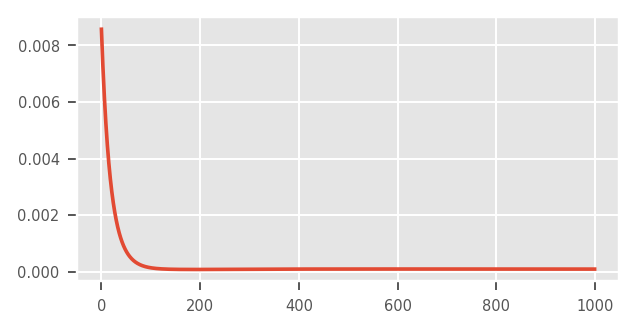

In [333]:
plt.figure(figsize=(4,2), dpi=175)
plt.plot(np.arange(1001)[:-1], (mseR0_min10[:1000]));
# plt.plot(np.arange(1001)[:-1], mseR0_max10[:1000]);

In [334]:
# Simulate every system and get MSE during (most of the) return to eq.
np.random.seed(2)

mses_CL1_10 = [None] * OD10_CL1_unifD.k
for i in range(OD10_CL1_unifD.k):
    N_temp = np.concatenate([OD10_CL1_unifD.R_star[i], OD10_CL1_unifD.S_star[i]])
    u_temp = u_gen_prop(OD10_CL1_unifD.n,N_temp).reshape(-1,1)
    init_cond = 0.1*(u_temp.reshape(-1)+N_temp.flatten())
    
    # init_cond[init_cond<0]=0 # Densities can not be negative. Hopefully, not needed for 0.1-length
    init_cond = list(init_cond)
    sol_CL1_10_temp = odeint(OD_eqns, init_cond, t[:500], args=(OD10_CL1_unifD.C, OD10_CL1_unifD.eps, OD10_CL1_unifD.mu[i], OD10_CL1_unifD.rho[i]) )
    mses_CL1_10[i] = np.mean(np.square(sol_CL1_10_temp[:,10:] - N_temp[10:].flatten()), axis=1)
        

C:\Users\riley\anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [335]:
sol_CL1_10_temp.shape

(500, 20)

In [336]:
np.min(mses_CL1_10[99])

0.00014512838125077

In [337]:
len(mses_CL1_10)

1000

In [338]:
temp = np.array(mses_CL1_10)

In [339]:
temp.shape

(1000, 500)

In [340]:
np.argmax(temp, axis=0).shape

(500,)

In [341]:
np.where(np.any(temp == np.max(temp), axis=1))
np.where(np.any(temp == np.max(temp), axis=0))

(array([778], dtype=int64),)

(array([228], dtype=int64),)

In [342]:
temp[778,228]

7.761607773151768e+26

In [344]:
np.max(temp[np.argmax(temp, axis=1)[0], :])

0.05396429852142813

In [345]:
np.argmax(temp[:,np.argmax(temp, axis=1)[0]])

13

In [346]:
np.max(temp[13,:])

5951813923338880.0

In [347]:
np.min(OD10_CL1_unifD.R_0)

-0.3928094549425606

In [348]:
np.min(OD10_CL1_unifD.R_inf)

2.4685427894120004e-14

In [349]:
OD10_CL1_unifD.D_s[778]
OD10_CL1_unifD.R_0[778]
OD10_CL1_unifD.R_inf[778]

array([7.7269879])

-0.06854963416863806

5.6767253135021835e-05

In [353]:
mseR0_max10=np.mean(np.square(sol10_max[:,-10:] - maxRS10_star[-10:].reshape(1,10)), axis=1)

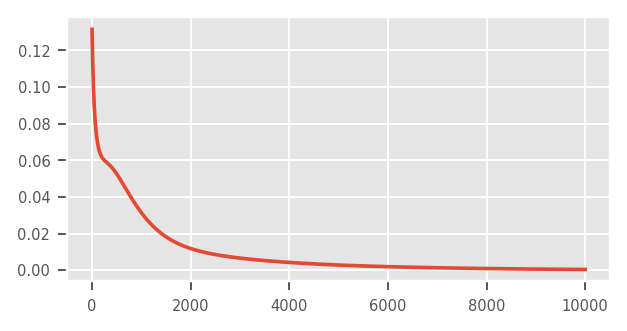

In [354]:
plt.figure(figsize=(4,2), dpi=175)
plt.plot(np.arange(10001)[:-1], mseR0_max10[:10000]);

### n=5

### n=2

#### One system, many directions of perturbation

In [ ]:
def mse_sim_single(Sys, idx, num_perts, tit, time=(0,1000), seed=2):
#     check_init = check_eq + 1.0*check_eq/np.linalg.norm(check_eq)
#     check_init=check_init.flatten()
#     check_soln = solve_ivp(OD_eqns_alt, t_span=(0,100),  y0=check_init, args=(Sys.C, Sys.eps, Sys.mu[idx], Sys.rho[idx])
#                       , dense_output=True, method='LSODA', vectorized=True)


#     check_mse = np.mean(np.square(check_soln.y - check_eq), axis=0)
    check_eq = np.concatenate([Sys.R_star[idx],Sys.S_star[idx]])
    np.random.seed(2)
    plt.figure(figsize=(4,3), dpi=150);
    for i in range(num_perts):
        u = np.random.uniform(-1,1,(int(Sys.n*2),1))
        # u = us[i]
        check_init = check_eq + 0.1*u/np.linalg.norm(u)
        check_init=np.abs(check_init.flatten())

        check_soln = solve_ivp(OD_eqns_alt, t_span=time,  y0=check_init, args=(Sys.C, Sys.eps, Sys.mu[idx], Sys.rho[idx])
                          , dense_output=True, method='LSODA', vectorized=True)

        check_mse = np.mean(np.square(check_soln.y - check_eq), axis=0)

        # check_soln.y.T[-1,:] - check_eq.flatten()

        # _=plt.plot(check_soln.t, check_soln.y.T);

        _=plt.plot(check_soln.t[:], check_mse[:], alpha=0.05, color='firebrick');
    plt.title(tit, fontsize=8);
    plt.show();
    return [check_soln, check_mse]

In [ ]:
sol2_CL1_min, mse2_CL1_min = mse_sim_single(OD2_CL1_unifD, idx=np.argmin(OD2_CL1_unifD.R_0), num_perts=100, 
                                            tit='OD2 CL1 (Minimal/Maximal R_0)', time=(0,10000), seed=2)


In [ ]:
_,_ = mse_sim_single(OD2_CL1_unifD, idx=np.argmin(OD2_CL1_unifD.D_s), num_perts=100, 
                     tit='OD2 CL1 (Minimal D)', time=(0,10000), seed=2)


In [ ]:
sol2_CL1_min, mse2_CL1_min = mse_sim_single(OD2_CL1_unifD, idx=np.argmin(OD2_CL1_unifD.R_0), num_perts=100, 
                                            tit='OD2 CL1 (Minimal R_0)', time=(0,100), seed=2)


In [ ]:
sol2_CL1_max, mse2_CL1_max = mse_sim_single(OD2_CL1_unifD, idx=np.argmax(OD2_CL1_unifD.R_0), num_perts=100, 
                                            tit='OD2 CL1 (Max R_0)', time=(0,100), seed=2)


In [ ]:
plt.plot(sol2_CL1_min.t, mse2_CL1_min, color='deepskyblue', label='minR0');
plt.plot(sol2_CL1_max.t, mse2_CL1_max, color='firebrick', label='maxR0');
plt.legend();

In [ ]:
sol10_CL1_min, mse10_CL1_min = mse_sim_single(OD10_CL1_unifD, idx=np.argmin(OD10_CL1_unifD.R_0), num_perts=100, 
                                            tit=r'OD10 CL1 (Min $R_0$)', time=(0,2500), seed=2)


In [ ]:
sol10_CL1_max, mse10_CL1_max = mse_sim_single(OD10_CL1_unifD, idx=np.argmax(OD10_CL1_unifD.R_0), num_perts=100, 
                                            tit='OD10 CL1 (Max R_0)', time=(0,2500), seed=2)


In [ ]:
sol10_CL1_minRinf, mse10_CL1_minRinf = mse_sim_single(OD10_CL1_unifD, idx=np.argmin(OD10_CL1_unifD.R_inf), num_perts=100, 
                                            tit=r'OD10 CL1 (Min $R_{\infty}$)', time=(0,2500), seed=2)


In [ ]:
sol10_CL1_maxRinf, mse10_CL1_maxRinf = mse_sim_single(OD10_CL1_unifD, idx=np.argmax(OD10_CL1_unifD.R_inf), num_perts=100, 
                                            tit=r'OD10 CL1 (Max $R_{\infty}$)', time=(0,2500), seed=2)


In [ ]:
OD10_CL1_unifD.R_inf[np.argmin(OD10_CL1_unifD.R_inf)]

In [ ]:
OD10_CL1_unifD.R_inf[np.argmax(OD10_CL1_unifD.R_inf)]

In [ ]:
sol10_CR1_minRinf, mse10_CR1_minRinf = mse_sim_single(OD10_CR1_unifD, idx=np.argmin(OD10_CR1_unifD.R_inf), num_perts=100, 
                                            tit=r'OD10 CR1 (Min $R_{\infty}$)', time=(0,2500), seed=2)


In [ ]:
sol10_CR1_maxRinf, mse10_CR1_maxRinf = mse_sim_single(OD10_CR1_unifD, idx=np.argmax(OD10_CR1_unifD.R_inf), num_perts=100, 
                                            tit=r'OD10 CR1 (Max $R_{\infty}$)', time=(0,2500), seed=2)


In [ ]:
OD10_CR1_unifD.R_inf[np.argmin(OD10_CR1_unifD.R_inf)]

In [ ]:
OD10_CR1_unifD.R_inf[np.argmax(OD10_CR1_unifD.R_inf)]

In [ ]:
OD10_CL1_unifD.R_0[np.argmin(OD10_CL1_unifD.R_0)]

In [ ]:
OD10_CL1_unifD.R_0[np.argmax(OD10_CL1_unifD.R_0)]

In [ ]:
OD2_CL1_unifD.R_0[np.argmin(OD2_CL1_unifD.R_0)]

In [ ]:
OD2_CL1_unifD.R_0[np.argmax(OD2_CL1_unifD.R_0)]

In [ ]:
ut = np.random.uniform(-1,1, (2,1))
OD2_CL1_unifD.S_star[np.argmin(OD2_CL1_unifD.R_0)] + ut / np.linalg.norm(ut)

In [ ]:
np.random.seed(2)
msemax = np.zeros(10)
for i in range(10):
    ut = np.random.uniform(-1,1 (2,1))
    ic = (OD2_CL1_unifD.S_star[np.argmax(OD2_CL1_unifD.R_0)] + ut / np.linalg.norm(ut))
    

In [ ]:
OD2_CL1_unifD.R_star[999]

In [ ]:
OD2_CL1_unifD.S_star[999]

In [ ]:
plt.figure(figsize=(4,2), dpi=250);
# plt.ylim(0,2);
upto=40
for i in range(OD2_CL1_unifD.k//10):
    # upto=mses_CL1_2[i].size
    _ = plt.plot(solns_CL1_2[i].t[:], mses_CL1_2[i][:], alpha=0.05, color='firebrick');

In [ ]:
solns_CL1_2[5].y[:,-1]

In [ ]:
tempN = np.concatenate([OD2_CL1_unifD.R_star[5], OD2_CL1_unifD.S_star[5]])
tempN.flatten()

In [ ]:
mses_CL1_2[1][-1]

In [ ]:
big_ones = []
for i in range(1000):
    if (mses_CL1_2[i][-1] > 0.0001):
        big_ones.append(i)

In [ ]:
lil_ones = list(set(list(range(1000))) - set(big_ones))

In [ ]:
# OD2_CL1_unifD.S_star[lil_ones]

In [ ]:
plt.hist(OD2_CL1_unifD.S_star[lil_ones].reshape(len(lil_ones),-1));

In [ ]:
plt.hist(OD2_CL1_unifD.S_star[big_ones].reshape(len(big_ones),-1));

In [ ]:
plt.figure(figsize=(4,2), dpi=250);
# plt.ylim(0,2);
upto=40
for i in lil_ones:
    # upto=mses_CL1_2[i].size
    _ = plt.plot(solns_CL1_2[i].t[:upto], mses_CL1_2[i][:upto], alpha=0.05, color='firebrick');
plt.title('N=2 CL1 systems that go to equilibrium');

In [ ]:
plt.figure(figsize=(4,2), dpi=250);
# plt.ylim(0,2);
upto=-1
for i in big_ones:
    # upto=mses_CL1_2[i].size
    _ = plt.plot(solns_CL1_2[i].t[:upto], mses_CL1_2[i][:upto], alpha=0.05, color='firebrick');
plt.title('N=2 CL1 systems that DO NOT go to equilibrium');

# Generalized Lotka-Volterra

In [ ]:
from scipy.linalg import solve as slv # For calculating equilibrium populations of gLV.

In [ ]:
from Lotka_Volterra_Tools import *

## Making random stable gLV systems

In [ ]:
# A + eps B
# A strictly diag (known eigvals, negative real part)
# B ~ Unif/Norm
# for cyclical dynamics, have multiple eigvals, on those offdiag entries, add conjugates
# lambda2 +- zi

In [ ]:
np.random.seed(667)
A = np.diag(np.random.uniform(-2,0,5))

eigvals(A)

np.random.seed(667)
B = np.random.uniform(-1,1, (100,5,5))
eps = 0.3

Ap = A + eps*B

# eigvals(Ap)

### Ben's Reverse Method

In [ ]:
C = Ap

In [ ]:
_ = uniform_D(n=3, k=9000)

In [ ]:
def reverse_gLV_prams(C_, X_eq, superk=50000):
    # np.random.seed(seed)
    # Seed? B/C random N_0 
    ### NOT ANYMORE
    k_ = C_.shape[0] # Need 3-dim array
    n_ = C_.shape[-1]
    
    # X_eq = np.random.uniform(X_eq_lo, X_eq_hi, (k_,n_,1))
    
    Coef = np.zeros((k_,n_,n_))
    
    DIs = np.diag_indices(n_)[0]
    # print(DIs)
    diag_X_eq = np.zeros((k_,n_,n_))
    diag_X_eq[:,DIs,DIs] = np.squeeze(1/X_eq)
    
    offDiag = dot_across(A=diag_X_eq, x=C_) # 3-dim
    
    Coef = offDiag # How mask indices simply? Like ~idx in pandas?
    Coef[:,DIs,DIs] = 0
    
    prod = np.squeeze(dot_across(Coef, X_eq)) # 2-dim
    alphas = -C_[:,DIs,DIs] - prod # 2-dim
    # alphas_copy = alphas.copy()
    # print(prod.shape)
    Coef[:,DIs,DIs] = -(alphas +  prod) / np.squeeze(X_eq)
    
    # equil check
    alphas = np.expand_dims(alphas, axis=2)
    

    return (alphas, Coef)

In [ ]:
x,y,z = uniform_D(n=5, k=75000)

In [ ]:
reverse = reverse_gLV_prams(C_=np.repeat(C, 10, axis=0), X_eq=x, superk=75000) # Test it out

In [ ]:
a, b = reverse

In [ ]:
np.max(np.abs((a.reshape(1000,5) * x + x * dot_across(b, x).reshape(1000,5))))

In [ ]:
# # Try the check without my possibly borked gLV Jacobian function
# DIs = np.diag_indices(5)[0]
# M1 = np.zeros((100,5,5))
# M1[:,DIs,DIs] = np.squeeze(a)

# M2 = np.zeros((100,5,5))
# M2[:,DIs,DIs] = np.squeeze(dot_across(b,x))

# M3 = np.zeros((100,5,5))
# M3[:,DIs,DIs] = np.squeeze(x)
# M3 = dot_across(M3,b)

# np.max(np.abs(M1 + M2 + M3 - C))

In [ ]:
np.all(eigvals(C).real<0)


## Numerically solving gLV

$$\dot{N_i}=r_i N_i (1-\frac{N_i}{k_i}) + N_i \sum_{j=1, j\neq i}^n \beta_{i,j} N_j $$

In [ ]:
np.random.seed(667)
M1 = np.random.poisson(1, (4,5,5))
M2 = np.random.poisson(2, (4,5,5))

In [ ]:
np.random.seed(667)
xs = np.random.uniform(0,1,(100,5,1)) # test vectors

In [ ]:
# General, linearized dynamic system numerical solver.
def solve_linearized(A, N_0, its=100, h=0.1):
    # Step size, number of iterations, stack of community matrices, initial population(s?)
    k_ = A.shape[0]
    n_ = A.shape[-1]
    
    ys = np.zeros((k_, n_, its)) # (system idx, state var idx, iteration idx)
    # ys[:,:,0] = N_0.reshape(-1) # All same initial condition for ease. Lame and Bad.
    ys[:,:,0] = N_0.reshape(k_,n_) # Different initial conditions
    # t=0 # autonomous system
    for i in range(its-1):
        y_n = np.expand_dims(ys[:,:,i],-1)
        k1 = dot_across(A, y_n)
        k2 = dot_across(A, y_n + h*k1/2)
        k3 = dot_across(A, y_n + h*k2/2)
        k4 = dot_across(A, y_n + h*k3)
        
        ys[:,:,i+1] = np.squeeze(y_n + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*h)

    return ys

In [ ]:
x.shape

In [ ]:
pert.shape

In [ ]:
np.random.seed(667)
pert = np.random.uniform(-1,1,(x.shape[0],x.shape[1], 1))

PERT = np.linalg.norm(pert / np.linalg.norm(pert, axis=1)[:,None,:], axis=1) # Unit perturbation from desired equilibrium; init condition for sim to verify


In [ ]:
# Do the actual gLV equations, then.
def gLV(X_, A_, r_): # only takes interaction matrix, intrinsic growth, and current populations
    k_ = A_.shape[0]
    n_ = A_.shape[-1]
    
    deltaX = np.zeros((k_,n_,1))
    deltaX = X_.reshape(k_,n_,1) * (r_ + dot_across(A_,X_)).reshape(k_,n_,1)
    
    return deltaX

In [ ]:
# gLV(X_=x+PERT, A_=b, r_=a).shape

# full_soln = solve_ivp(fun=gLV, t_span=[0,10], y0=x+PERT, args = (b, a))

In [ ]:
# Use RK4 on stack of systems to get their equilibria.
def solve_gLV(A, r, N_0, its=200, h=0.1):
    # Step size, number of iterations, stack of community matrices, initial population(s?)
    k_ = A.shape[0]
    n_ = A.shape[-1]
    
    ys = np.zeros((k_, n_, its)) # (system idx, state var idx, iteration idx)
    # ys[:,:,0] = N_0.reshape(-1) # All same initial condition for ease. Lame and Bad.
    ys[:,:,0] = N_0.reshape(k_,n_) # Different initial conditions
    for i in range(its-1):
        # y_n = np.expand_dims(ys[:,:,i],-1)
        y_n = ys[:,:,i].reshape(k_,n_,1)
        k1 = gLV(X_=y_n, A_=A, r_=r)
        k2 = gLV(X_=y_n + h*k1/2, A_=A, r_=r)
        k3 = gLV(X_=y_n + h*k2/2, A_=A, r_=r)
        k4 = gLV(X_=y_n + h*k3, A_=A, r_=r)
                
        ys[:,:,i+1] = np.squeeze(y_n + (1./6)*(k1 + 2*k2 + 2*k3 + k4)*h)

    return ys

## gLV system class

In [ ]:
# Now do them all

class gLVsystem:
    '''
    Lotka-Volterra systems + their community matrices and equilibria + Arnoldi Measures.
    -------------------------------------------------------
    Specify:
    k, number of systems
    n, number of species
    M1_bounds, (lower,upper) interval for Unif distribution of desired eigenvalues
    M2_bounds, (lower,upper) interval for Unif distribution of perturbation matrix entries
    
    '''
    def __init__(self, k_=1000, superk=75000, n_=5, eps_=0.3, M1_bounds_=(-2,0), M2_bounds_=(-1,1), N_star_bounds_=(10,20), seed_=667):
        self.k = k_
        self.n = n_
        self.eps = eps_
        self.seed = seed_
        self.M1_bounds = M1_bounds_
        self.M2_bounds = M2_bounds_
        self.N_star_bounds = N_star_bounds_

        nDIs = np.diag_indices(n_)[0]
        kDIs = np.diag_indices(k_)[0]    
        
        np.random.seed(self.seed)
        self.M1 = np.zeros((self.k,self.n,self.n))
        self.M1[:,nDIs,nDIs] = np.random.uniform(self.M1_bounds[0], self.M1_bounds[1], (self.k,self.n))
        self.M2 = np.random.uniform(self.M2_bounds[0], self.M2_bounds[1], (self.k,self.n,self.n))
        self.J = self.M1 + self.eps*self.M2
        
        self.n_star, self.D, self.bins = uniform_D(n=self.n, k=superk, seed_=self.seed)
        # print(self.n_star.shape)
        self.n_star = self.n_star.reshape(self.k, self.n, 1)
        self.N_star = self.n_star * self.N_star_bounds[0]
        
        self.r, self.A = reverse_gLV_prams(C_=self.J, X_eq=self.N_star)
        
        self.stable_idx = np.where(np.all(eigvals(self.J).real<0,axis=-1))[0]
        # Still do all calculations, then just plot using self.stable_idx
        ## Make more efficient later by only calc'ing stability, diversity measures for stable systems
        
        ### Arnoldi Measures ###
        self.R_0 = init_res(self.J)
        self.R_inf = asym_res(self.J)
        self.I_S = np.zeros(self.k)
        for i in range(self.k):
            self.I_S[i] = stoch_invar(self.J[i,:,:])
        self.I_D = np.zeros(self.k)
        for i in range(self.k):
            self.I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(self.J[i,:,:]), method='brent').fun

        ### Diversity Measures ###
        # self.n_star = sum_to_one(self.N_star)

        self.simpson = simpson_conc(self.n_star)
        self.shannon = shannon_entropy(self.n_star)
        self.gini_simp = gini_simpson_index(self.n_star)
        self.hcdt_entropy = hcdt_entropy(self.n_star, q=2)
        self.renyi_entropy = renyi_entropy(self.n_star, q=2)
        # self.D = 1/(1-self.gini_simp)
        

In [ ]:
def gLV_stab_div_plot(gLV, div_idx_=list(range(6)), fsize=(7,6), res = 250, fontsize=4, opacity=0.65, q=2, lowess_frac=None, lowess_col='black', s_=3, one_col=None, save_as=None, img_type='pdf'):
    q_renyi=q # Can choose a different q for these Div. measures than what you chose in object initialization.
    q_hcdt=q
    # q_renyi = int(input('q (order of diversity) for Renyi entropy?'))
    # q_hcdt = int(input('q for HCDT entropy?'))
    hcdt = hcdt_entropy(gLV.n_star, q=q_hcdt)
    renyi = renyi_entropy(gLV.n_star, q=q_renyi)

    xlist = np.array([gLV.simpson.flatten(), gLV.shannon.flatten(), gLV.gini_simp.flatten(), hcdt.flatten(), renyi.flatten(), gLV.D], dtype=object)
    # xlist = np.array([gLV.D], dtype=object)

    xlist = list(xlist[div_idx_]) # Can only index with list on a np.array(), not on another list
    xnames = np.array(['Simpson', 'Shannon', 'Gini-Simpson', r'HCDT, q={}'.format(q_hcdt), 'Renyi, q={}'.format(q_renyi), 'D, Numbers Equivalent'])
    xnames = list(xnames[div_idx_])
    ylist = [gLV.R_0, gLV.R_inf, gLV.I_S, gLV.I_D]
    ynames = [r'$\mathcal{R}_0$', r'$\mathcal{R}_{\infty}$', r'$\mathcal{I}_S$', r'$\mathcal{I}_D$']

    plt.figure(figsize=fsize, dpi=res)
    plt.style.use('ggplot')
    mpl.rcParams.update({'font.size': fontsize})
    thetitle = 'Stability against diversity in gLV ($n=${})'.format(gLV.n)
    if (one_col==None):
        if lowess_frac:
            thetitle = thetitle + '\nLOWESS with fraction {}'.format(np.round(lowess_frac,3))
        plt.suptitle(thetitle);

    # colors = np.array(['#FFB000', '#fc8d59', '#91bfdb', '#d73027', '#4575b4', '#000000'])
    colors = np.array(['#FFB000', '#fc8d59', 'deepskyblue', '#d73027', '#4575b4', '#000000'])

    colors = list(colors[div_idx_])

    dimx = len(xlist)
    dimy = len(ylist)

    for i,stab in enumerate(ylist):
        for j,divind in enumerate(xlist):
            # print(divind)
            plt.subplot(dimy,dimx,i*dimx+j+1)
            if (i!=dimy-1):
                plt.tick_params('x', which='both', bottom=False, labelbottom=False);
            if (one_col==None):
                plt.scatter(divind[gLV.stable_idx], stab[gLV.stable_idx], s = s_, alpha=opacity, color = colors[j%dimx]);
            else:
                plt.scatter(divind[gLV.stable_idx], stab[gLV.stable_idx], s = s_, alpha=opacity, color = one_col);
            if lowess_frac:
                w = lowess(stab[gLV.stable_idx].reshape(-1), divind[gLV.stable_idx].reshape(-1), frac=lowess_frac)
                if j != (dimx-1):
                    plt.plot(w[:,0], w[:,1], c='black', linestyle='dashed', linewidth=0.5, alpha=1.00)
                else:
                    plt.plot(w[:,0], w[:,1], c='black', linestyle='dashed', linewidth=0.5, alpha=1.00)
            if j%dimx == 0:
                plt.ylabel(ynames[i]);
            if i == dimy-1:
                plt.xlabel(xnames[j]);

    plt.tight_layout();
    
    if (save_as!=None):
        plt.savefig(save_as+'.{}'.format(img_type), format=img_type)

In [ ]:
D_1(OD2_C0_unifD.S_star)[:5]

In [ ]:
# Run to load from local.
with open(r'.\gLV_Systems/gLV2_unifD.gLVsystem', 'rb') as gLV_obj:
    gLV2_unifD = pickle.load(gLV_obj)
with open(r'.\gLV_Systems/gLV3_unifD.gLVsystem', 'rb') as gLV_obj:
    gLV3_unifD = pickle.load(gLV_obj)
with open(r'.\gLV_Systems/gLV5_unifD.gLVsystem', 'rb') as gLV_obj:
    gLV5_unifD = pickle.load(gLV_obj)
# with open(r'./gLV10.gLVsystem', 'rb') as gLV_obj:
#     gLV10 = pickle.load(gLV_obj)
# with open(r'./gLV15.gLVsystem', 'rb') as gLV_obj:
#     gLV15 = pickle.load(gLV_obj)
# with open(r'./gLV20.gLVsystem', 'rb') as gLV_obj:
#     gLV20 = pickle.load(gLV_obj)
    
# r'E:\Progrumping\Microbiome\OD20.ODsystem'

In [ ]:
gLV2_unifD = gLVsystem(n_=2, eps_=0.2)

In [ ]:
gLV3_unifD = gLVsystem(n_=3, eps_=0.2)

In [ ]:
gLV5_unifD = gLVsystem(n_=5, superk=100000, eps_=0.2)

In [ ]:
gLV5_unifD.D.shape

In [ ]:
np.mean(gLV5_unifD.R_0)

In [ ]:
gLV_stab_div_plot(gLV5_unifD, fsize=(4,4), div_idx_=[-1], one_col = 'deepskyblue', 
                 s_=3, fontsize=6, lowess_frac=2./3)


In [ ]:
gLV10_unifD = gLVsystem(n_=10,superk=20000000, eps_=0.2, seed_=1)

In [ ]:
# gLV15_unifD = gLVsystem(n_=15, eps_=0.2)

In [ ]:
# plt.hist(gLV2.D, bins=gLV2.bins);

In [ ]:
np.mean(np.abs(gLV2_unifD.I_S - gLV2_unifD.I_D))

In [ ]:
np.mean(np.abs(gLV2_unifD.I_S - gLV2_unifD.I_D))

In [ ]:
plt.scatter(gLV2_unifD.D, y=gLV2_unifD.I_S, s=1);

In [ ]:
# # Run to save objects locally once calculated
# with open(r'.\gLV_Systems\gLV2_unifD.gLVsystem', 'wb') as gLV2_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV2_unifD, gLV2_obj)
# with open(r'.\gLV_Systems\gLV3_unifD.gLVsystem', 'wb') as gLV3_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV3_unifD, gLV3_obj)
# with open(r'.\gLV_Systems\gLV5_unifD.gLVsystem', 'wb') as gLV5_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV5_unifD, gLV5_obj)
# # with open(r'\gLV10.gLVsystem', 'wb') as gLV10_obj: # (w)rite in (b)inary mode
# #     pickle.dump(gLV10, gLV10_obj)
# # with open(r'\gLV15.gLVsystem', 'wb') as gLV15_obj: # (w)rite in (b)inary mode
# #     pickle.dump(gLV15, gLV15_obj)
# # with open(r'\gLV20.gLVsystem', 'wb') as gLV20_obj: # (w)rite in (b)inary mode
# #     pickle.dump(gLV20, gLV20_obj)

### OLD

In [ ]:
# # Pick one epsilon for all systems, then just overgenerate as needed to get 1000 stable systems
# gLV3 = gLVsystem(n_=3, eps_=0.2)
# gLV5 = gLVsystem(n_=5, eps_=0.2)
# gLV10 = gLVsystem(n_=10, eps_=0.2)
# gLV15 = gLVsystem(n_=15, eps_=0.2)
# gLV20 = gLVsystem(n_=20, eps_=0.2)

In [ ]:
# Run to load from local.
with open(r'./gLV2.gLVsystem', 'rb') as gLV_obj:
    gLV2 = pickle.load(gLV_obj)
with open(r'./gLV3.gLVsystem', 'rb') as gLV_obj:
    gLV3 = pickle.load(gLV_obj)
with open(r'./gLV5.gLVsystem', 'rb') as gLV_obj:
    gLV5 = pickle.load(gLV_obj)
with open(r'./gLV10.gLVsystem', 'rb') as gLV_obj:
    gLV10 = pickle.load(gLV_obj)
with open(r'./gLV15.gLVsystem', 'rb') as gLV_obj:
    gLV15 = pickle.load(gLV_obj)
with open(r'./gLV20.gLVsystem', 'rb') as gLV_obj:
    gLV20 = pickle.load(gLV_obj)
    
# r'E:\Progrumping\Microbiome\OD20.ODsystem'

In [ ]:
# gLV_percents_stable = np.array([np.all(eigvals(gLV2.J).real<0, axis=-1).sum() / 1000, 
#                                 np.all(eigvals(gLV3.J).real<0, axis=-1).sum() / 1000,
#                                 np.all(eigvals(gLV5.J).real<0, axis=-1).sum() / 1000,
#                                 np.all(eigvals(gLV10.J).real<0, axis=-1).sum() / 1000,
#                                 np.all(eigvals(gLV15.J).real<0, axis=-1).sum() / 1000,
#                                 np.all(eigvals(gLV20.J).real<0, axis=-1).sum() / 1000])

In [ ]:
# # Run to save objects locally once calculated
# with open(r'\gLV_percents_stable.list', 'wb') as gLV_list_file: # (w)rite in (b)inary mode
#     pickle.dump(gLV_percents_stable, gLV_list_file)

In [ ]:
# Run to load from local.
# This was just from preliminary calculations (1000, no overgeneration yet)
with open(r'./gLV_percents_stable.list', 'rb') as gLV_list_file:
    gLV_percents_stable = pickle.load(gLV_list_file)

In [ ]:
gLV_percents_stable # For N=2,3,5,10,15,20

In [ ]:
# plt.figure(figsize=(4,3), dpi=200);
# plt.scatter(y=gLV_percents_stable,x=[2,3,5,10,15,20]);
# plt.xlabel('Number of species, n');
# plt.ylabel('Fraction of stable systems (1000 total)');

In [ ]:
# Re-do but with overgeneration from first trial

samp_mult = np.round((1/gLV_percents_stable) * 1000)
samp_mult = samp_mult.astype(int)

In [ ]:
# # Generate systems in excess of 1000 to get approximately 1000 STABLE systems

# gLV2 = gLVsystem(k_=samp_mult[0], n_=2, eps_=0.2)
# gLV3 = gLVsystem(k_=samp_mult[1], n_=3, eps_=0.2)
# gLV5 = gLVsystem(k_=samp_mult[2], n_=5, eps_=0.2)
# gLV10 = gLVsystem(k_=samp_mult[3], n_=10, eps_=0.2)
# gLV15 = gLVsystem(k_=samp_mult[4], n_=15, eps_=0.2)
# gLV20 = gLVsystem(k_=samp_mult[5], n_=20, eps_=0.2)

In [ ]:
# # Run to save objects locally once calculated
# with open(r'C:\Users\riley\Microbiome\Microbiome_Stability_Diversity\gLV2.gLVsystem', 'wb') as gLV2_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV2, gLV2_obj)
# with open(r'C:\Users\riley\Microbiome\Microbiome_Stability_Diversity\gLV3.gLVsystem', 'wb') as gLV3_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV3, gLV3_obj)
# with open(r'C:\Users\riley\Microbiome\Microbiome_Stability_Diversity\gLV5.gLVsystem', 'wb') as gLV5_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV5, gLV5_obj)
# with open(r'C:\Users\riley\Microbiome\Microbiome_Stability_Diversity\gLV10.gLVsystem', 'wb') as gLV10_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV10, gLV10_obj)
# with open(r'C:\Users\riley\Microbiome\Microbiome_Stability_Diversity\gLV15.gLVsystem', 'wb') as gLV15_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV15, gLV15_obj)
# with open(r'C:\Users\riley\Microbiome\Microbiome_Stability_Diversity\gLV20.gLVsystem', 'wb') as gLV20_obj: # (w)rite in (b)inary mode
#     pickle.dump(gLV20, gLV20_obj)

In [ ]:
### Example Solution of GLV system

# perturbation = np.random.uniform(-1,1, (968,20,1))
# perturbation = sum_to_one(perturbation)

# perturbation[:2,:,:].shape

# gLV20.N_star[gLV20.stable_idx,:,:].shape

# print(gLV20.A.shape)
# print(gLV20.r.shape)

# soln_20 = solve_gLV(A=gLV20.A[gLV20.stable_idx[0:2],:,:], r=gLV20.r[gLV20.stable_idx[:2],:,:], N_0=3*perturbation[:2,:,:] + gLV20.N_star[gLV20.stable_idx[:2],:,:], its=50)

# ts = np.linspace(0,5,num=50)

# plt.figure(dpi=200);
# for i in range(20):
#     _ = plt.plot(ts, soln_20[0,i,:]);

In [ ]:
# gLV20.R_0[0]

# plt.figure(dpi=200);
# for i in range(20):
#     _ = plt.plot(ts, soln_20[1,i,:]);

# gLV20.R_0[gLV20.stable_idx[1]]

In [ ]:
np.mean(gLV3.R_inf - gLV3.I_S)

In [ ]:
np.mean(gLV3.R_inf - gLV3.I_D)

In [ ]:
np.mean(gLV3.R_0 - gLV3.R_inf)

In [ ]:
np.max(gLV3.R_0) - np.min(gLV3.R_0)

### GLV Stability vs. Diversity Plots

##### Back to plots

\begin{align}
y &= \frac{a}{x+b} + c \\
\log(y-c) &= \log(a) - \log(x+b) \\
\end{align}

In [ ]:
# # gLV_stab_div_plot(gLV2, fsize=(7,7), res=300, div_idx_=[-1], lowess_frac=2./3, one_col='deepskyblue', s_=2, fontsize=8)
# gLV_stab_div_plot(gLV2, fsize=(4,4), div_idx_=[-1], s_=3, fontsize=6, one_col='deepskyblue', lowess_frac = 2./3, save_as='./graphics/gLV2_stabdiv', img_type='pdf')
# # OD_stab_div_plot(OD20_CL1_noP, fsize=(7,4), div_idx_=[5], title="Near-specialist", one_col = None , s_=3, fontsize=6, save_as='./graphics/gLVstabdiv', img_type='pdf')

In [ ]:
# gLV3.stab_div_plot(lowess_frac=2./3)

# gLV_stab_div_plot(gLV3, div_idx_=[2,-1], fontsize=8, lowess_frac=2./3)
# gLV_stab_div_plot(gLV3, fsize=(7,7), res=600, div_idx_=[-1], lowess_frac=2./3, one_col='deepskyblue', s_=2, fontsize=10)
gLV_stab_div_plot(gLV3, fsize=(4,4), div_idx_=[-1], s_=3, fontsize=8, one_col='deepskyblue', lowess_frac=2./3, save_as='./graphics/gLV3_stabdiv', img_type='pdf')

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html

In [ ]:
gLV_stab_div_plot(gLV5, fsize=(4,4), div_idx_=[-1], s_=3, fontsize=8, one_col='deepskyblue', lowess_frac=2./3, img_type='pdf')


## Counterexample to Random systems

In [ ]:
np.random.seed(667)
random_Dens3 = np.random.uniform(10,20,(1000,3,1))

In [ ]:
random_Ds3 = D_1(sum_to_one(random_Dens3))

In [ ]:
random_Ds3.shape

In [ ]:
# Use a more fair distribution of D values
plt.figure(figsize=(4,3), dpi=600);
plt.scatter(x=gLV3_unifD.D[gLV3_unifD.stable_idx[:1000]], y=gLV3_unifD.R_0[gLV3_unifD.stable_idx[:1000]], s=1, label=r'Approx. uniform $D$', color='green');
plt.scatter(x=random_Ds3[:928], y=gLV3.R_0[gLV3_unifD.stable_idx[:1000]], s=1, label=r'$D$ from random unif densities', color='purple');
plt.ylabel(r'$\mathcal{R}_0$');
plt.xlabel(r'$D$');
# plt.title('Counterexample for stability-diversity \nrelation in random systems', fontsize=8);
lgnd = plt.legend(loc=2, fontsize=6);
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
plt.savefig(r'.\\graphics\\counterex_random.pdf', format='pdf');


## Arnoldi plots for gLV

In [ ]:
mpl.rcParams['figure.dpi'] = 250
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})

plt.subplot(3,3,1)
plt.scatter(x=gLV5.I_S[gLV5.stable_idx],y=gLV5.R_0[gLV5.stable_idx], s = 1,alpha = 0.5);
# plt.xticks(fontsize=3);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,2)
plt.scatter(x=gLV5.I_D[gLV5.stable_idx],y=gLV5.R_0[gLV5.stable_idx], s=1, alpha = 0.5);
# plt.xlabel(r'$\mathcal{I}_D$');
# plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,3)
plt.scatter(x=gLV5.R_inf[gLV5.stable_idx],y=gLV5.R_0[gLV5.stable_idx], s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,5)
plt.scatter(x=gLV5.I_D[gLV5.stable_idx],y=gLV5.I_S[gLV5.stable_idx], s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{I}_D$');
plt.ylabel(r'$\mathcal{I}_S$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,6)
plt.scatter(x=gLV5.R_inf[gLV5.stable_idx],y=gLV5.I_S[gLV5.stable_idx], s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,9)
plt.scatter(x=gLV5.R_inf[gLV5.stable_idx],y=gLV5.I_D[gLV5.stable_idx], s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.suptitle('Arnoldi Measures for gLV Community Matrices (n=5)');

plt.tight_layout();

In [ ]:
mpl.rcParams['figure.dpi'] = 250
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})

plt.subplot(3,3,1)
plt.scatter(x=gLV10.I_S[gLV10.stable_idx],y=gLV10.R_0[gLV10.stable_idx], s = 1,alpha = 0.5);
# plt.xticks(fontsize=3);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,2)
plt.scatter(x=gLV10.I_D[gLV10.stable_idx],y=gLV10.R_0[gLV10.stable_idx], s=1, alpha = 0.5);
# plt.xlabel(r'$\mathcal{I}_D$');
# plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,3)
plt.scatter(x=gLV10.R_inf[gLV10.stable_idx],y=gLV10.R_0[gLV10.stable_idx], s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,5)
plt.scatter(x=gLV10.I_D[gLV10.stable_idx],y=gLV10.I_S[gLV10.stable_idx], s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{I}_D$');
plt.ylabel(r'$\mathcal{I}_S$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,6)
plt.scatter(x=gLV10.R_inf[gLV10.stable_idx],y=gLV10.I_S[gLV10.stable_idx], s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,9)
plt.scatter(x=gLV10.R_inf[gLV10.stable_idx],y=gLV10.I_D[gLV10.stable_idx], s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.suptitle('Arnoldi Measures for gLV Community Matrices (n=10)');

plt.tight_layout();

In [ ]:
mpl.rcParams['figure.dpi'] = 250
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})


plt.subplot(3,3,1)
plt.scatter(x=gLV20.I_S[gLV20.stable_idx],y=gLV20.R_0[gLV20.stable_idx], s = 1,alpha = 0.5);
# plt.xticks(fontsize=3);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,2)
plt.scatter(x=gLV20.I_D[gLV20.stable_idx],y=gLV20.R_0[gLV20.stable_idx], s=1, alpha = 0.5);
# plt.xlabel(r'$\mathcal{I}_D$');
# plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,3)
plt.scatter(x=gLV20.R_inf[gLV20.stable_idx],y=gLV20.R_0[gLV20.stable_idx], s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,5)
plt.scatter(x=gLV20.I_D[gLV20.stable_idx],y=gLV20.I_S[gLV20.stable_idx], s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{I}_D$');
plt.ylabel(r'$\mathcal{I}_S$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,6)
plt.scatter(x=gLV20.R_inf[gLV20.stable_idx],y=gLV20.I_S[gLV20.stable_idx], s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,9)
plt.scatter(x=gLV20.R_inf[gLV20.stable_idx],y=gLV20.I_D[gLV20.stable_idx], s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.suptitle('Arnoldi Measures for gLV Community Matrices (n=20)');

plt.tight_layout();

## $R^2$ Tables of Stab-div

In [ ]:
from sklearn.linear_model import LinearRegression

import pandas as pd

### O'Dwyer $R^2$ Table


In [ ]:
def od_R2_table(sys_list, sys_names, stab_start_idx=0, log_y = False, rational = False):
    # Must enter systems by ascending C overall, then within C by ascending N
    
    # Do colormap externally, otherwise not returning a df
    # Take list of od_sys objects and make a dangum table out've eem
    stabs = ['R_0', 'R_inf', 'I_S', 'I_D'][stab_start_idx:]
    stab_names = [r'$\mathcal{R}_0$',r'$\mathcal{R}_{\infty}$', '$\mathcal{I}_S$', '$\mathcal{I}_D$'][stab_start_idx:]
    ns = [None] * len(sys_list)
    for i, sys in enumerate(sys_list):
        # print(type(sys.n))
        ns[i] = sys.n
    ns = list(np.sort(list(set(ns))))
    # Assume Sorted !!!
    num_ns = len(ns)
    # print(ns)
    # ns = ['2','3','5','10','15','20']
    row_idx = [ns,stab_names]
    num_sys = len(sys_names)
    # print(ns)
    num_Cs = int(len(sys_list) / len(ns))
    # print(num_Cs)
    if (num_Cs != len(sys_names)):
        print('C size, number of systems mismatch.')
    
    divs = ['D']
    # Cs = ['CL1', 'CL2', 'CR1', 'CR2']
    col_idx = [divs, sys_names]

    row_midx = pd.MultiIndex.from_product(row_idx)
    col_midx = pd.MultiIndex.from_product(col_idx)

    row_midx.set_names(['N','Stability Measure'], inplace=True)
    col_midx.set_names(['Diversity Measure:','System Type:'], inplace=True)
    
    stabdivR2_OD = pd.DataFrame(index=row_midx, columns=col_midx)
    
    row_jmp = len(stabs)
    
    for i, od in enumerate(sys_list):
        # print('i:', i)
        # print(stabdivR2_OD)
        # print(od.n)
        for k, stab in enumerate(stabs): # Stability Indices
            # print('i: ', i)
            # print(stab)
            if(rational):
                temp_popt, temp_pcov = curve_fit(f = lambda t, a, b, c: a/(t+b) + c, xdata=sys_list[i].D_s.reshape(-1), ydata = getattr(sys_list[i], stab).flatten(), p0=(-0.1, -2.3, -0.0075))
                SSR = np.sum(np.square( getattr(sys_list[i], stab) - (temp_popt[0]/(OD2_C0_unifD.D_S.flatten() + temp_popt[1]) + temp_popt[2]) ) )
                SST = np.sum(np.square( getattr(sys_list[i], stab) - np.mean(OD2_C0_unifD.R_inf.flatten()) ) )
                PR2 = 1 - (SSR/SST)
                stabdivR2_OD.iloc[(row_jmp*i)%(num_ns*row_jmp)+k, i//num_ns] = PR2

            if (log_y):
                # prams, _ = curve_fit(lambda t, a, b: a*np.exp(b)*np.exp(t)+a*np.exp(b), sys_list[i].D_s.reshape(-1,1), np.log(getattr(sys_list[i], stab)) )
                temp = LinearRegression().fit(X=sys_list[i].D_s.reshape(-1,1), y = np.log(getattr(sys_list[i], stab) + 0.01 + np.min(getattr(sys_list[i], stab)) ))
                stabdivR2_OD.iloc[(row_jmp*i)%(num_ns*row_jmp)+k, i//num_ns] = temp.score(X=sys_list[i].D_s.reshape(-1,1), y = np.log(getattr(sys_list[i], stab)+ 0.01 + np.min(getattr(sys_list[i], stab))))
            else:
                temp = LinearRegression().fit(X=sys_list[i].D_s.reshape(-1,1), y = getattr(sys_list[i], stab))
                stabdivR2_OD.iloc[(row_jmp*i)%(num_ns*row_jmp)+k, i//num_ns] = temp.score(X=sys_list[i].D_s.reshape(-1,1), y = getattr(sys_list[i], stab))
    
    return stabdivR2_OD.astype(float)
        

In [ ]:
# ODs_C0_unifD = [OD3_C0_unifD,OD5_C0_unifD,OD10_C0_unifD,OD15_C0_unifD]
ODs_unifD = [OD2_C0_unifD, OD3_C0_unifD, OD5_C0_unifD, OD10_C0_unifD, OD15_C0_unifD,
            OD2_CL1_unifD, OD3_CL1_unifD,OD5_CL1_unifD,OD10_CL1_unifD,OD15_CL1_unifD,
            OD2_CL2_unifD, OD3_CL2_unifD,OD5_CL2_unifD,OD10_CL2_unifD,OD15_CL2_unifD,
            OD2_CR1_unifD, OD3_CR1_unifD,OD5_CR1_unifD,OD10_CR1_unifD,OD15_CR1_unifD,
            OD2_CR2_unifD, OD3_CR2_unifD,OD5_CR2_unifD,OD10_CR2_unifD,OD15_CR2_unifD]

In [ ]:
ODs_unifD_log = [OD2_C0_unifD, OD3_C0_unifD, OD5_C0_unifD, OD10_C0_unifD,
            OD2_CL1_unifD, OD3_CL1_unifD,OD5_CL1_unifD,OD10_CL1_unifD,
            OD2_CL2_unifD, OD3_CL2_unifD,OD5_CL2_unifD,OD10_CL2_unifD,
            OD2_CR1_unifD, OD3_CR1_unifD,OD5_CR1_unifD,OD10_CR1_unifD,
            OD2_CR2_unifD, OD3_CR2_unifD,OD5_CR2_unifD,OD10_CR2_unifD]

In [ ]:
stabdivR2_OD_unifD = od_R2_table(ODs_unifD, ['OD_C0_unifD','OD_CL1_unifD','OD_CL2_unifD','OD_CR1_unifD','OD_CR2_unifD'])


In [ ]:
stabdivR2_OD_unifD_log = od_R2_table(ODs_unifD_log, ['OD_C0_unifD','OD_CL1_unifD','OD_CL2_unifD','OD_CR1_unifD','OD_CR2_unifD'], stab_start_idx=1, log_y=True)


In [ ]:
stabdivR2_OD_unifD_ratl = od_R2_table(ODs_unifD, ['OD_C0_unifD','OD_CL1_unifD','OD_CL2_unifD','OD_CR1_unifD','OD_CR2_unifD'], rational=True)


In [ ]:
out_table_linear = stabdivR2_OD_unifD.style.background_gradient(cmap='RdPu', axis=None).format(precision=3)

In [ ]:
out_table_log = stabdivR2_OD_unifD_log.style.background_gradient(cmap='RdPu', axis=None).format(precision=3)

In [ ]:
out_table_ratl = stabdivR2_OD_unifD_ratl.style.background_gradient(cmap='RdPu', axis=None).format(precision=3)

In [ ]:
# out_table_ratl

In [ ]:
# Plot one of these high-R^2 examples
temp = LinearRegression().fit(X=OD2_C0_unifD.D_s.reshape(-1,1), y = np.log(OD2_C0_unifD.R_inf + 0.01 + np.min(OD2_C0_unifD.R_inf) ) )
temp_score = temp.score(X=OD2_C0_unifD.D_s.reshape(-1,1), y = np.log(OD2_C0_unifD.R_inf+ 0.01 + np.min(OD2_C0_unifD.R_inf) ))


In [ ]:
temp_score

In [ ]:
plt.figure(figsize=(3,2), dpi=150);
plt.scatter(OD2_C0_unifD.D_s.reshape(-1,1), OD2_C0_unifD.R_inf, s=2, alpha=0.5);
plt.plot(OD2_C0_unifD.D_s.reshape(-1,1), np.exp(temp.predict(OD2_C0_unifD.D_s.reshape(-1,1))), color='black');

In [ ]:
# print(out_table_linear.to_latex(convert_css=True))

In [ ]:
# print(out_table_log.to_latex(convert_css=True))

In [ ]:
# print(out_table_ratl.to_latex(convert_css=True))

# OLD

## O'Dwyer, Non-uniform D

#### C0: Identity C

In [ ]:
# np.random.seed(667)
# OD2_noP = ODsystem_noP(n_=2)
# OD3_noP = ODsystem_noP(n_=3)
# OD5_noP = ODsystem_noP(n_=5)
# OD10_noP = ODsystem_noP(n_=10)
# OD15_noP = ODsystem_noP(n_=15)
# OD20_noP = ODsystem_noP(n_=20)

In [ ]:
# with open(r'./OD_Systems_Various_C/OD2_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD2_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD3_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD3_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD5_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD5_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD10_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD10_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD15_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD15_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD20_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD20_noP, OD_obj_file)

In [ ]:
with open(r'./OD_Systems_Various_C/OD2_noP.ODsystem', 'rb') as OD_obj_file:
    OD2_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD3_noP.ODsystem', 'rb') as OD_obj_file:
    OD3_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD5_noP.ODsystem', 'rb') as OD_obj_file:
    OD5_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD10_noP.ODsystem', 'rb') as OD_obj_file:
    OD10_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD15_noP.ODsystem', 'rb') as OD_obj_file:
    OD15_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD20_noP.ODsystem', 'rb') as OD_obj_file:
    OD20_noP = pickle.load(OD_obj_file)

In [ ]:
fine_ids = np.zeros(int(1000))
oms = np.linspace(0,1,1000)
for i, om in enumerate(oms):
    fine_ids[i] = determ_invar_OBJ(om, fine1)

In [ ]:
plt.figure(figsize=(2,2), dpi=250);
plt.plot(oms,-fine_ids);

In [ ]:
# num_idx = np.where(prob_idx==True)[0]

In [ ]:
# temp = OD5_noP.J + np.transpose(OD5_noP.J, (0,2,1))

# np.all(temp == np.transpose(temp, (0,2,1)))

In [ ]:
# OD_stab_div_plot(OD2_noP, fsize=(4,4), div_idx_=[5], title="C0", one_col = 'tomato' , s_=3, fontsize=6, lowess_frac=2./3)


In [ ]:
stab_stab_plot(OD2_noP, 'firebrick', 'O\'Dwyer', 2, 'I', ', no P, fixed')

In [ ]:
stab_stab_plot(OD3_noP, 'firebrick', 'O\'Dwyer', 3, 'I', ', no P, fixed')

In [ ]:
stab_stab_plot(OD5_noP, 'firebrick', 'O\'Dwyer', 5, 'I', ', no P, fixed')

#### CL1: Near-specialist

In [ ]:
# np.random.seed(667)
# OD2_CL1_noP = ODsystem_noP(n_=2, C_ = CL1[:2,:2])
# OD3_CL1_noP = ODsystem_noP(n_=3, C_ = CL1[:3,:3])
# OD5_CL1_noP = ODsystem_noP(n_=5, C_ = CL1[:5,:5])
# OD10_CL1_noP = ODsystem_noP(n_=10, C_ = CL1[:10,:10])

In [ ]:
np.random.seed(667)
CL1_15 = np.random.uniform(0,0.4, (15,15))
np.fill_diagonal(CL1_15, np.random.uniform(0.8,1,15))
CL1_15[:10,:10] = CL1
# OD15_CL1_noP = ODsystem_noP(n_=15, C_ = CL1_15)

In [ ]:
np.random.seed(667)
CL1_20 = np.random.uniform(0,0.4, (20,20))
np.fill_diagonal(CL1_20, np.random.uniform(0.8,1,20))
CL1_20[:15,:15] = CL1_15
# OD20_CL1_noP = ODsystem_noP(n_=20, C_ = CL1_20)

In [ ]:
# with open(r'./OD_Systems_Various_C/OD2_CL1_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD2_CL1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD3_CL1_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD3_CL1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD5_CL1_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD5_CL1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD10_CL1_noP.ODsystem', 'wb') as OD_obj_file: 
#     pickle.dump(OD10_CL1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD15_CL1_noP.ODsystem', 'wb') as OD_obj_file: 
#     pickle.dump(OD15_CL1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD20_CL1_noP.ODsystem', 'wb') as OD_obj_file: 
#     pickle.dump(OD20_CL1_noP, OD_obj_file)

In [ ]:
with open(r'./OD_Systems_Various_C/OD2_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD2_CL1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD3_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD3_CL1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD5_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD5_CL1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD10_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD10_CL1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD15_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD15_CL1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD20_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD20_CL1_noP = pickle.load(OD_obj_file)

In [ ]:
# stab_stab_plot(OD2_CL1_noP, 'firebrick', 'O\'Dwyer', 2, 'CL1', ', no P')

In [ ]:
import statsmodels.api as sm

# sklearn
reg = LinearRegression().fit(OD2_CL1_noP.D_s, OD2_CL1_noP.R_0)
reg.score(X=OD2_CL1_noP.D_s, y=OD2_CL1_noP.R_0)

# statsmodels OLS does not add constant term by default, so it uses different R^2 equation as well.
od2_lm = sm.OLS(endog = OD2_CL1_noP.R_0, exog = sm.add_constant(OD2_CL1_noP.D_s)).fit()

od2_lm.summary()

##### Strange linearity, especially in $\mathcal{I}_S$

In [ ]:
OD2_CL1_alt = ODsystem_noP(n_=2, C_ = CL1[:2,:2], seed_=669)

In [ ]:
OD2_CL1_alt_extra = ODsystem_noP(n_=2, k_=5000, C_ = CL1[:2,:2], seed_=669)

In [ ]:
OD_stab_div_plot(OD2_CL1_alt_extra, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'salmon' , s_=3, fontsize=6, lowess_frac=2./3)


In [ ]:
OD_stab_div_plot(OD2_CL1_alt, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'tomato' , s_=3, fontsize=6, lowess_frac=2./3)


In [ ]:
OD_stab_div_plot(OD2_CL1_noP, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'firebrick' , s_=3, fontsize=6, lowess_frac=2./3, save_as='.\graphics\OD2_CL1_stabdiv', img_type='pdf')
#

In [ ]:
# plt.subplot(1, 2, 1);
# plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False);
# plt.scatter(np.arange(10), np.arange(10)*2);
# plt.subplot(1,2,2);
# plt.scatter(np.arange(10), np.arange(10)*0.1);

In [ ]:
# OD2_CL1_noP_again = ODsystem_noP(n_=2, C_=CL1[:2,:2], seed_=669)

In [ ]:
# # OD2_CL1_noP_again.S_star[0]

# OD2_CL1_noP.S_star[0]

# np.all(OD2_CL1_noP_again.R_inf == OD2_CL1_noP.R_inf)

# plt.figure(figsize=(1,1));
# plt.scatter(x=OD2_CL1_noP_again.D_s, y=OD2_CL1_noP_again.R_inf, s=0.5);

# plt.figure(figsize=(1,1));
# plt.scatter(x=OD2_CL1_noP.D_s, y=OD2_CL1_noP.R_inf, s=0.5);

In [ ]:
stab_stab_plot(OD3_CL1_noP, 'firebrick', 'O\'Dwyer', 3, 'CL1', ', no P', font_size_=5)

In [ ]:
# OD_stab_div_plot(OD3_CL1_noP, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'firebrick' , s_=3, fontsize=8, lowess_frac=2./3, lowess_col='black', save_as='.\graphics\OD3_CL1_stabdiv', img_type='pdf')
# #

In [ ]:
# Old

In [ ]:
from sklearn.linear_model import LinearRegression

import pandas as pd

In [ ]:
stabs = ['R_0','R_inf', 'I_S', 'I_D']
ns = ['2','3','5','10','15']
idx = [ns,stabs]

midx = pd.MultiIndex.from_product(idx)

midx.set_names(['n','stab_measure'], inplace=True)

stabdivR2_OD = pd.DataFrame(index=midx, columns=['simpson', 'shannon', 'gini_simpson', 'hcdt', 'renyi', 'D'])

# stabdivR2_OD.head() # Just a format check. Yes, correct structure.

In [ ]:
# ODs = [OD2, OD3, OD5, OD10, OD15, OD20]

In [ ]:
# for i in range(len(ODs)):
#     print(np.all(eigvals(ODs[i].J).real < 0))

In [ ]:
# # I don't want to re-compute all 6 systems just to add the regression/correlation
# od2stab = [OD2.R_0, OD2.R_inf, OD2.I_S, OD2.I_D]
# od3stab = [OD3.R_0, OD3.R_inf, OD3.I_S, OD3.I_D]
# od5stab = [OD5.R_0, OD5.R_inf, OD5.I_S, OD5.I_D]
# od10stab = [OD10.R_0, OD10.R_inf, OD10.I_S, OD10.I_D]
# od15stab = [OD15.R_0, OD15.R_inf, OD15.I_S, OD15.I_D]
# od20stab = [OD20.R_0, OD20.R_inf, OD20.I_S, OD20.I_D]
# odstabs = [od2stab, od3stab, od5stab, od10stab, od15stab, od20stab]

# od2div = [OD2.simpson_s, OD2.shannon_s, OD2.gini_simp_s, OD2.hcdt_entropy_s, OD2.renyi_entropy_s, OD2.D_s]
# od3div = [OD3.simpson_s, OD3.shannon_s, OD3.gini_simp_s, OD3.hcdt_entropy_s, OD3.renyi_entropy_s, OD3.D_s]
# od5div = [OD5.simpson_s, OD5.shannon_s, OD5.gini_simp_s, OD5.hcdt_entropy_s, OD5.renyi_entropy_s, OD5.D_s]
# od10div = [OD10.simpson_s, OD10.shannon_s, OD10.gini_simp_s, OD10.hcdt_entropy_s, OD10.renyi_entropy_s, OD10.D_s]
# od15div = [OD15.simpson_s, OD15.shannon_s, OD15.gini_simp_s, OD15.hcdt_entropy_s, OD15.renyi_entropy_s, OD15.D_s]
# od20div = [OD20.simpson_s, OD20.shannon_s, OD20.gini_simp_s, OD20.hcdt_entropy_s, OD20.renyi_entropy_s, OD20.D_s]
# oddivs = [od2div, od3div, od5div, od10div, od15div, od20div]

In [ ]:
# for i, OD in enumerate(ODs):
#     # for j, div in enumerate(oddivs):
#     for j in range(6):
#         for k in range(4):
#             temp = LinearRegression().fit(X=oddivs[i][j].reshape(-1,1), y = odstabs[i][k])
#             stabdivR2_OD.iloc[4*i+k, j] = temp.score(X=oddivs[i][j].reshape(-1,1), y = odstabs[i][k])

In [ ]:
# stabdivR2_OD.max()

In [ ]:
# OD_stab_div_plot(OD5_CL1_noP, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'firebrick' , s_=3, fontsize=6, lowess_frac=2./3, lowess_col='black', save_as='.\graphics\OD5_CL1_stabdiv', img_type='pdf')
# #

In [ ]:
stab_stab_plot(OD5_CL1_noP, 'firebrick', 'O\'Dwyer', 5, 'CL1', ', no P')

In [ ]:
stab_stab_plot(OD10_CL1_noP, 'firebrick', 'O\'Dwyer', 10, 'CL1', ', no P')

In [ ]:
# OD_stab_div_plot(OD10_CL1_noP, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'firebrick' , s_=3, fontsize=6, lowess_frac=2./3, lowess_col='black', save_as='.\graphics\OD10_CL1_stabdiv', img_type='pdf')
# #

In [ ]:
OD_stab_div_plot(OD10_CL1_noP, fsize=(7,7), res=600, div_idx_=[5], title="Near-specialist", fontsize=10, lowess_frac=2./3, one_col='firebrick', s_=2)

In [ ]:
# stab_stab_plot(OD15_CL1_noP, 'firebrick', 'O\'Dwyer', 15, 'CL1', ', no P, fixed')

In [ ]:
# OD_stab_div_plot(OD15_CL1_noP, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'firebrick' , s_=3, fontsize=6, lowess_frac=2./3, lowess_col='black', save_as='.\graphics\OD15_CL1_stabdiv', img_type='pdf')
# #

In [ ]:
stab_stab_plot(OD20_CL1_noP, 'firebrick', 'O\'Dwyer', 20, 'CL1', ', no P, fixed')

In [ ]:
# OD_stab_div_plot(OD20_CL1_noP, fsize=(7,7), res=600, div_idx_=[5], title="Near-specialist", fontsize=10, lowess_frac=2./3, one_col='firebrick', s_=2)
OD_stab_div_plot(OD20_CL1_noP, fsize=(4,4), div_idx_=[5], title="Near-specialist", one_col = 'firebrick' , s_=3, fontsize=8, lowess_frac=2./3, lowess_col='black', save_as='.\graphics\OD20_CL1_stabdiv', img_type='pdf')
#

#### CL2: Near-generalist

In [ ]:
np.random.seed(667)
OD3_CL2_noP = ODsystem_noP(n_=3, C_ = CL2[:3,:3])
# OD5_CL2_noP = ODsystem_noP(n_=5, C_ = CL2[:5,:5])
# OD10_CL2_noP = ODsystem_noP(n_=10, C_ = CL2[:10,:10])

In [ ]:
np.random.seed(667)
CL2_15 = np.random.uniform(0.8, 1, (15,15))
np.fill_diagonal(CL2_15, np.random.uniform(0,0.4, 15))
CL2_15[:10,:10] = CL2.copy()

# OD15_CL2_noP = ODsystem_noP(n_=15, C_ = CL2_15)

In [ ]:
# with open(r'./OD_Systems_Various_C/OD5_CL2_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD5_CL2_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD10_CL2_noP.ODsystem', 'wb') as OD_obj_file: 
#     pickle.dump(OD10_CL2_noP, OD_obj_file)

In [ ]:
with open(r'./OD_Systems_Various_C/OD5_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD5_CL2_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD10_CL1_noP.ODsystem', 'rb') as OD_obj_file:
    OD10_CL2_noP = pickle.load(OD_obj_file)

In [ ]:
M_mu_CL2 = M_mu_gen(C_=CL2)

In [ ]:
# ns = [2,3,5,10,15]

# for n in ns:
#     print(np.linalg.det(M_mu_CL2[:n,:n]))

# eigvals(OD3_CL2_noP.J).real.max()

In [ ]:
stab_stab_plot(OD3_CL2_noP, 'firebrick', 'O\'Dwyer', 3, 'CL2', ', no P')

In [ ]:
# OD3_CL2_noP.I_S - OD3_CL2_noP.I_D

In [ ]:
OD_stab_div_plot(OD3_CL2_noP, div_idx_=[2,5], title="CL2, no P")

In [ ]:
stab_stab_plot(OD5_CL2_noP, 'firebrick', 'O\'Dwyer', 5, 'CL2', ', no P')

In [ ]:
OD_stab_div_plot(OD5_CL2_noP, div_idx_=[2,5])

In [ ]:
stab_stab_plot(OD10_CL2_noP, 'firebrick', 'O\'Dwyer', 10, 'CL2', ', no P')

In [ ]:
OD_stab_div_plot(OD10_CL2_noP, div_idx_=[2,5])

#### CR1: Smooth near-specialist

In [ ]:
CR1_20 = np.fromfunction(fill_near_diag, (20,20))

CR1_20[-1,0] = 0.9
CR1_20[0,-1] = 0.9

In [ ]:
# np.random.seed(667)
# OD3_CR1_noP = ODsystem_noP(n_=3, C_ = CR1[:3,:3])
# OD5_CR1_noP = ODsystem_noP(n_=5, C_ = CR1[:5,:5])
# OD10_CR1_noP = ODsystem_noP(n_=10, C_ = CR1[:10,:10])

In [ ]:
np.random.seed(667)
# OD20_CR1_noP = ODsystem_noP(n_=20, C_ = CR1_20)

In [ ]:
# ## Varying C
# with open(r'./OD_Systems_Various_C/OD3_CR1_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD3_CR1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD5_CR1_noP.ODsystem', 'wb') as OD_obj_file: 
#     pickle.dump(OD5_CR1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD10_CR1_noP.ODsystem', 'wb') as OD_obj_file: 
#     pickle.dump(OD10_CR1_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD20_CR1_noP.ODsystem', 'wb') as OD_obj_file: 
    # pickle.dump(OD20_CR1_noP, OD_obj_file)

In [ ]:
with open(r'./OD_Systems_Various_C/OD3_CR1_noP.ODsystem', 'rb') as OD_obj_file:
    OD3_CR1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD5_CR1_noP.ODsystem', 'rb') as OD_obj_file:
    OD5_CR1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD10_CR1_noP.ODsystem', 'rb') as OD_obj_file:
    OD10_CR1_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD20_CR1_noP.ODsystem', 'rb') as OD_obj_file:
    OD20_CR1_noP = pickle.load(OD_obj_file)

In [ ]:
np.all(eigvals(OD3_CR1_noP.J).real<0)

In [ ]:
for n in [2,3,5,10]:
    # print(np.linalg.det(M_mu_CR1[:n,:n]))
    print(np.linalg.det(M_mu_gen(CR1[:n,:n])))

In [ ]:
CR1_10_fix = CR1.copy()

In [ ]:
CR1_10_fix[0,-1] = 1
CR1_10_fix[-1,0] = 1

In [ ]:
stab_stab_plot(OD3_CR1_noP, 'firebrick', 'OD', 3, 'CR1', '')

In [ ]:
OD_stab_div_plot(OD3_CL1_noP, div_idx_=[2,5])

In [ ]:
CR1_5_fix = CR1[:5,:5].copy()

In [ ]:
# CR1_5_fix[0,-1] = 1
# CR1_5_fix[-1,0] = 1
# Does NOT work at all

CR1_5_fix = np.eye(5)
didx = np.diag_indices(5)[0]
off_diag = 0.75
CR1_5_fix[didx[:-1], didx[:-1]+1] = off_diag
CR1_5_fix[didx[:-1]+1, didx[:-1]] = off_diag
corner = 0.75
CR1_5_fix[0,-1] = corner
CR1_5_fix[-1,0] = corner

In [ ]:
np.linalg.det(CR1_5_fix)

In [ ]:
plt.figure(figsize=(1,1));
plt.grid(False);
plt.imshow(CR1_5_fix);

In [ ]:
OD5_CR1_noP_fix = ODsystem_noP(n_=5, C_=CR1_5_fix)

In [ ]:
(eigvals(OD5_CR1_noP_fix.J).real).max()

In [ ]:
stab_stab_plot(OD5_CR1_noP_fix, 'red', 'OD', 5, 'CR1', ', fix')

In [ ]:
# stab_stab_plot(OD5_CR1_noP, 'firebrick', 'OD', 5, 'CR1', '')

In [ ]:
# stab_stab_plot(OD10_CR1_noP, 'firebrick', 'OD', 10, 'CR1', '')

In [ ]:
# stab_stab_plot(OD10_CR1_noP_fix, 'red', 'OD', 10, 'CR1', ', fix')

# OD(OD10_CR1_noP_fix, 'firebrick', 'OD', 10, 'CR1', '')

In [ ]:
CR1_10_fix = np.eye(10)
didx = np.diag_indices(10)[0]
off_diag = 0.25 # Decreasing this increases the determinant
CR1_10_fix[didx[:-1], didx[:-1]+1] = off_diag
CR1_10_fix[didx[:-1]+1, didx[:-1]] = off_diag
corner = 0.5 # Same with this
CR1_10_fix[0,-1] = corner
CR1_10_fix[-1,0] = corner

In [ ]:
np.linalg.det(CR1_10_fix)

In [ ]:
np.random.seed(667)
OD3_CR1_noP = ODsystem_noP(n_=3, C_ = CR1[:3,:3])
OD5_CR1_noP = ODsystem_noP(n_=5, C_ = CR1[:5,:5])
# OD10_CR1_noP_fix = ODsystem_noP(n_=10, C_ = CR1_10_fix)

#### CR2: Smooth near-generalist

In [ ]:
CR2_5_pert = CR2[:5,:5].copy()
CR2_5_pert[-1,-1] = 0.5
CR2_5_pert[-1,0] = 0
CR2_5_pert[0,-1] = 0

In [ ]:
CR2_10_pert = CR2.copy()
CR2_10_pert[:5,:5] = CR2_5_pert

In [ ]:
np.random.seed(667)
OD3_CR2_noP = ODsystem_noP(n_=3, C_ = CR2[:3,:3])

In [ ]:
# temp = CR2[:5,:5] # Results in singular matrix (without some perturbation)
# temp[3,3]+=0.1

np.all(eigvals(OD3_CR2_noP.J).real<0)

In [ ]:
# np.random.seed(667)
# # OD5_CR2_noP = ODsystem_noP(n_=5, C_ = CR2[:5,:5])
# OD5_CR2_noP = ODsystem_noP(n_=5, C_ = CR2_5_pert) # To ensure all negative real part despite numerical funny business
# # OD10_CR2_noP = ODsystem_noP(n_=10, C_ = CR2[:10,:10])
# OD10_CR2_noP = ODsystem_noP(n_=10, C_ = CR2_10_pert) # Still some slight positive...

In [ ]:
# with open(r'./OD_Systems_Various_C/OD5_CR2_noP.ODsystem', 'wb') as OD_obj_file:
#     pickle.dump(OD5_CR2_noP, OD_obj_file)
# with open(r'./OD_Systems_Various_C/OD10_CR2_noP.ODsystem', 'wb') as OD_obj_file: 
#     pickle.dump(OD10_CR2_noP, OD_obj_file)

In [ ]:
with open(r'./OD_Systems_Various_C/OD5_CR2_noP.ODsystem', 'rb') as OD_obj_file:
    OD5_CR2_noP = pickle.load(OD_obj_file)
with open(r'./OD_Systems_Various_C/OD10_CR2_noP.ODsystem', 'rb') as OD_obj_file:
    OD10_CR2_noP = pickle.load(OD_obj_file)

In [ ]:
# np.all(eigvals(OD5_CR2_noP.J).real<0)

# (eigvals(OD5_CR2_noP.J).real).max()

# np.all(eigvals(OD5_CR2_noP.J).real<0)

# eigvals(OD10_CR2_noP.J).real.max()

In [ ]:
stab_stab_plot(OD3_CR2_noP, 'firebrick', 'OD', 3, 'CR2', '')

In [ ]:
# OD_stab_div_plot(OD3_CL2_noP, div_idx_=[2,5])

In [ ]:
stab_stab_plot(OD5_CR2_noP, 'firebrick', 'OD', 5, 'CR2', '')

In [ ]:
# OD_stab_div_plot(OD5_CL2_noP, div_idx_=[2,5])

In [ ]:
np.all(eigvals(OD3_CR2_noP.J).real<0)

In [ ]:
np.all(eigvals(OD5_CR2_noP.J).real<0)

In [ ]:
# eigvals(OD10_CR2_noP.J).real

In [ ]:
np.max(eigvals(OD5_CR2_noP.J).real, axis=1).argmin()

In [ ]:
plt.figure(figsize=(1,1));
plt.grid(False);
plt.imshow(CR2);

In [ ]:
CR2_fix = CR2.copy()

In [ ]:
CR2_fix[0,-1] = 0
CR2_fix[-1,0] = 0

In [ ]:
CR2_3 = np.fromfunction(fill_periodic, (3,3))
CR2_5 = np.fromfunction(fill_periodic, (5,5))

In [ ]:
np.random.seed(667)
CR2_noise = CR2 + np.random.normal(0,0.1,(10,10))

In [ ]:
plt.figure(figsize=(1,1));
plt.grid(0);
plt.imshow(CR2_noise);
plt.colorbar();

In [ ]:
# OD10_CR2_noP_fix = ODsystem_noP(n_=10, C_ = CR2[:10,:10])

In [ ]:
# OD10_CR2_noP_fix = ODsystem_noP(n_=10, C_ = CR2_noise[:10,:10])

In [ ]:
# CR2_noise.shape

# np.all(eigvals(OD10_CR2_noP_fix.J).real<0)

# eigvals(OD10_CR2_noP_fix.J).real

# stab_stab_plot(OD10_CR2_noP_fix, 'firebrick', 'OD', 10, 'CR2', 'Noisy C') # Not stable?



# OD_stab_div_plot(OD10_CL2_noP, div_idx_=[2,5])

## [OLD] gLV $R^2$ Table


In [ ]:
stabs = ['R_0','R_inf', 'I_S', 'I_D']
stab_names = [r'$\mathcal{R}_0$',r'$\mathcal{R}_{\infty}$', '$\mathcal{I}_S$', '$\mathcal{I}_D$']
# ns = ['2','3','5','10','15','20']
ns = [2,3,5,10,15,20]
idx = [ns,stab_names]
div_ind = ['simpson', 'shannon', 'gini_simpson', 'hcdt', 'renyi', 'D']
sys = ['gLV']
col_idx = [div_ind,sys]

midx = pd.MultiIndex.from_product(idx)
col_midx = pd.MultiIndex.from_product(col_idx)

midx.set_names(['N','Stability Measure'], inplace=True)
col_midx.set_names(['Diversity Measure:','System Type:'], inplace=True)

stabdivR2_gLV = pd.DataFrame(index=midx, columns=col_midx)

In [ ]:
# stabdivR2_gLV.head()

In [ ]:
gLVs = [gLV2, gLV3, gLV5, gLV10, gLV15, gLV20]

In [ ]:
# I don't want to re-compute all 6 systems just to add the regression/correlation
# gLV2stab = [gLV2.R_0, gLV2.R_inf, gLV2.I_S, gLV2.I_D]
# gLV3stab = [gLV3.R_0, gLV3.R_inf, gLV3.I_S, gLV3.I_D]
# gLV5stab = [gLV5.R_0, gLV5.R_inf, gLV5.I_S, gLV5.I_D]
# gLV10stab = [gLV10.R_0, gLV10.R_inf, gLV10.I_S, gLV10.I_D]
# gLV15stab = [gLV15.R_0, gLV15.R_inf, gLV15.I_S, gLV15.I_D]
# gLV20stab = [gLV20.R_0, gLV20.R_inf, gLV20.I_S, gLV20.I_D]
# gLVstabs = [gLV2stab, gLV3stab, gLV5stab, gLV10stab, gLV15stab, gLV20stab]

gLV2div = [gLV2.simpson, gLV2.shannon, gLV2.gini_simp, gLV2.hcdt_entropy, gLV2.renyi_entropy, gLV2.D]
gLV3div = [gLV3.simpson, gLV3.shannon, gLV3.gini_simp, gLV3.hcdt_entropy, gLV3.renyi_entropy, gLV3.D]
gLV5div = [gLV5.simpson, gLV5.shannon, gLV5.gini_simp, gLV5.hcdt_entropy, gLV5.renyi_entropy, gLV5.D]
gLV10div = [gLV10.simpson, gLV10.shannon, gLV10.gini_simp, gLV10.hcdt_entropy, gLV10.renyi_entropy, gLV10.D]
gLV15div = [gLV15.simpson, gLV15.shannon, gLV15.gini_simp, gLV15.hcdt_entropy, gLV15.renyi_entropy, gLV15.D]
gLV20div = [gLV20.simpson, gLV20.shannon, gLV20.gini_simp, gLV20.hcdt_entropy, gLV20.renyi_entropy, gLV20.D]
gLVdivs = [gLV2div, gLV3div, gLV5div, gLV10div, gLV15div, gLV20div]

In [ ]:
for i, glv in enumerate(gLVs):
    # for j, div in enumerate(oddivs):
    for j in range(6):
        for k in range(4):
            temp = LinearRegression().fit(X=gLVdivs[i][j].reshape(-1,1), y = gLVstabs[i][k])
            stabdivR2_gLV.iloc[4*i+k, j] = temp.score(X=gLVdivs[i][j].reshape(-1,1), y = gLVstabs[i][k])

In [ ]:
stabdivR2_gLV = stabdivR2_gLV.astype('float')

In [ ]:
stabdivR2_gLV.iloc[:, -1:].head(3)

In [ ]:
# stabdivR2_gLV.iloc[:, -1:]#.style.background_gradient('magma')

In [ ]:
# stabdivR2_gLV = stabdivR2_gLV.style.background_gradient(cmap='RdPu')

In [ ]:
# stabdivR2_gLV.iloc[:,-1:]

In [ ]:
# stabdivR2_gLV.iloc[:,-1:].head(4).style.bar(color='deepskyblue')

# Miscellaneous

## Probability of stability in O'Dwyer systems

### Eigenvalues, single fixed P

In [ ]:
### Original O'Dwyer method for determining/plotting stability
   # Fix a symmetric P (sP) and an asymmetric P (aP).
    # Pick uniform-random equilibria r and s, where unif bounds are chosen to guarantee positive mu and rho
        # mu and rho are only implicit in r and s, could be calculated from Eq 6? in Appendix
     # Evaluate Jacobian at r and s for each P and append the eigenvalues to running list

sev = np.array([])
aev = np.array([]) 

## Parameters ##

n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, scales consumption
sig = 1       # std deviation of production rates, abundances.
c   = 1       # equal consumption rate

I = np.identity(n)

## Consumption Matrix ##

C = c * I

## Production matrices ##

sP = symP(sig, n)
aP = asymP(sig, n)
#sPvec = symPvec(sig, n)

rlb = n * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vectors
                                                # produces this equilibrium

for k in range(5000): ### originally 5000
    ## Abundances ##
    
    r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
    s = uniform(rlb / 10**4, rlb / 1000)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LA  = -c * s * I
    
    sLB = sP - c * r * I ### the only partitions that differ between symmetric and asymmetric Production models
    aLB = aP - c * r * I

    LC = eps * c * s * I
    LD = np.zeros((n, n))

    sL  = np.vstack((np.hstack((LA, sLB)), np.hstack((LC, LD))))
    aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))
    
    ## Eigenvalues of Linearized System ##
    
    sev = np.append(sev, eigvals(sL))
    aev = np.append(aev, eigvals(aL))
    
# Why iterating with random populations rather than random P matrices at proper steady states?

### Eigenvalue hexbin plots

In [ ]:
## Plot eigenvalues of linearized system ##

for i, q in enumerate([sev, aev]): # i index, q current value

    x = q.real
    y = q.imag

    plt.rcParams["axes.edgecolor"] = "black" 
    plt.rcParams["axes.linewidth"] = 1 
    
    fig, ax = plt.subplots(figsize = (5,3))

    #cmap = plt.cm.viridis_r  ### old, gets an error
    cmap = mpl.cm.get_cmap("plasma").copy()
    cmap.set_under(color = 'white', alpha = 0) 

    plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

    font = {'size' : 7}
    plt.rc('font', **font)

    plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

    plt.xlabel(r'Re($\lambda$)')
    plt.ylabel(r'Im($\lambda$)')

    plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
    ### originally, (10**(-8), 2.0)

    xmin, xmax = plt.xlim()
    nxm = (xmax - xmin) / 10 ### def'n some padding/margins
    plt.xlim((xmin - nxm, xmax + nxm))

    
    ### Adjusting Re axis tick marks
    if i==0: ### symmetric P
        loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
        ax.xaxis.set_major_locator(loc)
        plt.title('Symmetric P (O\'Dwyer)')
    if i==1: ### asymetric P
        loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
        ax.xaxis.set_major_locator(loc)
        plt.title('Asymmetric P (O\'Dwyer)')        

    ymin, ymax = plt.ylim()
    nym = (ymax - ymin) / 3
    plt.ylim((ymin - nym, ymax + nym))

    cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
    locs = cb.get_ticks()
    tl = locs[-1] * 2 / 25
    cb.set_ticks([tl, locs[-1] - tl])
    cb.set_ticklabels(['Low Density', 'High Density'])
        
plt.show();

### Frequency of stable n-size systems

In [ ]:
### Original O'Dwyer method for determining/plotting stability
   # Do same as before but with k = 100 trials
    
k_test = 100
ns_test = list(range(1,61))
percents_stable_Odw = []

## Parameters ##
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

for nn in ns_test:
    
    aev = np.array([]) # just make new eigval array for each n, easier to just reshape after appending
                            # all eigvals for one system size (n) and append the stability_percent, then repeat
    I = np.identity(nn)

    ## Consumption Matrix ##
    C = c * I

    ## Production matrices ##
    sP = symP(sig, nn)
    aP = asymP(sig, nn)
    #sPvec = symPvec(sig, n)

    rlb = nn * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                    #produces this equilibrium

    LD = np.zeros((nn, nn))

    for k in range(k_test): ### originally 5000
        ## Equilibrium Abundances ##
        r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
        s = uniform(rlb / 10**4, rlb / 1000)

        ## Linearized System ##
           ### Jacobian, L, eval'd at steady state
        #     [ LA | aLB]
        #aL = [---------]
        #     [ LC | LD ]
        LA  = -c * s * I

        aLB = aP - c * r * I

        LC = eps * c * s * I
        LD = np.zeros((nn, nn))

        aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))

        ## Eigenvalues of Linearized System ##

        aev = np.append(aev, eigvals(aL))
    
    aev = aev.reshape(k_test,2*nn)
    pos_real_cts = np.sum(aev>0,1)
    
    percents_stable_Odw.append(len(pos_real_cts[pos_real_cts==0])/k_test)
        

In [ ]:
y_data = np.array(percents_stable_Odw)
x_data = np.array(ns_test)

plt.plot(x_data,y_data, color=(0.9,0.2,0.7));
plt.plot(x_data,y_data, 'b.');
plt.title('Frequency of stability against system size (O\'Dwyer)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
plt.show();

# When using AN EVEN HIGHER SAMPLE SIZE (k=1000 vs. k=100 down below), still very chaotic-looking
    # but with dip near n=[8,12]. Hrm...
    # Also, very stable.

In [ ]:
x_data[np.argmin(y_data)] # Least chance of having stable system at n=9

### 'Random P and Corresponding Equilibria' Approach

In [ ]:
###############################################################################
# Instead, consider randomizing the (n,n) P(roduction matrix) and eval'ing its Jacobian only at 
    # the corresponding steady state.
# Choose k = 5000
# make (k,n,n) array (5000 P matrices)
# make (k,n,1) array (5000 R_stars)
# ""                 (5000 S_stars)
###############################################################################

In [ ]:
### According to Butler/O'Dwyer, for any CHOICE of (+) mu and rho, the formulae below will produce feasible Steady States

$\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$)

$\vec{S^*} = [(R^{*}_{diag})C - P]^{-1} \vec{\rho}$


### Testing eigvals of new vectorized system

In [ ]:
### Now, can generate k many P matrices, together with shape (k,n,n), and the corresponding R_stars and S_stars for evaluating the Jacobian at equilibrium

sEVs = np.array([])
aEVs = np.array([])

## Parameters ##
n   = 20      # number of species AND number of resrcs --> Jacobians will be (2*n,2*n)
k = 750       # number of systems to generate
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
rho = (np.ones(n)*0.5).reshape(n,1)


### SEE METHODS in O'Dwyer FOR mu AND rho formulae if needed
I = np.identity(n)

## Consumption Matrix ##
C = c * I

### Generating Random P-matrices, fixing mu and rho, and eval'ing Jacobian at corresponding equilibria
    ### Then, find dominant eigenvalues.
    ### Each system will contribute 2*n eigenvalues, so we can reshape eigval list to later determine how many systems had a stable equilibrium

## Production matrices ##
sP = symPvec2(sig, n, k)
aP = asymPvec(sig, n, k)

## Equilibrium Abundances ##
sR_star = R_star_gen(C,sP, eps, mu)
sS_star = S_star_gen(C,sP, sR_star, rho)

aR_star = R_star_gen(C,aP, eps, mu)
aS_star = S_star_gen(C,aP, aR_star, rho)


## Linearized System ##
   ### Jacobian, L, eval'd at steady state
#     [ LA | LB ]
#aL = [---------]
#     [ LC | LD ]

# Community Matrix for Symmetric P
sLA  = -c * sS_star * I
sLB = sP - c * sR_star * I
sLC = eps * c * sS_star * I

# Community Matrix for Asymmetric P
aLA = -c * aS_star * I
aLB = aP - c * aR_star * I
aLC = eps * c * aS_star * I

LD = np.zeros((k, n, n)) # same for both cases P


sL  = np.concatenate((np.concatenate((sLA, sLB),2), np.concatenate((sLC, LD),2)), 1)
# aL  = np.vstack((np.hstack((aLA, aLB)), np.hstack((aLC, LD))))
aL  = np.concatenate((np.concatenate((aLA, aLB),2), np.concatenate((aLC, LD),2)), 1)


## Eigenvalues of Linearized System ##

sEVs = np.append(sEVs, eigvals(sL))
aEVs = np.append(aEVs, eigvals(aL))

In [ ]:
## What is going on with the tendency for eigvals ~=~ 0.4???

### Frequency of stable n-size systems (Random P)

In [ ]:
# Small systems (small n) almost always stable

ns_test = list(range(2,41))
percents_stable = []

k_test=100
eps = 0.25

for nn in ns_test:
    n_test = nn
    # ev_ex = rand_eigval_gen(n_test,k_test,sig = 1, symmetric=False)
    
    P_ex = asymPvec(sig = 1, n = n_test, k=k_test)
    mu_ex = (np.ones(n_test)*0.5).reshape(n_test,1)
    rho_ex = (np.ones(n_test)*0.5).reshape(n_test,1)

    ev_ex = eigval_gen(P_ex, eps, mu_ex, rho_ex)
    
    reals = ev_ex.real
    
    pos_real_cts = np.sum(reals>0,-1)
    percents_stable.append(len(pos_real_cts[pos_real_cts==0])/k_test) # ratio of stable systems to total systems (k)


In [ ]:
xdata = np.array(ns_test)
ydata = np.array(percents_stable)

# I forgot how to suppress matplotlib output automatically
plt.plot(xdata,ydata, color=(0.85,0.1,0.5));
plt.plot(xdata,ydata, 'b.');

plt.title('Frequency of stability against system size (Random P)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
plt.show();
# Fit with Negative binomial ?

The above data have a form similar to
$$ f(x) = a\frac{e^{r(x-d)}}{c+e^{r(x-d)}}, $$
with reals $r<0,$ and $a,c,d>0$.

#### Fitting the peculiar curve

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def logistic(x, a, r, c, d): # Model Guess 1: Logistic Decay
    y = a * (np.e**(r*(x-d)) / (c + np.e**(r*(x-d))))
    return y

# Model Guess 2: Negative Binomial (Failure Probability)

In [ ]:
guess = [1, -0.1, 0.9, 20] # guess from playing with desmos sliders
parameters, covariance = curve_fit(logistic, xdata, ydata, p0 = guess) # least-squares is default?
fit_a = parameters[0]
fit_r = parameters[1]
fit_c = parameters[2]
fit_d = parameters[3]
print(fit_a)
print(fit_r)
print(fit_c)
print(fit_d)

In [ ]:
fit_logistic_y = logistic(xdata, fit_a, fit_r, fit_c, fit_d)
plt.plot(xdata, 100*ydata, 'k.', label='% stable');
plt.plot(xdata, 100*fit_logistic_y, 'deepskyblue', label='logistic fit');
plt.legend();

### Back to plotting eigvals

In [ ]:
np.any(aEVs.real > 0)

In [ ]:
### Plot Eigenvalues of Various Linearized Systems
    ### (Eval'd at the respective steady states for single fixed mu and rho
    
# Loop the code below over a list of sigmas
    # Subplots with left column symmetric, right asymmetric
    # Make list, stability_probs. For each aEVs with different sig, append the
      # ratio of matrices that have any Re(eigval)>0 to k.

#sigs = [0.5,1,2,5,10]
sigs = [1]
# just have one pair (sEVs,aEVs) at a time for simplicity
    # generate sEVs, aEVs with current sigma
    # plot them
    # append to stability_freq using aEVs

n = 20      # number of species AND number of resrcs
k = 1000     # number of systems to generate

sP = symPvec(sig=1, n=n, k=k)
aP = asymPvec(sig=1, n=n, k=k)

mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)

stability_freqs = [] # len(sigs)

for j, s in enumerate(sigs): # Plotting was being buggy, no longer looping over multiple sigmas
    sEVs = eigval_gen(sP, eps, mu, rho)
    aEVs = eigval_gen(aP, eps, mu, rho)
    for i, q in enumerate([sEVs, aEVs]): # i index, q current value

        x = q.real
        y = q.imag
        
        plt.rcParams["axes.edgecolor"] = "black" 
        plt.rcParams["axes.linewidth"] = 1 

        fig, ax = plt.subplots(figsize = (5,3))

        cmap = mpl.cm.get_cmap("magma").copy()
        cmap.set_under(color = 'white', alpha=0) 

        plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

        font = {'size' : 7}
        plt.rc('font', **font)

        # plt.subplot(len(sigs),2,(j+i+1));
        plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

        plt.xlabel(r'Re($\lambda$)')
        plt.ylabel(r'Im($\lambda$)')

        plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
        ### originally, (10**(-8), 2.0)

        xmin, xmax = plt.xlim()
        nxm = (xmax - xmin) / 10 ### def'n some padding/margins
        plt.xlim((xmin - nxm, xmax + nxm))

        ### Adjusting Re axis tick marks
        if i==0: ### symmetric P
            loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Symmetric P, $\sigma={}$'.format(s))

        if i==1: ### asymmetric P
            loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Asymmetric P, $\sigma={}$'.format(s))
            
        cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
        locs = cb.get_ticks()
        tl = locs[-1] * 2 / 25
        cb.set_ticks([tl, locs[-1] - tl])
        cb.set_ticklabels(['Low Density', 'High Density'])

        ymin, ymax = plt.ylim()
        nym = (ymax - ymin) / 3
        plt.ylim((ymin - nym, ymax + nym))
        
        plt.tight_layout()

plt.show();

## Uniform D

How should the equilibrium species populations be distributed such that $D$ is uniformly distributed on 0 to $N$?

Need extra constraints on $p_i$, otherwise the problem of finding $p_i$ distributions that lead to uniform $D$ is underdetermined.

In [ ]:
p_2 = np.zeros((1000,2,1))
p_2[:,0,:] = np.linspace(0.1,1,1000).reshape(1000,1)

p_2[:,1,:] = 1 - p_2[:,0,:]

In [ ]:
temp = D_1(p_2)

temp[0] = 1
temp[-1] = 1

np.mean(temp)

In [ ]:
plt.figure(figsize=(4,3));
plt.plot(p_2[:,0,:], temp);
plt.plot(p_2[:-1,0,:], np.diff(temp, axis=0)/(p_2[1,0,0]-p_2[0,0,0]));
plt.ylim(-4,4); # Low diversity is scarcer this way, look at mean of temp (mean of D > 1.5)

## Other

In [ ]:
# fig, ax = plt.subplots(figsize=(5,3), dpi=350);
# ax.plot(x,y);

# ax.axvline(x=x[np.where(y==90)], color="black", linestyle='--');
# ax.set_xticks(np.linspace(0,100, 51));
# ax.tick_params(axis='x', which='major', pad=1, labelrotation=0);
# for tick in ax.xaxis.get_major_ticks()[1::2]:
#     tick.set_pad(7)
# plt.show();

In [ ]:
# Below, figuring the derivation of 'rlb'
# default PDF of normal, p_norm(x)
# sub for mu=0, sigma=1
# double due to half normal

$$ p_{norm}(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2} $$

$$ p_{norm}(x) = \frac{1}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \frac{2}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \sqrt{\frac{2}{\pi}}e^{-\frac{1}{2} x^2} $$

In [ ]:
# expectation of the above is np.sqrt(2/np.pi)

$$ rlb = \frac{n  \sigma  \sqrt{\frac{2}{\pi}} } {c  \epsilon} $$

$$ rlb = \frac{20  \sqrt{\frac{2}{\pi}} } {0.25}$$

$$ rlb = 80  \sqrt{\frac{2}{\pi}} $$

Standard gLV (meaning with carrying capacity and only pairwise mass action terms)
Community matrix takes the form:
$$
r_i - N_i^* + \sum\limits_{j=1}^{n} \beta_{i,j}N_{j}^{*} \quad \text{for}\space i=j
\\
\beta_{i,j}N_j^* \quad \text{for}\space i\neq j
$$

$$0=r_i N_i^* (1-\frac{N_i^*}{k_i}) + N_i^* \sum_{j=1, j\neq i}^n \beta_{i,j} N_j^* $$
Set gLV equations equal to 0 to obtain linear system that can be solved for non-extinction equilibrium (after cancelling one factor of $N_i^{*}$).